## Problem Statement

For this particular assignment, the data of different types of wine sales in the 20th century is to be analysed. Both of these data are from the same company but of different wines. As an analyst in the ABC Estate Wines, you are tasked to analyse and forecast Wine Sales in the 20th century.

## Importing necessary libraries

In [1]:
from statsmodels.tsa.arima.model import ARIMA as ar
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import statsmodels as st
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
#import plotly.offline as py

%matplotlib inline
import seaborn as sns
from pylab import rcParams

## Loading the dataset

In [2]:
df = pd.read_csv('Sparkling.csv')


## Data Overview

In [3]:
## let's check first 5 rows of the data using head() function
df.head()

,YearMonth,Sparkling
0,1980-01,1686
1,1980-02,1591
2,1980-03,2304
3,1980-04,1712
4,1980-05,1471


In [4]:
## now let's check the date types and shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   YearMonth  187 non-null    object
 1   Sparkling  187 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


#### observation
- we observe that data has no missing value
- we observe too that YearMonth col seems to be an object which need to be preprocessed as date-type

In [5]:
## now, let's check the data shap, using shape method
print (f' the data has {df.shape[0]} rows, and, ')
print (f' the data has {df.shape[1]} columns ')

 the data has 187 rows, and, 
 the data has 2 columns 


## Data Preprocessing

In [6]:
## as observed earlier that we have to change dtype of YearMonth col to date type,
## let us check the first and last 5 cols in the date to identify the range
df

,YearMonth,Sparkling
0,1980-01,1686
1,1980-02,1591
2,1980-03,2304
3,1980-04,1712
4,1980-05,1471
...,...,...
182,1995-03,1897
183,1995-04,1862
184,1995-05,1670
185,1995-06,1688


#### Observations
- we observe that the date range (1980-01 till 1995-07)
- we observe that also that date is monthly wise
- so, now we can use date range function to change date type using freq = M

In [7]:
Time_Stamp = pd.date_range(start='1980-01-01',periods=len(df),freq='M')
Time_Stamp

DatetimeIndex(['1980-01-31', '1980-02-29', '1980-03-31', '1980-04-30',
               '1980-05-31', '1980-06-30', '1980-07-31', '1980-08-31',
               '1980-09-30', '1980-10-31',
               ...
               '1994-10-31', '1994-11-30', '1994-12-31', '1995-01-31',
               '1995-02-28', '1995-03-31', '1995-04-30', '1995-05-31',
               '1995-06-30', '1995-07-31'],
              dtype='datetime64[ns]', length=187, freq='M')

In [8]:
## seems working well, now let's append timeStamp into the original data and set index
df['Time_Stamp'] = Time_Stamp
df.set_index(keys='Time_Stamp',inplace=True)
df.head()

,YearMonth,Sparkling
Time_Stamp,,
1980-01-31,1980-01,1686
1980-02-29,1980-02,1591
1980-03-31,1980-03,2304
1980-04-30,1980-04,1712
1980-05-31,1980-05,1471


In [9]:
## now let's drop YearMonth col, has no value at this stage
df.drop(['YearMonth'],axis=1,inplace=True)
df.head()

,Sparkling
Time_Stamp,
1980-01-31,1686
1980-02-29,1591
1980-03-31,2304
1980-04-30,1712
1980-05-31,1471


In [10]:
## let's double check of non-missing values in the dataset
df.isnull().sum()

Sparkling    0
dtype: int64

In [11]:
df.isna().sum()

Sparkling    0
dtype: int64

#### now Data good to go for the further steps 

## Exploratory Data Analysis (EDA)


#### 1 - Bivariate Analysis

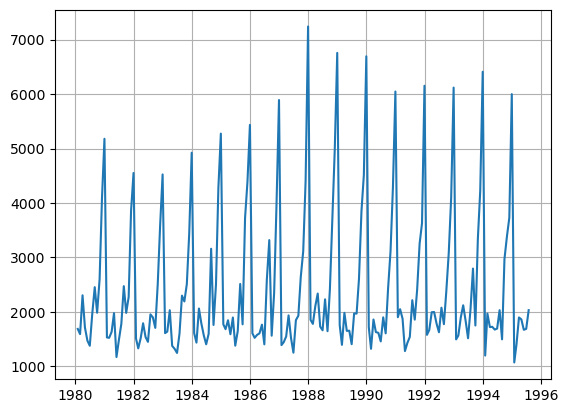

In [12]:
## let's do various plots to identify the relationship between variables in the dataset
plt.plot(df);
plt.grid()

#### Observation
- initially we expect sort of seasonality in dataset but unclear trend is dedected. 

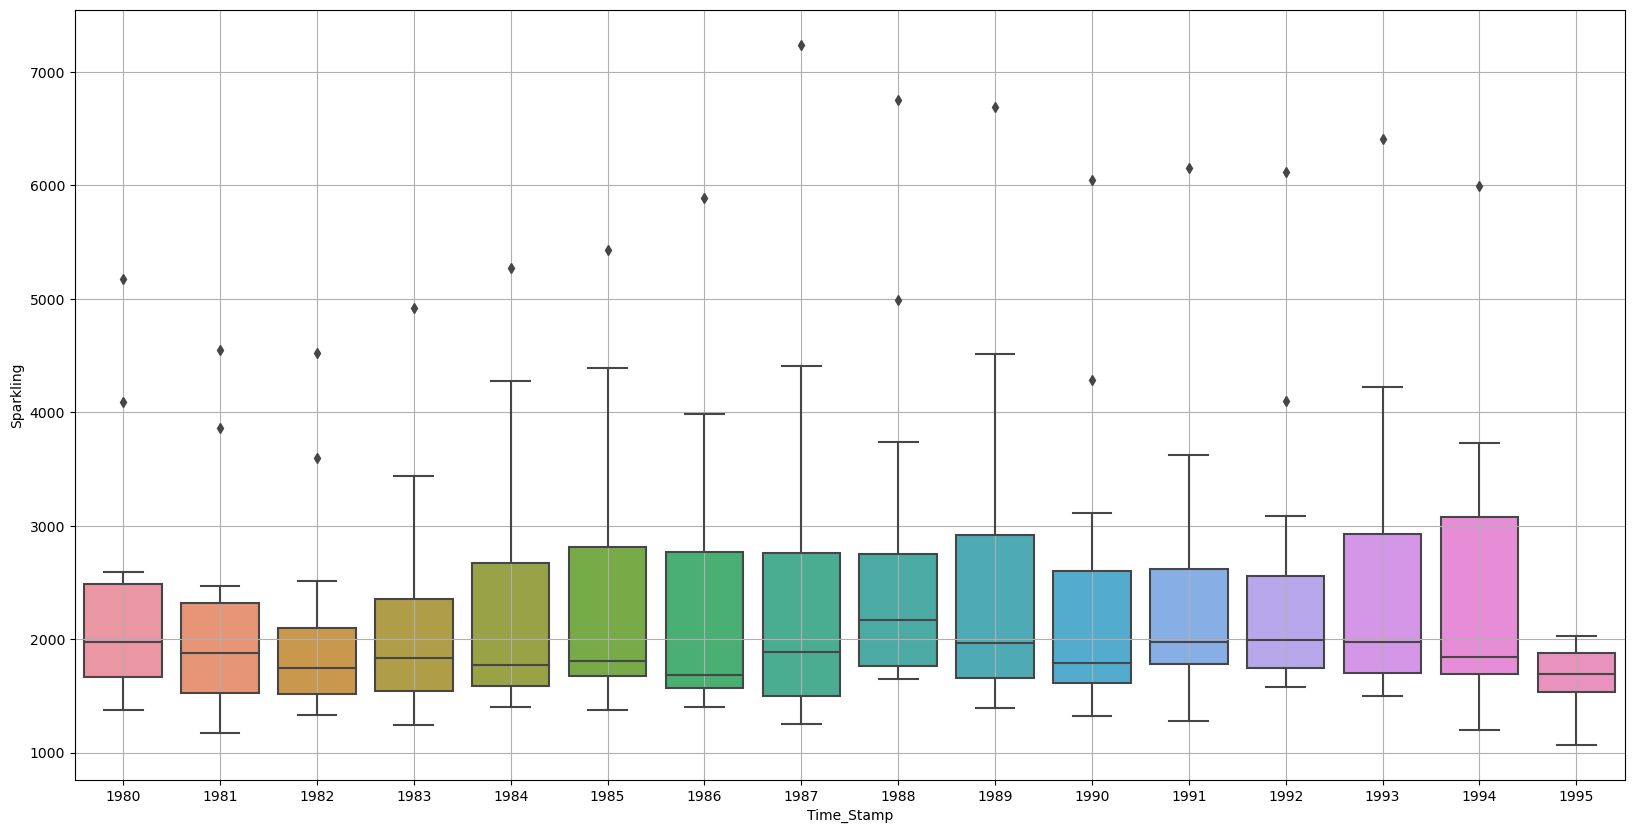

In [13]:
## let's check the variation between the variables by using boxplot
plt.figure(figsize=(20,10))
sns.boxplot(x = df.index.year,y = df['Sparkling']) 
plt.grid();

#### Observations
- we observe variations in peaks and troughs in this dataset, which years such as 1988 and 1980 recorded the highest peak where years 1995 and 1986 are the lowest.

In [14]:
## let's plot pivot table shows monthly sales across year 
monthly_sales_across_years = pd.pivot_table(df, values = 'Sparkling', columns = df.index.month, index = df.index.year)
monthly_sales_across_years

Time_Stamp,1,2,3,4,5,6,7,8,9,10,11,12
Time_Stamp,,,,,,,,,,,,
1980,1686.0,1591.0,2304.0,1712.0,1471.0,1377.0,1966.0,2453.0,1984.0,2596.0,4087.0,5179.0
1981,1530.0,1523.0,1633.0,1976.0,1170.0,1480.0,1781.0,2472.0,1981.0,2273.0,3857.0,4551.0
1982,1510.0,1329.0,1518.0,1790.0,1537.0,1449.0,1954.0,1897.0,1706.0,2514.0,3593.0,4524.0
1983,1609.0,1638.0,2030.0,1375.0,1320.0,1245.0,1600.0,2298.0,2191.0,2511.0,3440.0,4923.0
1984,1609.0,1435.0,2061.0,1789.0,1567.0,1404.0,1597.0,3159.0,1759.0,2504.0,4273.0,5274.0
1985,1771.0,1682.0,1846.0,1589.0,1896.0,1379.0,1645.0,2512.0,1771.0,3727.0,4388.0,5434.0
1986,1606.0,1523.0,1577.0,1605.0,1765.0,1403.0,2584.0,3318.0,1562.0,2349.0,3987.0,5891.0
1987,1389.0,1442.0,1548.0,1935.0,1518.0,1250.0,1847.0,1930.0,2638.0,3114.0,4405.0,7242.0
1988,1853.0,1779.0,2108.0,2336.0,1728.0,1661.0,2230.0,1645.0,2421.0,3740.0,4988.0,6757.0


#### Observation
- as we see that data 12 months in year 1995 is not completed and stops in month of July.

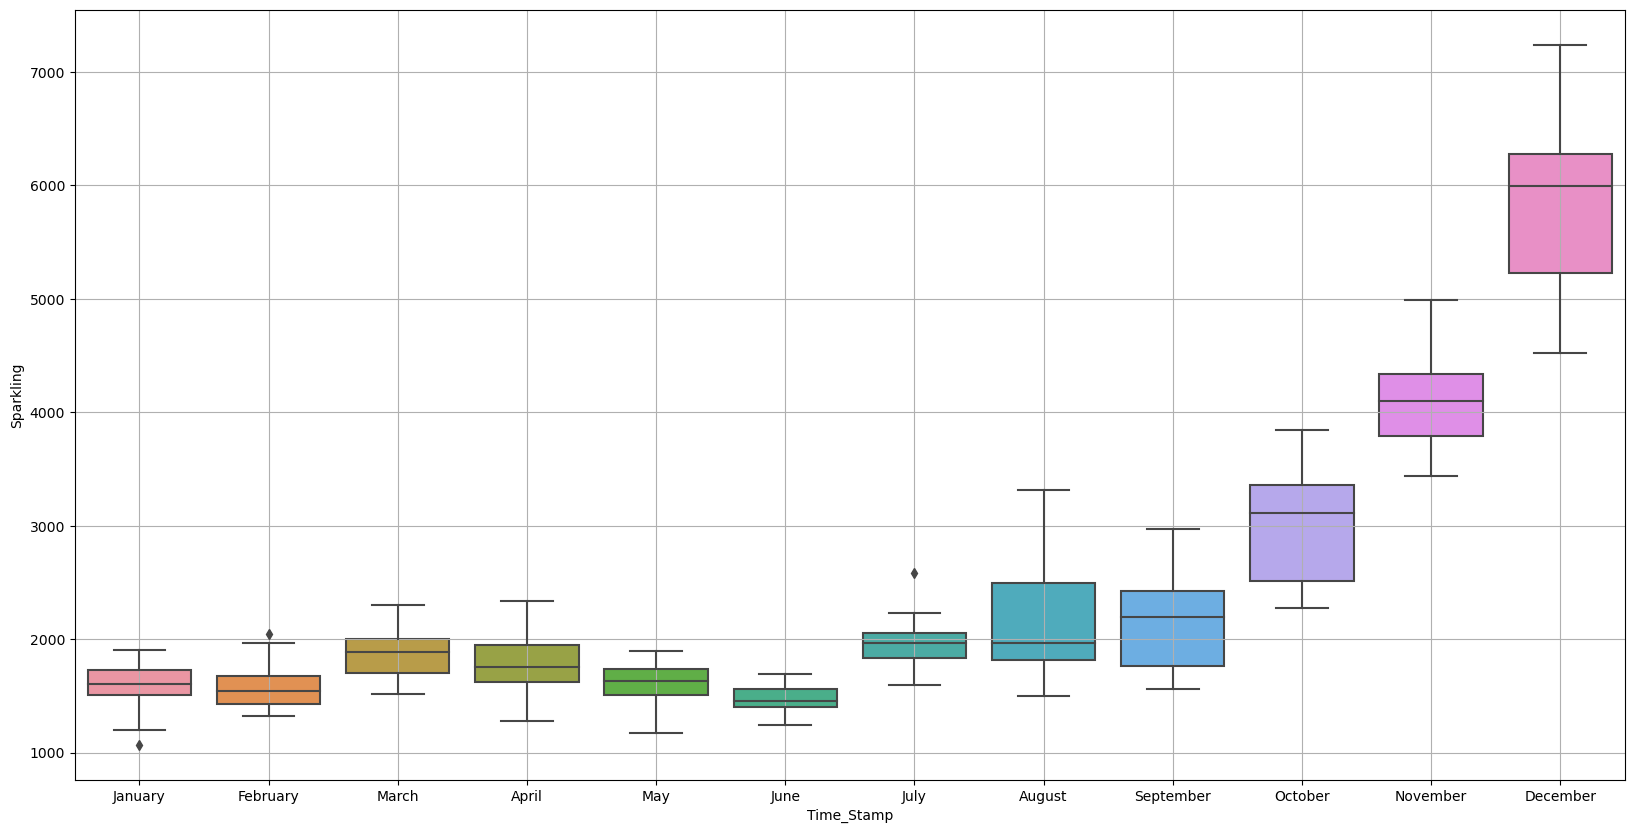

In [15]:
## let's check the same by indexing the month using boxplot.
plt.figure(figsize=(20,10))
sns.boxplot(x = df.index.month_name(),y = df['Sparkling'])
plt.grid();

#### Observations
- we observe that peak of sales happens always in Q4 and starts slightly in Q3 where lowest in Q1 and Q2 of the year.
- we observe that month december is the highest month of sales, where June is the worst.

In [16]:
## let's have an idea about the 5 number summaries using data describe
round(df.describe(),3).T

,count,mean,std,min,25%,50%,75%,max
Sparkling,187.0,2402.417,1295.112,1070.0,1605.0,1874.0,2549.0,7242.0


In [17]:
df.Sparkling.median()

1874.0

#### Obseravtion
- we observe that 50% of the sales at 1874 where min at 1070 and max at 7242, that indicates some outliers.
- the mean is 2402 and std is 1295 where median is 1874, that indicates a skewness to the right in this dataset

<Axes: ylabel='Count'>

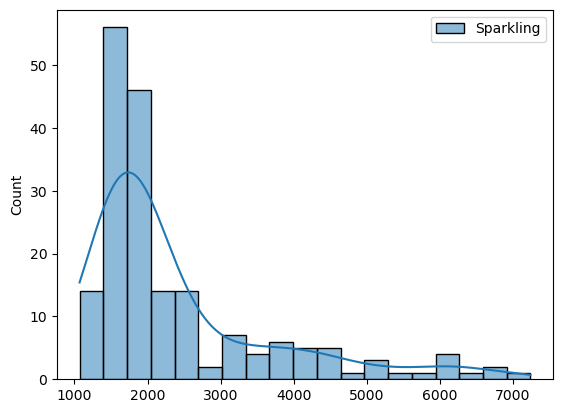

In [18]:
## let's testing the skewness by hitogram plot.
sns.histplot(df, kde = True)

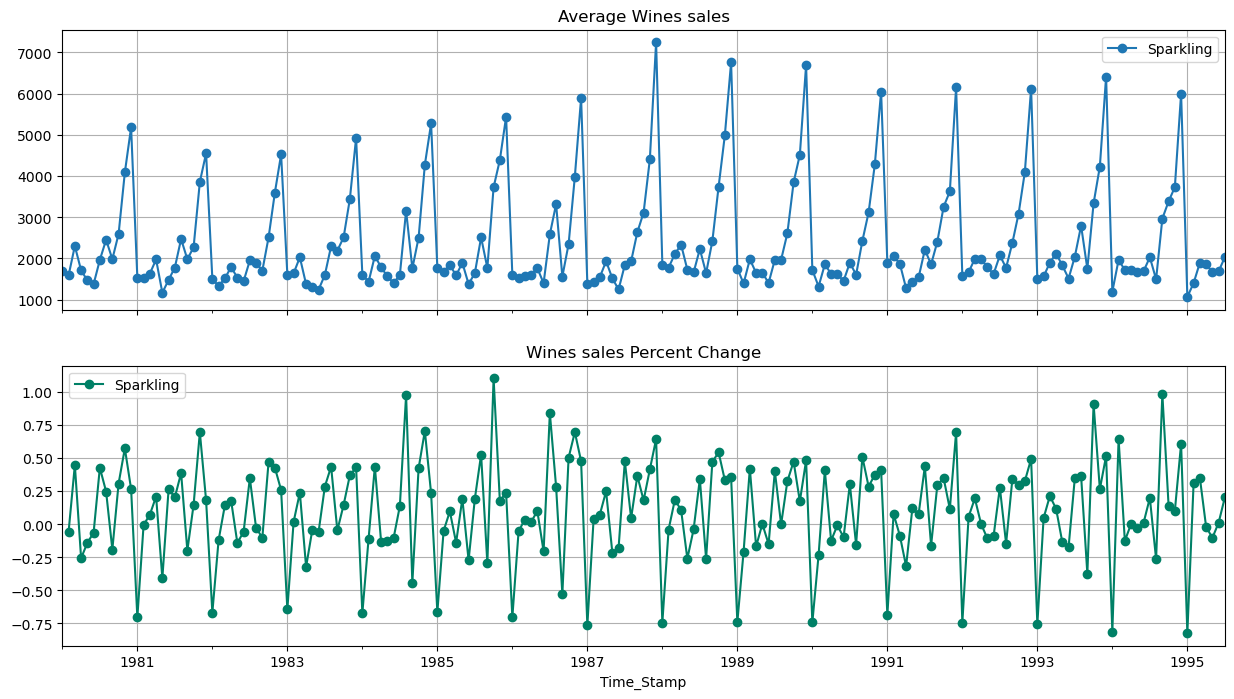

In [19]:
## Let's get the average wines sales, and precent change

average    = df.groupby(df.index)["Sparkling"].mean()
pct_change = df.groupby(df.index)["Sparkling"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average wine sales over time(year-month)
ax1 = average.plot(legend=True,ax=axis1,marker='o',title="Average Wines sales",grid=True)
ax1.set_xticks(range(len(average)))
ax1.set_xticklabels(average.index.tolist())
# plot precent change for wine sales over time(year-month)
ax2 = pct_change.plot(legend=True,ax=axis2,marker='o',colormap="summer",title="Wines sales Percent Change",grid=True)

#### Observations
- we observe from the graph above that there are kind of repeatability in difference change among sales which indicate sort of seasonality.

## Data Preparation for Modeling

#### Decomposition

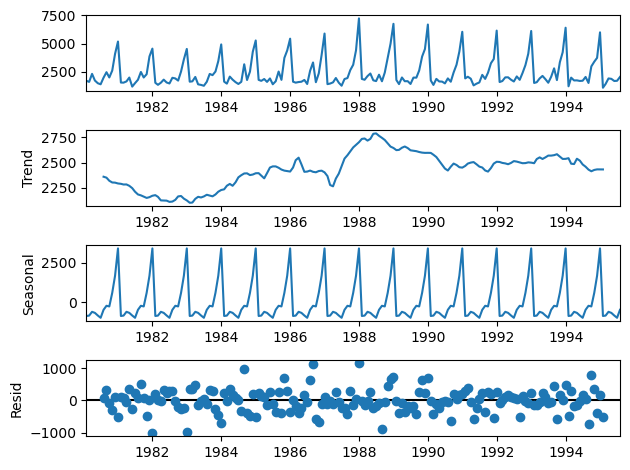

In [20]:
## before that let's check the data trend, seasonality and residuals by testing "additive" model
decomposition = seasonal_decompose(df,model='additive') 
decomposition.plot();

#### Observations
- initial observation, unclear trend, signs of seasonality and residuals around 0 and seems random but not perfect from my point of view, will confirm that after checking the another model

In [21]:
### let's extract trend, seasonality and residuals values
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

print('Trend','\n',trend.head(12),'\n')
print('Seasonality','\n',seasonality.head(12),'\n')
print('Residual','\n',residual.head(12),'\n')

Trend 
 Time_Stamp
1980-01-31            NaN
1980-02-29            NaN
1980-03-31            NaN
1980-04-30            NaN
1980-05-31            NaN
1980-06-30            NaN
1980-07-31    2360.666667
1980-08-31    2351.333333
1980-09-30    2320.541667
1980-10-31    2303.583333
1980-11-30    2302.041667
1980-12-31    2293.791667
Name: trend, dtype: float64 

Seasonality 
 Time_Stamp
1980-01-31    -854.260599
1980-02-29    -830.350678
1980-03-31    -592.356630
1980-04-30    -658.490559
1980-05-31    -824.416154
1980-06-30    -967.434011
1980-07-31    -465.502265
1980-08-31    -214.332821
1980-09-30    -254.677265
1980-10-31     599.769957
1980-11-30    1675.067179
1980-12-31    3386.983846
Name: seasonal, dtype: float64 

Residual 
 Time_Stamp
1980-01-31           NaN
1980-02-29           NaN
1980-03-31           NaN
1980-04-30           NaN
1980-05-31           NaN
1980-06-30           NaN
1980-07-31     70.835599
1980-08-31    315.999487
1980-09-30    -81.864401
1980-10-31   -307.3532

In [22]:
## let's test the residual normality for additive model (Shapiro Test)
residual.mean()

-1.2088458994707376

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1193147428.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual)


<Axes: xlabel='resid', ylabel='Density'>

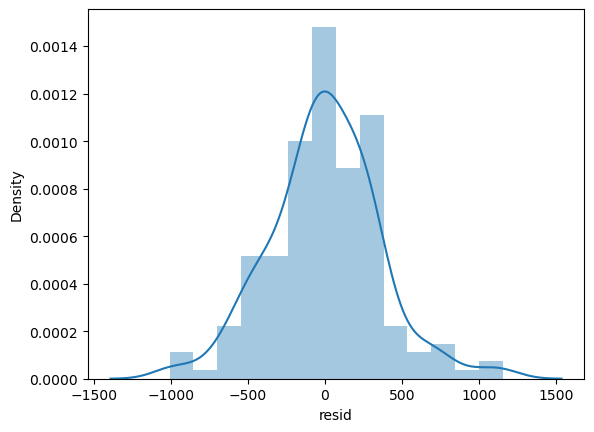

In [23]:
from scipy.stats import shapiro

sns.distplot(residual)

#### Observations
- looks or close to a normal dist. but still not a perfect one. again will confirm that very shortly.

In [24]:
## to corss check let's obtain pvalue where H0 that data is normal dist.
shapiro(residual.dropna())

ShapiroResult(statistic=0.9833050966262817, pvalue=0.034331172704696655)

#### Observations
the p-value is less than 0.05, then the null hypothesis that the data are normally distributed is rejected

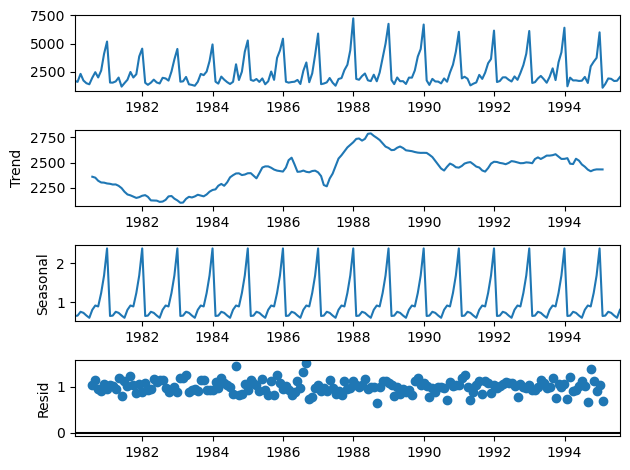

In [25]:
## now will do same steps for the another model which is multiplicative approach
decomposition2 = seasonal_decompose(df,model='multiplicative')
decomposition2.plot();

In [26]:
residual2 = decomposition2.resid
residual2.mean()

0.9997456359115032

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1547043968.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual2)


<Axes: xlabel='resid', ylabel='Density'>

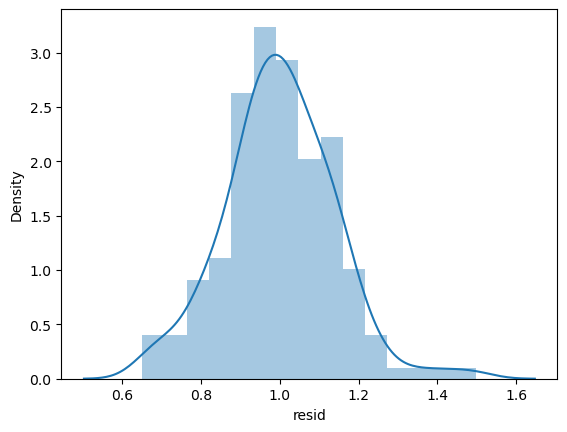

In [27]:
sns.distplot(residual2)

In [28]:
shapiro(residual2.dropna())

ShapiroResult(statistic=0.9859988689422607, pvalue=0.07802142202854156)

#### Observations
 - the p-value is greater than 0.05, then we do not have significant evidence sign to reject the null hypothesis, so the data are normally distributed.
 - in this case, we will confirm the multiplicative model

#### Data preparation for Model

In [29]:
## First let's check the data range to determine the range of train and test data
print(df.index.year.unique())

Int64Index([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
            1991, 1992, 1993, 1994, 1995],
           dtype='int64', name='Time_Stamp')


In [30]:
## so since count of the data is 16 year starts from 1980 and end 1995
## let's take first 12 years for training and rest fro test data as below:
df_train = df[df.index <= '1992']
df_test = df[df.index > '1992']

In [31]:
print(df_train.shape)
print(df_test.shape)

(144, 1)
(43, 1)


In [32]:
## let's check that we captured the righ sequence
print(df_train.tail())
print(df_test.head())

            Sparkling
Time_Stamp           
1991-08-31       1857
1991-09-30       2408
1991-10-31       3252
1991-11-30       3627
1991-12-31       6153
            Sparkling
Time_Stamp           
1992-01-31       1577
1992-02-29       1667
1992-03-31       1993
1992-04-30       1997
1992-05-31       1783


#### good to go.....

## Model Building 

#### Model #1 - Linear Regression Model

In [33]:
## for linear reg model, we must prepare the train data using forloop to crate time,
## so we can regress the sparkling variables vs order of the occurrence as under:
train_time = [i+1 for i in range(len(df_train))]
test_time = [i+133 for i in range(len(df_test))]
print('Training Time instance','\n',train_time)
print('Test Time instance','\n',test_time)


Training Time instance 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]
Test Time instance 
 [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175]


In [34]:
## now let's take a copy of the original train and test data
LinearRegression_train = df_train.copy()
LinearRegression_test = df_test.copy()

In [35]:
## let's append time col into the copied data
LinearRegression_train['time'] = train_time
LinearRegression_test['time'] = test_time
print('First five rows of Training Data','\n',LinearRegression_train.head(),'\n')
print('Last five rows of Training Data','\n',LinearRegression_train.tail(),'\n')
print('First five rows of Test Data','\n',LinearRegression_test.head(),'\n')
print('Last five rows of Test Data','\n',LinearRegression_test.tail(),'\n')

First five rows of Training Data 
             Sparkling  time
Time_Stamp                 
1980-01-31       1686     1
1980-02-29       1591     2
1980-03-31       2304     3
1980-04-30       1712     4
1980-05-31       1471     5 

Last five rows of Training Data 
             Sparkling  time
Time_Stamp                 
1991-08-31       1857   140
1991-09-30       2408   141
1991-10-31       3252   142
1991-11-30       3627   143
1991-12-31       6153   144 

First five rows of Test Data 
             Sparkling  time
Time_Stamp                 
1992-01-31       1577   133
1992-02-29       1667   134
1992-03-31       1993   135
1992-04-30       1997   136
1992-05-31       1783   137 

Last five rows of Test Data 
             Sparkling  time
Time_Stamp                 
1995-03-31       1897   171
1995-04-30       1862   172
1995-05-31       1670   173
1995-06-30       1688   174
1995-07-31       2031   175 



In [36]:
## now, the data good to go for reg model, let's create it over here:
lr = LinearRegression()

In [37]:
## let's fit the model
lr.fit(LinearRegression_train[['time']],LinearRegression_train['Sparkling'].values)

LinearRegression()

In [38]:
## now, let's predict based on test data as under:
test_prediction_model = lr.predict(LinearRegression_test[['time']])
LinearRegression_test['RegOnTime']=test_prediction_model

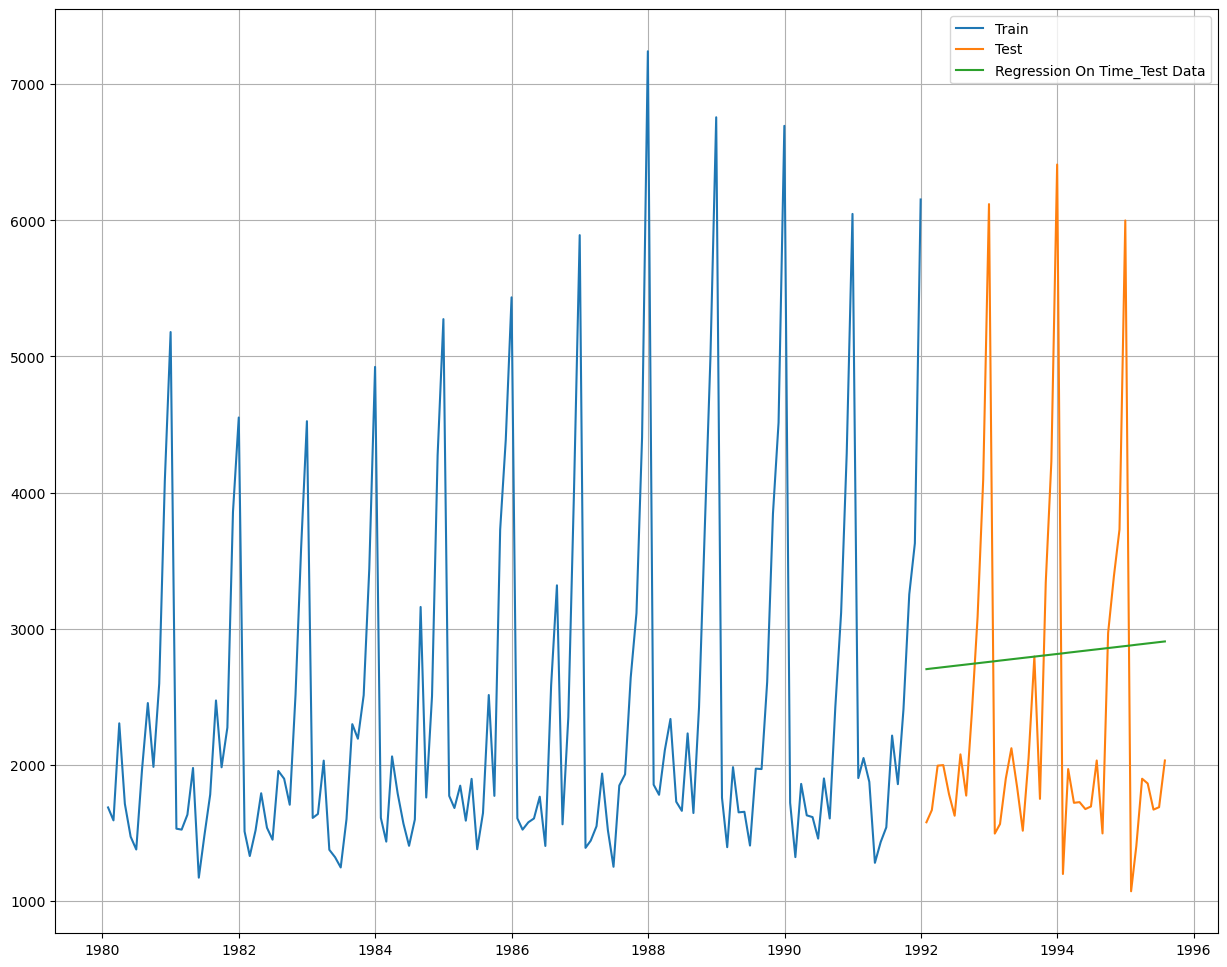

In [39]:
## this the time to plot the prediction results and check how fit is it!!
plt.figure(figsize=(15,12))
plt.plot(df_train['Sparkling'],label='Train')
plt.plot(df_test['Sparkling'],label='Test')
plt.plot(LinearRegression_test['RegOnTime'],label='Regression On Time_Test Data')
plt.legend(loc='best')
plt.grid();

#### Observations
- as we see it shows flatted line capturing the trend but doesn't capturing the seasonality

In [40]:
## now, lets' validate the model and check rmse
rmse_model_test1= metrics.mean_squared_error(df_test['Sparkling'],test_prediction_model,squared=False)
print("For RegressionOnTime forecast on the Test Data,  RMSE is %3.3f" %(rmse_model_test1))

For RegressionOnTime forecast on the Test Data,  RMSE is 1337.090


In [41]:
## let's create a dataframe for the results to use it further to compare the results of other models
resultsDf = pd.DataFrame({'Test RMSE': [rmse_model_test1]},index=['RegressionOnTime'])
resultsDf


,Test RMSE
RegressionOnTime,1337.09022


### Model #2 - Naive Model
###### Naive model work under the assumption that the future will resemble the recent past., primarily rely on the most recent data point 

In [42]:
## let's take copy of original  train and test data for Naive method working
NaiveModel_train = df_train.copy()
NaiveModel_test = df_test.copy()

In [43]:
## let's checj the shape for train and test
NaiveModel_train.shape

(144, 1)

In [44]:
NaiveModel_test.shape

(43, 1)

In [45]:
## let's check the test before applying Naive approch and append last opservation
NaiveModel_test.head()


,Sparkling
Time_Stamp,
1992-01-31,1577
1992-02-29,1667
1992-03-31,1993
1992-04-30,1997
1992-05-31,1783


In [46]:
## append last opservations in training set using asarray indexing -1
NaiveModel_test['naive'] = np.asarray(df_train['Sparkling'])[len(np.asarray(df_train['Sparkling']))-1]
NaiveModel_test['naive'].head()

Time_Stamp
1992-01-31    6153
1992-02-29    6153
1992-03-31    6153
1992-04-30    6153
1992-05-31    6153
Name: naive, dtype: int64

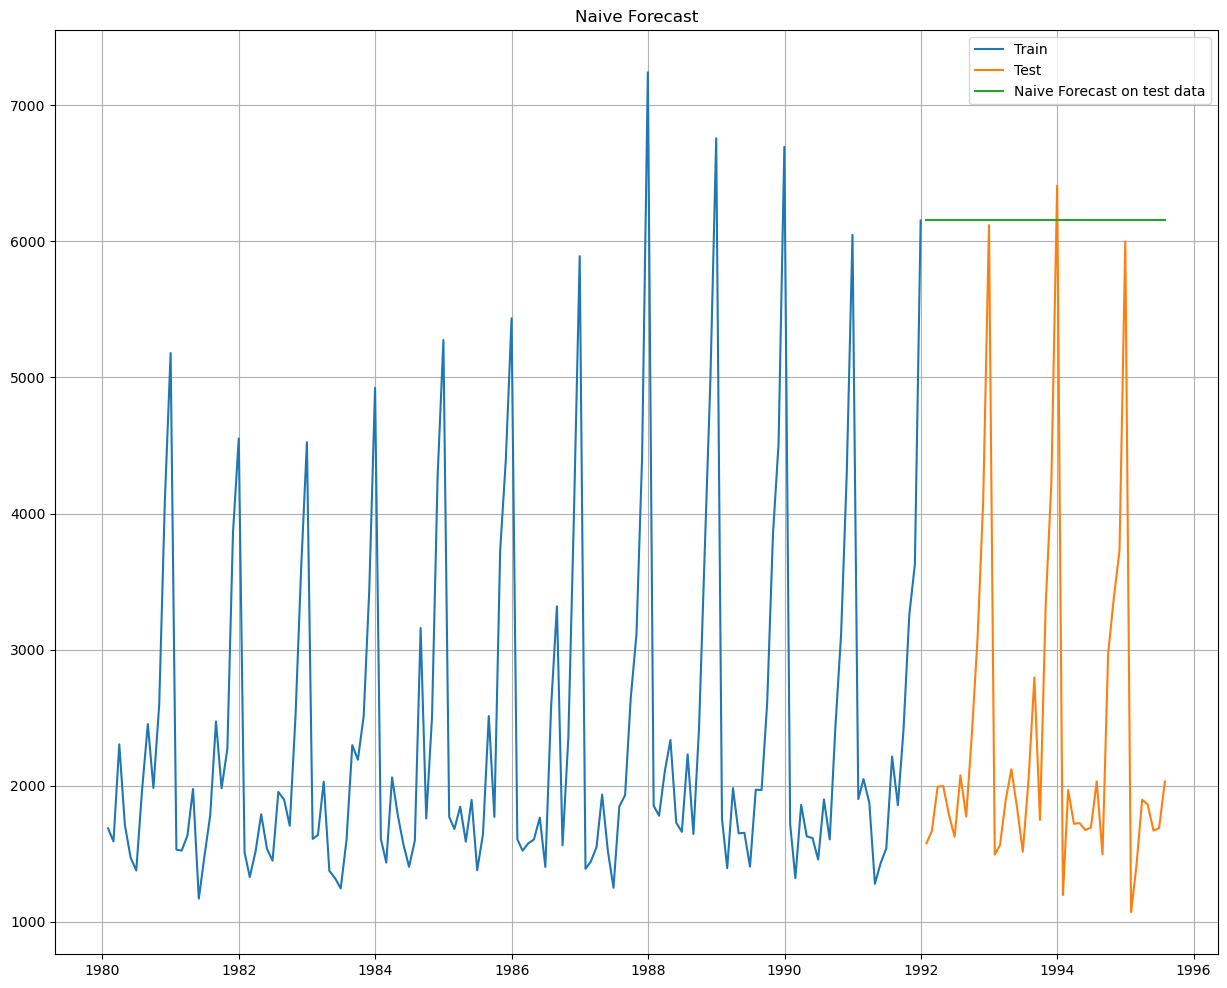

In [47]:
## let's plot again and check how the Naive model fit the data.
plt.figure(figsize=(15,12))
plt.plot(NaiveModel_train['Sparkling'],label='Train')
plt.plot(df_test['Sparkling'],label='Test')
plt.plot(NaiveModel_test['naive'], label='Naive Forecast on test data')
plt.legend(loc='best')
plt.title('Naive Forecast')
plt.grid();


#### as observed that flatted line does not cpaturing the right curve

In [48]:
## now, let's validate and check the RMSE as under:
rmse_model_test2 = metrics.mean_squared_error(df_test['Sparkling'],NaiveModel_test['naive'],squared=False)
print("For Naive On Time Forecast on the Test Data, RMSE is %3.3f" %(rmse_model_test2))

For Naive On Time Forecast on the Test Data, RMSE is 3979.915


In [49]:
## let's add the result to the RMSE data frame we have created earlier
resultsDfN = pd.DataFrame({'Test RMSE': [rmse_model_test2]}, index=['Naive On Time Forecast']) 
resultsDf = pd.concat([resultsDf,resultsDfN])
resultsDf

,Test RMSE
RegressionOnTime,1337.090220
Naive On Time Forecast,3979.914692


#### as observed looks far worst than reg model

### Model #3 - Simple Average Model
##### will predict using the average of training dataset

In [50]:
## let's copy the orignal train and test data fro simple average model
SimpleAverage_train = df_train.copy()
SimpleAverage_test = df_test.copy()

In [51]:
## let's take the mean of training data and appended into test data
SimpleAverage_test['mean_training']= df_train['Sparkling'].mean()
SimpleAverage_test.head()

,Sparkling,mean_training
Time_Stamp,,
1992-01-31,1577,2408.930556
1992-02-29,1667,2408.930556
1992-03-31,1993,2408.930556
1992-04-30,1997,2408.930556
1992-05-31,1783,2408.930556


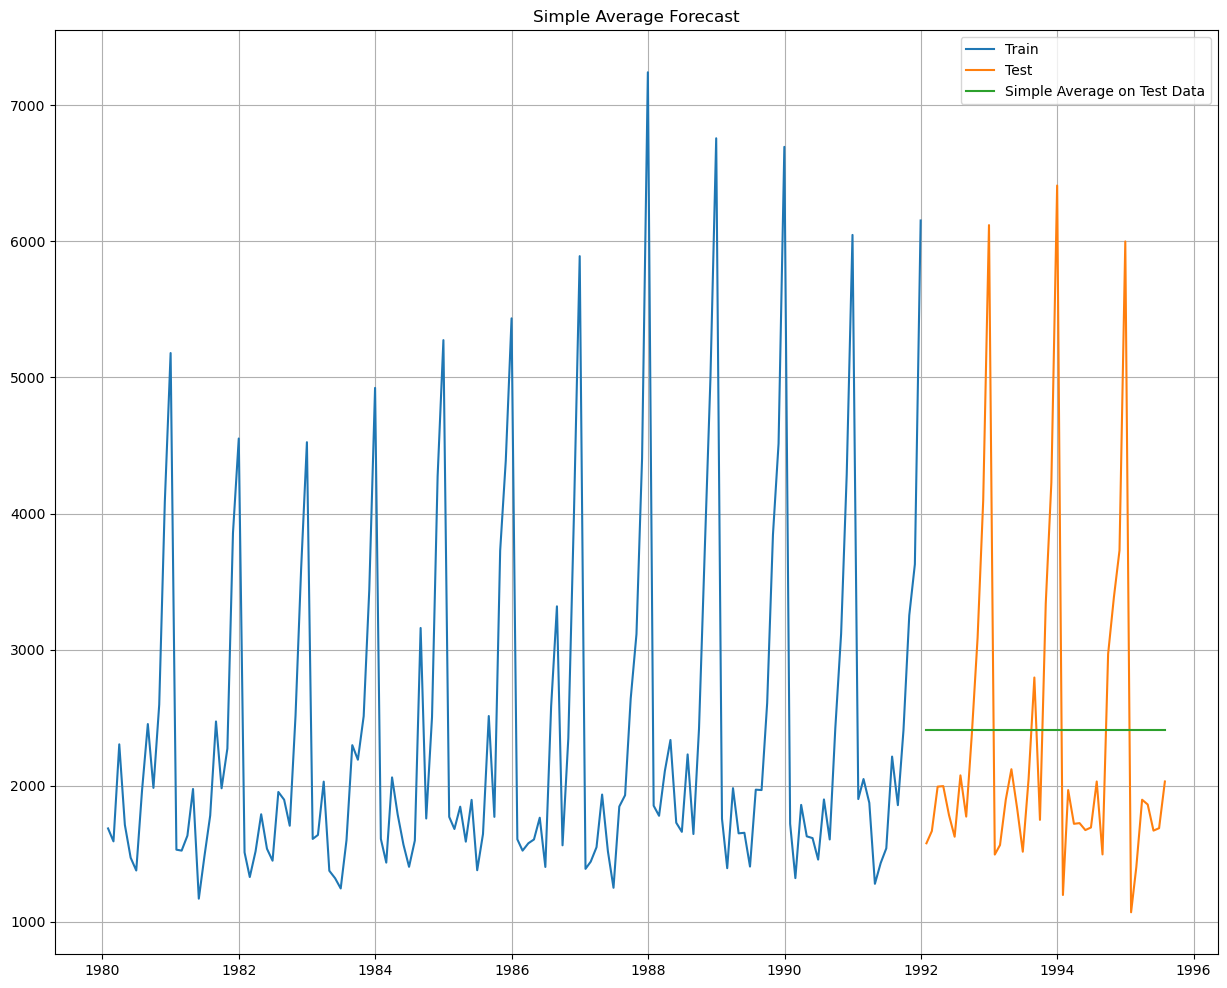

In [52]:
## let's plot it and check how does it fits the data
plt.figure(figsize=(15,12))
plt.plot(df_train['Sparkling'],label='Train')
plt.plot(df_test['Sparkling'], label='Test')
plt.plot(SimpleAverage_test['mean_training'],label='Simple Average on Test Data')
plt.legend(loc='best')
plt.title("Simple Average Forecast")
plt.grid();

#### Observation
- agin flatted line nad does not fit properly.

In [53]:
## let's check rmse for model3
rmse_model_test3 = metrics.mean_squared_error(df_test['Sparkling'],SimpleAverage_test['mean_training'],squared=False)
print("For Simple Average Forecast on Test Data, RMSE is %3.3f"%(rmse_model_test3))

For Simple Average Forecast on Test Data, RMSE is 1268.683


In [54]:
## let's add the results into our comparison data frame
resultsDfSA = pd.DataFrame({'Test RMSE':  [rmse_model_test3]},index=['Simple Average Forecast']) 
resultsDf = pd.concat([resultsDf,resultsDfSA])
resultsDf

,Test RMSE
RegressionOnTime,1337.090220
Naive On Time Forecast,3979.914692
Simple Average Forecast,1268.683035


#### simple average seems to be lowest error at this point 

### Model #4 - Simple Exponential Smoothing Model
##### SES works by creating a weighted average of past observations  for time series data with no trend and no seasonal patterns

In [55]:
## let's copy the orignal train and test data fro Exponential Smoothing Model
SES_train = df_train.copy()
SES_test = df_test.copy()


In [56]:
## let's initiate the SES model
model_SES = SimpleExpSmoothing(SES_train['Sparkling'])

/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [57]:
## fiting the model
model_SES_autofit = model_SES.fit(optimized=True)

/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [58]:
## findout the parameter
model_SES_autofit.params

{'smoothing_level': 0.05296016933903177,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1862.4011042747693,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [59]:
## let's predict the values using opt SES
SES_test['predict'] = model_SES_autofit.forecast(steps=len(df_test))
SES_test.head()

,Sparkling,predict
Time_Stamp,,
1992-01-31,1577,2698.240092
1992-02-29,1667,2698.240092
1992-03-31,1993,2698.240092
1992-04-30,1997,2698.240092
1992-05-31,1783,2698.240092


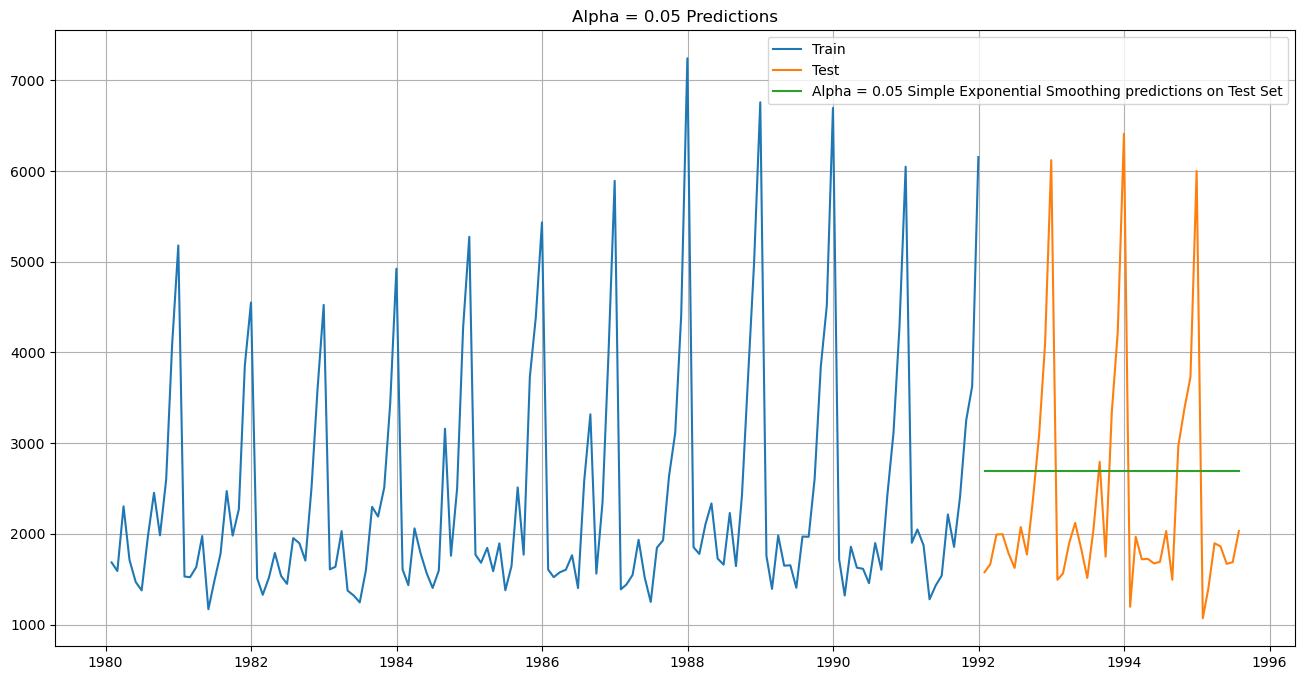

In [60]:
## let's plot the result the to check the model fits the data
plt.figure(figsize=(16,8))
plt.plot(SES_train['Sparkling'], label='Train')
plt.plot(SES_test['Sparkling'], label='Test')

plt.plot(SES_test['predict'], label='Alpha = 0.05 Simple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Alpha = 0.05 Predictions');

In [61]:
## model4 vlaidation
rmse_model_test4 = metrics.mean_squared_error(SES_test['Sparkling'],SES_test['predict'],squared=False)
print("For Alpha = 0.05 SES Model on Test Data,RMSE is %3.3f" %(rmse_model_test4))

For Alpha = 0.05 SES Model on Test Data,RMSE is 1307.535


In [62]:
## let's add the SES result to the models validations results data frame
resultsDfSES = pd.DataFrame({'Test RMSE': [rmse_model_test4]},index=['For Alpha = 0.05 SES Model']) 
resultsDf = pd.concat([resultsDf, resultsDfSES])
resultsDf

,Test RMSE
RegressionOnTime,1337.090220
Naive On Time Forecast,3979.914692
Simple Average Forecast,1268.683035
For Alpha = 0.05 SES Model,1307.534534


#### Observation
- as we noticed that the data have sort of seasonality so it is known that using SES might not be a good option in this stage. however, it shows the lowest error among past models results.
- However, we may imporve the results by finding the best alpha values using different alpha values by creating forloop

In [63]:
## creating empty dataframe to save the estimated alpha values in it 
resultsDfSES_1 = pd.DataFrame({'Alpha Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDfSES_1

,Alpha Values,Train RMSE,Test RMSE


In [64]:
## now, let's apply the the loop for estimated alpha value between 0.3 and 1, step 0.1
for i in np.arange(0.3,1,0.1):
    model_SES_alpha_i = model_SES.fit(smoothing_level=i,optimized=False,use_brute=True)
    SES_train['predict',i] = model_SES_alpha_i.fittedvalues
    SES_test['predict',i] = model_SES_alpha_i.forecast(steps=55)
    
    rmse_model5_train_i = metrics.mean_squared_error(SES_train['Sparkling'],SES_train['predict',i],squared=False)
    
    rmse_model5_test_i = metrics.mean_squared_error(SES_test['Sparkling'],SES_test['predict',i],squared=False)
    
    resultsDfSES_1 = resultsDfSES_1.append({'Alpha Values':i,'Train RMSE':rmse_model5_train_i 
                                      ,'Test RMSE':rmse_model5_test_i}, ignore_index=True)

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/2116061022.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsDfSES_1 = resultsDfSES_1.append({'Alpha Values':i,'Train RMSE':rmse_model5_train_i
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/2116061022.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsDfSES_1 = resultsDfSES_1.append({'Alpha Values':i,'Train RMSE':rmse_model5_train_i
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/2116061022.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsDfSES_1 = resultsDfSES_1.append({'Alpha Values':i,'Train RMSE':rmse_model5_train_i
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/2116061022.

In [65]:
resultsDfSES_1.sort_values(by=['Test RMSE'],ascending=True)

,Alpha Values,Train RMSE,Test RMSE
0,0.3,1362.731346,1900.058569
1,0.4,1356.208919,2260.069389
2,0.5,1347.944758,2606.296390
3,0.6,1343.099607,2924.118301
4,0.7,1343.640190,3214.744366
5,0.8,1349.991473,3483.731806
6,0.9,1362.270034,3736.981096


##### as observed, that alpha 03 is the best alpha value as it showes the lowest Test RMSE

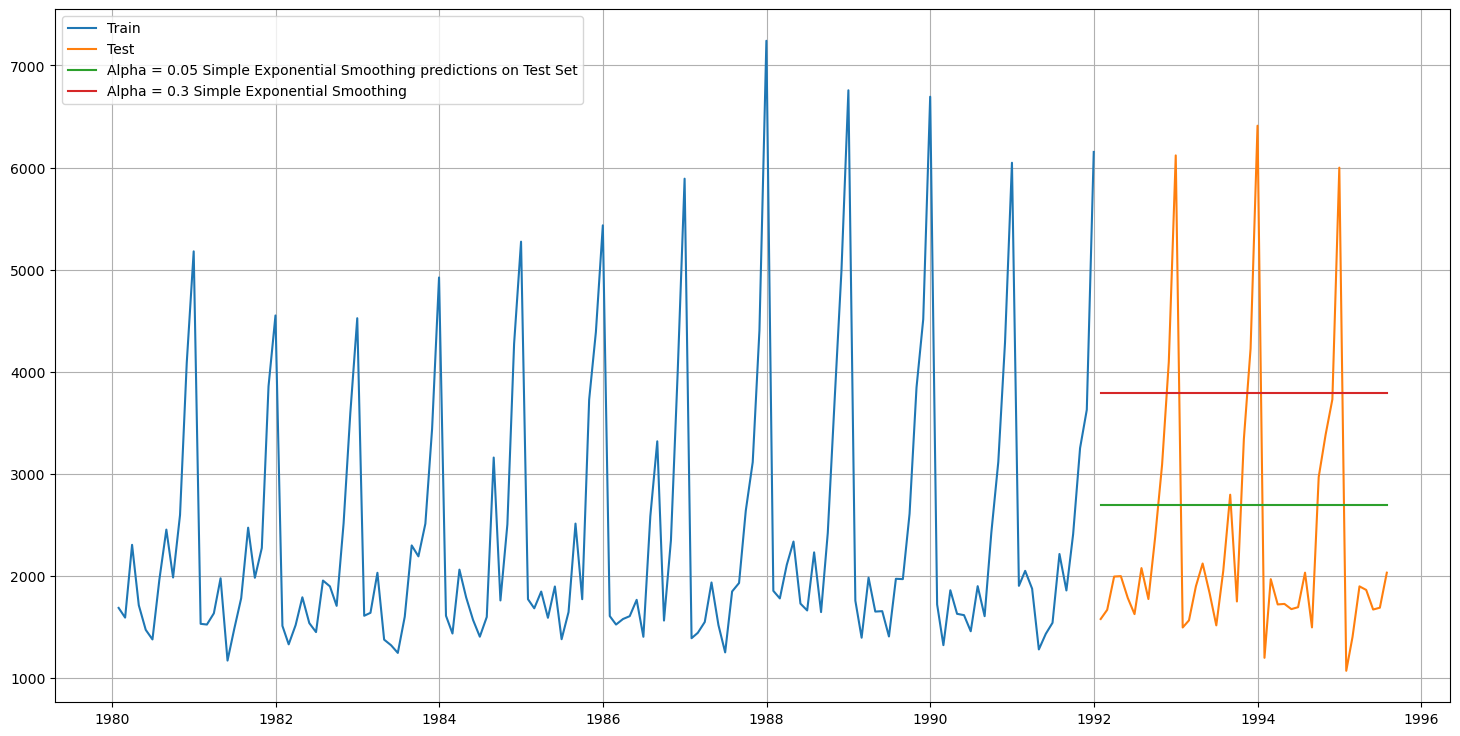

In [66]:
## now let's plot again using the best value of alpha 0.3
plt.figure(figsize=(18,9))
plt.plot(SES_train['Sparkling'], label='Train')
plt.plot(SES_test['Sparkling'], label='Test')

plt.plot(SES_test['predict'], label='Alpha = 0.05 Simple Exponential Smoothing predictions on Test Set')

plt.plot(SES_test['predict', 0.3], label='Alpha = 0.3 Simple Exponential Smoothing')



plt.legend(loc='best')
plt.grid();


In [67]:
## let's validate the model using alpha 0.03
rmse_model_test4_a = metrics.mean_squared_error(SES_test['Sparkling'],SES_test['predict',0.3],squared=False)
print("For Alpha = 0.3 SES Model on Test Data,RMSE is %3.3f" %(rmse_model_test4_a))

For Alpha = 0.3 SES Model on Test Data,RMSE is 1900.059


In [68]:
## let's append the result into the results data frame
resultsDfSES_a = pd.DataFrame({'Test RMSE': [rmse_model_test4_a]},index=['For Alpha = 0.3 SES Model'])
resultsDf = pd.concat([resultsDf, resultsDfSES_a])
resultsDf


,Test RMSE
RegressionOnTime,1337.090220
Naive On Time Forecast,3979.914692
Simple Average Forecast,1268.683035
For Alpha = 0.05 SES Model,1307.534534
For Alpha = 0.3 SES Model,1900.058569


#### Observation
- we observe that no improvement for Alpha became 0.03

### Model #5 - Double Exponential Smoothing (Holt)
####  this model forecasts are made by combining the estimated level and trend

In [69]:
## let's copy the orignal train and test data for DES Model
DES_train = df_train.copy()
DES_test = df_test.copy()

In [70]:
## now, let's create the model
model_DES =  Holt(DES_train['Sparkling'])

/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [71]:
## fit the model
model_DES_autofit = model_DES.fit()

/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [72]:
## obtain the param
model_DES_autofit.params

{'smoothing_level': 0.6885714285714285,
 'smoothing_trend': 9.999999999999999e-05,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1686.0,
 'initial_trend': -95.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

#### Observations
- as we observed that the model gave the following prams 'Alpha = 0.688,Beta = 9.99e-05

In [73]:
## let's us check the test data shape befor applying our model
DES_test.shape

(43, 1)

In [74]:
## let's predict using created model with prams
DES_test['auto_predict'] = model_DES_autofit.forecast(steps=55)
DES_test.head()

,Sparkling,auto_predict
Time_Stamp,,
1992-01-31,1577,5164.113674
1992-02-29,1667,5070.828157
1992-03-31,1993,4977.542640
1992-04-30,1997,4884.257122
1992-05-31,1783,4790.971605


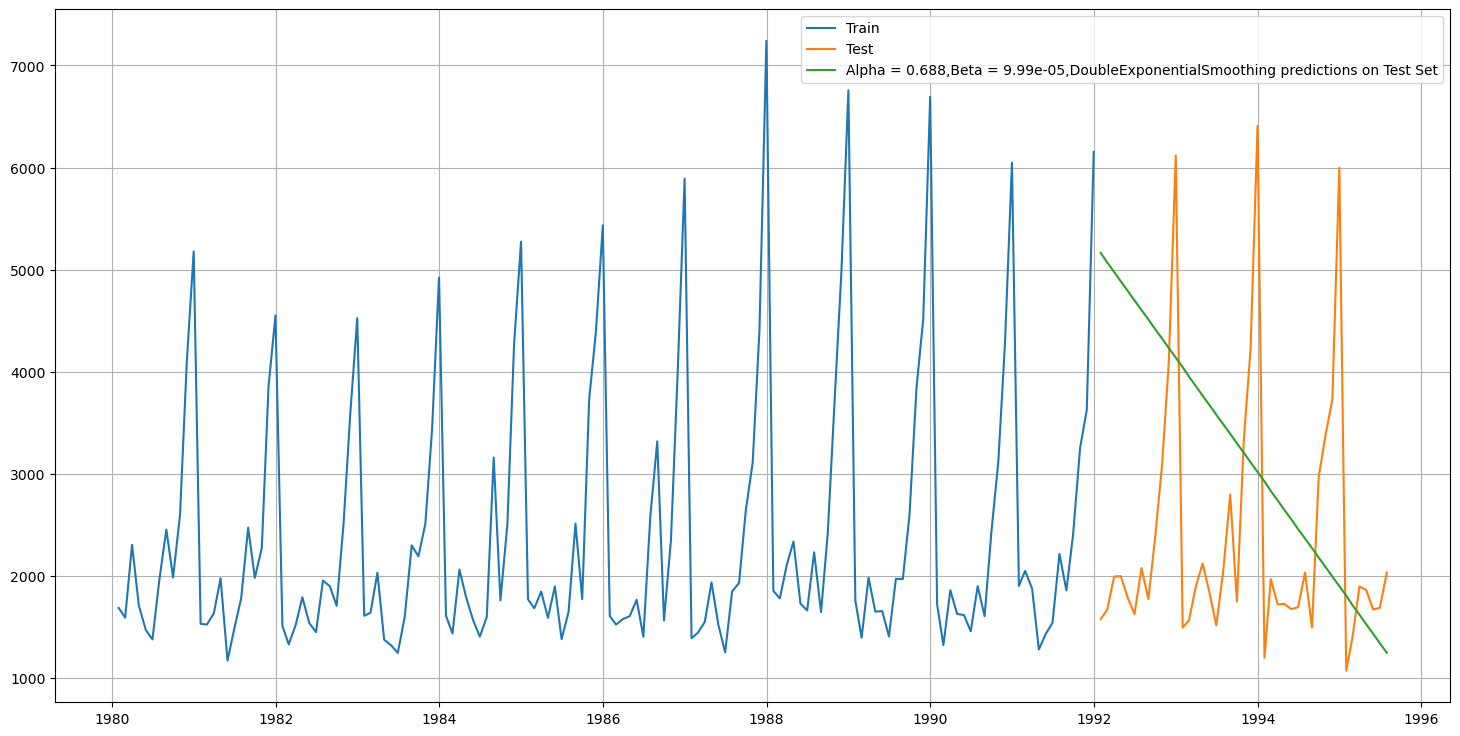

In [75]:
## let's plot the results and see how it fits
plt.figure(figsize=(18,9))
plt.plot(DES_train['Sparkling'], label='Train')
plt.plot(DES_test['Sparkling'], label='Test')

plt.plot(DES_test['auto_predict'], label='Alpha = 0.688,Beta = 9.99e-05,DoubleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid();

In [76]:
rmse_model_test5 = metrics.mean_squared_error(DES_test['Sparkling'],DES_test['auto_predict'],squared=False)
print("For Alpha=0.688,Beta=0.00009,DoubleExponentialSmoothing predictions on Test Data,  RMSE is %3.3f" %(rmse_model_test5))

For Alpha=0.688,Beta=0.00009,DoubleExponentialSmoothing predictions on Test Data,  RMSE is 1923.793


In [77]:
resultsDf_DES = pd.DataFrame({'Test RMSE': [rmse_model_test5]}
                           ,index=['For Alpha=0.688,Beta=0.00009,DES Model'])  

resultsDf = pd.concat([resultsDf, resultsDf_DES])
resultsDf

,Test RMSE
RegressionOnTime,1337.090220
Naive On Time Forecast,3979.914692
Simple Average Forecast,1268.683035
For Alpha = 0.05 SES Model,1307.534534
For Alpha = 0.3 SES Model,1900.058569
"For Alpha=0.688,Beta=0.00009,DES Model",1923.793446


#### Observations
- as observed using recommended parms did not provide statisfied result comapred to other models
- but we can always imporve it by findign the the optimal value for Alpha and beta as under:

In [78]:
resultsDf_DES_a = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_DES_a

,Alpha Values,Beta Values,Train RMSE,Test RMSE


In [79]:
## creating empty DF to save the estimated values of Alpha and beta
for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        model_DES_alpha_i_j = model_DES.fit(smoothing_level=i,smoothing_trend=j,optimized=False,use_brute=True)
        DES_train['predict',i,j] = model_DES_alpha_i_j.fittedvalues
        DES_test['predict',i,j] = model_DES_alpha_i_j.forecast(steps=55)
        
        rmse_model_train = metrics.mean_squared_error(DES_train['Sparkling'],DES_train['predict',i,j],squared=False)
        
        rmse_model_test = metrics.mean_squared_error(DES_test['Sparkling'],DES_test['predict',i,j],squared=False)
        
        resultsDf_DES_a = resultsDf_DES_a.append({'Alpha Values':i,'Beta Values':j,'Train RMSE':rmse_model_train
                                          ,'Test RMSE':rmse_model_test}, ignore_index=True)

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/953723357.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsDf_DES_a = resultsDf_DES_a.append({'Alpha Values':i,'Beta Values':j,'Train RMSE':rmse_model_train
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/953723357.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsDf_DES_a = resultsDf_DES_a.append({'Alpha Values':i,'Beta Values':j,'Train RMSE':rmse_model_train
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/953723357.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsDf_DES_a = resultsDf_DES_a.append({'Alpha Values':i,'Beta Values':j,'Train RMSE':rmse_model_train
/var/folders/96/2fhhdcjn663fz4tk2p

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/953723357.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsDf_DES_a = resultsDf_DES_a.append({'Alpha Values':i,'Beta Values':j,'Train RMSE':rmse_model_train
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/953723357.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsDf_DES_a = resultsDf_DES_a.append({'Alpha Values':i,'Beta Values':j,'Train RMSE':rmse_model_train
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/953723357.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsDf_DES_a = resultsDf_DES_a.append({'Alpha Values':i,'Beta Values':j,'Train RMSE':rmse_model_train
/var/folders/96/2fhhdcjn663fz4tk2p

In [80]:
resultsDf_DES_a

,Alpha Values,Beta Values,Train RMSE,Test RMSE
0,0.3,0.3,1599.398181,13814.398308
1,0.3,0.4,1693.819564,19249.257218
2,0.3,0.5,1787.968431,25220.937509
3,0.3,0.6,1869.621048,30999.575422
4,0.3,0.7,1924.361969,35373.748973
...,...,...,...,...
59,1.0,0.6,1763.627030,46430.302616
60,1.0,0.7,1836.249003,51556.840448
61,1.0,0.8,1914.279905,56638.252606
62,1.0,0.9,1999.225625,61791.274624


In [81]:
## let's sort the values Asc
resultsDf_DES_a.sort_values(by=['Test RMSE']).head()

,Alpha Values,Beta Values,Train RMSE,Test RMSE
0,0.3,0.3,1599.398181,13814.398308
8,0.4,0.3,1578.236948,18044.669982
1,0.3,0.4,1693.819564,19249.257218
16,0.5,0.3,1538.865716,20684.637333
24,0.6,0.3,1513.676637,22536.689632


In [82]:
rmse_model_test5_a = metrics.mean_squared_error(DES_test['Sparkling'],DES_test['predict',0.3,0.3],squared=False)
print("For Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing predictions on Test Data,  RMSE is %3.3f" %(rmse_model_test5_a))

For Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing predictions on Test Data,  RMSE is 13814.398


In [83]:
#### Alpha 0.3, Beta 0.3 recommended to be lowest error so, will use that
resultsDf_DES_A = pd.DataFrame({'Test RMSE': [rmse_model_test5_a]}
                           ,index=['For Alpha=0.3,Beta=0.3,DES Model']) 

resultsDf = pd.concat([resultsDf, resultsDf_DES_A])
resultsDf

,Test RMSE
RegressionOnTime,1337.090220
Naive On Time Forecast,3979.914692
Simple Average Forecast,1268.683035
For Alpha = 0.05 SES Model,1307.534534
For Alpha = 0.3 SES Model,1900.058569
"For Alpha=0.688,Beta=0.00009,DES Model",1923.793446
"For Alpha=0.3,Beta=0.3,DES Model",13814.398308


#### Observations
using alpha and beta 0.3 shows high RMSE

### Model #6 - Triple Exponential Smoothing (Holt - Winterl)
##### TES uses three smoothing equations, Level,Trend, Seasonality


In [84]:
## let's copy the orignal train and test data for TES Model
TES_train = df_train.copy()
TES_test = df_test.copy()

In [85]:
## Create the model using Additive on trend and mauliplication for seasonality
model_TES = ExponentialSmoothing(TES_train['Sparkling'],trend='additive',seasonal='multiplicative',freq='M')

In [86]:
## fit the model
model_TES_autofit = model_TES.fit()

In [87]:
## obt the prams
model_TES_autofit.params

{'smoothing_level': 0.07570762867507998,
 'smoothing_trend': 0.07570001507157482,
 'smoothing_seasonal': 0.34238897862120027,
 'damping_trend': nan,
 'initial_level': 2356.305965603226,
 'initial_trend': -16.460151957399944,
 'initial_seasons': array([0.72057381, 0.68970956, 0.90716921, 0.80546128, 0.65618343,
        0.65159288, 0.8826736 , 1.13272148, 0.91433698, 1.22125496,
        1.90295083, 2.43648559]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [88]:
## predict usning above prams
TES_test['auto_predict'] = model_TES_autofit.forecast(steps=len(df_test))
TES_test.head()

,Sparkling,auto_predict
Time_Stamp,,
1992-01-31,1577,1720.601637
1992-02-29,1667,1612.735803
1992-03-31,1993,1795.340550
1992-04-30,1997,1531.206015
1992-05-31,1783,1509.052903


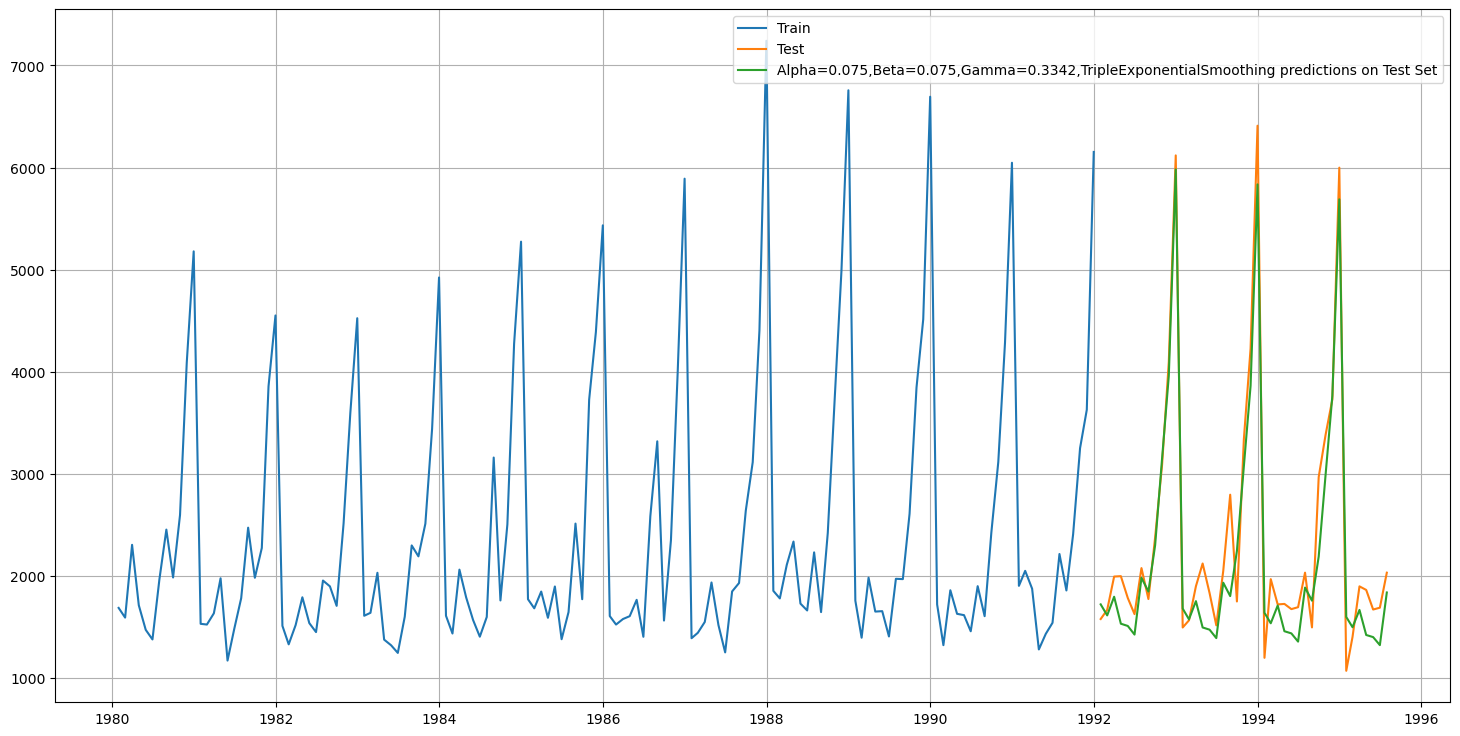

In [89]:
## let's plot and see how it fits:
plt.figure(figsize=(18,9))
plt.plot(TES_train['Sparkling'], label='Train')
plt.plot(TES_test['Sparkling'], label='Test')

plt.plot(TES_test['auto_predict'], label='Alpha=0.075,Beta=0.075,Gamma=0.3342,TripleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid();

#### observations
TES prams seem capturing the seasonlity, let's validate the model and compare the results

In [90]:
rmse_model_test6 = metrics.mean_squared_error(TES_test['Sparkling'],TES_test['auto_predict'],squared=False)
print("AlAlpha=0.075,Beta=0.075,Gamma=0.3342,TripleExponentialSmoothing predictions on Test Set,  RMSE is %3.3f" %(rmse_model_test6))


AlAlpha=0.075,Beta=0.075,Gamma=0.3342,TripleExponentialSmoothing predictions on Test Set,  RMSE is 347.022


In [91]:
## let's add the TES model results into the dataframe of other results
resultsDf_TES = pd.DataFrame({'Test RMSE': [rmse_model_test6]}
                           ,index=['For Alpha=0.075,Beta=0.075,Gamma=0.3342 TES Model'])

resultsDf = pd.concat([resultsDf, resultsDf_TES])
resultsDf

,Test RMSE
RegressionOnTime,1337.090220
Naive On Time Forecast,3979.914692
Simple Average Forecast,1268.683035
For Alpha = 0.05 SES Model,1307.534534
For Alpha = 0.3 SES Model,1900.058569
"For Alpha=0.688,Beta=0.00009,DES Model",1923.793446
"For Alpha=0.3,Beta=0.3,DES Model",13814.398308
"For Alpha=0.075,Beta=0.075,Gamma=0.3342 TES Model",347.021534


#### Observation
we observe that TES model with prams has the best results as in this stage compared to other models and shows the lowest RMSE

In [92]:
# let's try different values to Alpha, Beta, and Gamma
resultsDf_TES_a = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Gamma Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_TES_a

,Alpha Values,Beta Values,Gamma Values,Train RMSE,Test RMSE


In [93]:
for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        for k in np.arange(0.3,1.1,0.1):
            model_TES_alpha_i_j_k = model_TES.fit(smoothing_level=i,smoothing_trend=j,smoothing_seasonal=k,optimized=False,use_brute=True)
            TES_train['predict',i,j,k] = model_TES_alpha_i_j_k.fittedvalues
            TES_test['predict',i,j,k] = model_TES_alpha_i_j_k.forecast(steps=55)
        
            rmse_model_train = metrics.mean_squared_error(TES_train['Sparkling'],TES_train['predict',i,j,k],squared=False)
            
            rmse_model_test = metrics.mean_squared_error(TES_test['Sparkling'],TES_test['predict',i,j,k],squared=False)
            
        resultsDf_TES_a = resultsDf_TES_a.append({'Alpha Values':i,'Beta Values':j,'Gamma Values':k,
                                                  'Train RMSE':rmse_model_train,'Test RMSE':rmse_model_test}
                                                 , ignore_index=True)

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/679674219.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsDf_TES_a = resultsDf_TES_a.append({'Alpha Values':i,'Beta Values':j,'Gamma Values':k,
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/679674219.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsDf_TES_a = resultsDf_TES_a.append({'Alpha Values':i,'Beta Values':j,'Gamma Values':k,
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/679674219.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsDf_TES_a = resultsDf_TES_a.append({'Alpha Values':i,'Beta Values':j,'Gamma Values':k,
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/67967

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/679674219.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  TES_train['predict',i,j,k] = model_TES_alpha_i_j_k.fittedvalues
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/679674219.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  TES_test['predict',i,j,k] = model_TES_alpha_i_j_k.forecast(steps=55)
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/679674219.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usual

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/679674219.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  TES_test['predict',i,j,k] = model_TES_alpha_i_j_k.forecast(steps=55)
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/679674219.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  TES_train['predict',i,j,k] = model_TES_alpha_i_j_k.fittedvalues
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/679674219.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usual

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/679674219.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  TES_train['predict',i,j,k] = model_TES_alpha_i_j_k.fittedvalues
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/679674219.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  TES_test['predict',i,j,k] = model_TES_alpha_i_j_k.forecast(steps=55)
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/679674219.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usual

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/679674219.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  TES_test['predict',i,j,k] = model_TES_alpha_i_j_k.forecast(steps=55)
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/679674219.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  TES_train['predict',i,j,k] = model_TES_alpha_i_j_k.fittedvalues
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/679674219.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usual

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/679674219.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  TES_test['predict',i,j,k] = model_TES_alpha_i_j_k.forecast(steps=55)
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/679674219.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  TES_train['predict',i,j,k] = model_TES_alpha_i_j_k.fittedvalues
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/679674219.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usual

In [94]:
 resultsDf_TES_a.head()

,Alpha Values,Beta Values,Gamma Values,Train RMSE,Test RMSE
0,0.3,0.3,1.0,737.152560,3574.682518
1,0.3,0.4,1.0,1029.339351,26500.971684
2,0.3,0.5,1.0,933.579085,4518.896375
3,0.3,0.6,1.0,1939.141181,161379.149088
4,0.3,0.7,1.0,7614.795068,67981.836764


In [95]:
 resultsDf_TES_a.sort_values('Test RMSE').head()

,Alpha Values,Beta Values,Gamma Values,Train RMSE,Test RMSE
0,0.3,0.3,1.0,737.152560,3574.682518
2,0.3,0.5,1.0,933.579085,4518.896375
21,0.5,0.8,1.0,41856.384251,4808.950213
29,0.6,0.8,1.0,18323.791613,7557.263891
42,0.8,0.5,1.0,72505.598011,8094.727294


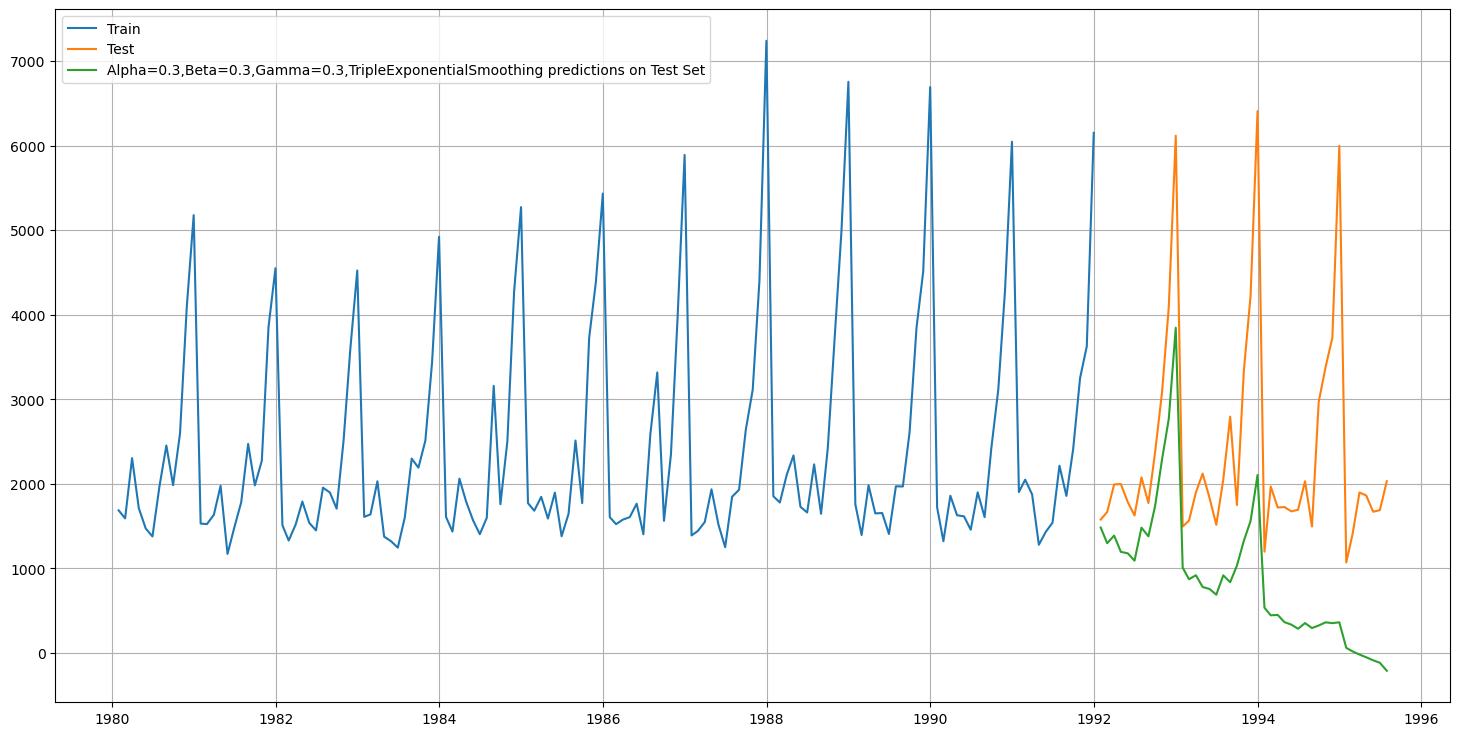

In [96]:
## let's plt the using following prams (Alpha = .3, Beta = .3, Gamma = .3)
plt.figure(figsize=(18,9))
plt.plot(TES_train['Sparkling'], label='Train')
plt.plot(TES_test['Sparkling'], label='Test')

#The value of alpha and beta is taken like that by python
plt.plot(TES_test['predict', 0.3, 0.3,0.3], label='Alpha=0.3,Beta=0.3,Gamma=0.3,TripleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid();

In [97]:
## let's validate the model

In [98]:
rmse_model_test7 = metrics.mean_squared_error(TES_test['Sparkling'],TES_test['predict', 0.3, 0.3,0.3],squared=False)
print("Alpha= 0.3,Beta=0.3,Gamma=0.3,TES Model,TripleExponentialSmoothing predictions on Test Set,  RMSE is %3.3f" %(rmse_model_test7))

Alpha= 0.3,Beta=0.3,Gamma=0.3,TES Model,TripleExponentialSmoothing predictions on Test Set,  RMSE is 1843.831


In [99]:
resultsDf_TES_A= pd.DataFrame({'Test RMSE':rmse_model_test7}
                           ,index=['For Alpha= 0.3,Beta=0.3,Gamma=0.3,TES Model'])


resultsDf = pd.concat([resultsDf, resultsDf_TES_A])
resultsDf

,Test RMSE
RegressionOnTime,1337.090220
Naive On Time Forecast,3979.914692
Simple Average Forecast,1268.683035
For Alpha = 0.05 SES Model,1307.534534
For Alpha = 0.3 SES Model,1900.058569
"For Alpha=0.688,Beta=0.00009,DES Model",1923.793446
"For Alpha=0.3,Beta=0.3,DES Model",13814.398308
"For Alpha=0.075,Beta=0.075,Gamma=0.3342 TES Model",347.021534
"For Alpha= 0.3,Beta=0.3,Gamma=0.3,TES Model",1843.830509


#### Observations
- we observe that using Alpha, Beta, Gamma at 0.3 did not improve the result as the pervious one.

In [100]:
## let's check other models as well such as ARIMA & SARIMA
# in this case let's test the stationarity of the data

In [101]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #determining roll statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    
    ##plot rolling Statistics:
    orig = plt.plot(timeseries,color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller Test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput,'\n')

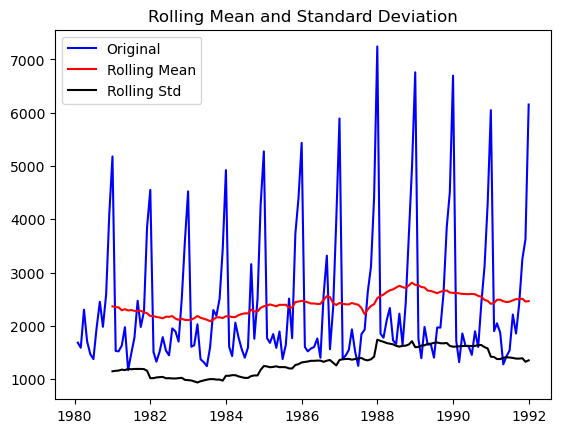

Results of Dickey Fuller Test:
Test Statistic                  -1.265771
p-value                          0.644683
#Lags Used                      12.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64 



In [102]:
test_stationarity(df_train['Sparkling'])

#### Observations
- as H0 : The series is not stationary 
- Ha: The series is Stationary 

looking to p-value, we failed to reject Null hypothesis since it is more that 0.05 and then the data is non stationary. additionally at 5% significant level the Time Series is non-stationary as well.

In [103]:
## Stationary data lets us build reliable forecasts by assuming we have repeating patterns.
## let's try to build on the training data as following
dftest = adfuller(df_train.diff().dropna(),regression='ct')
print('DF test statistics is %3.3f' %dftest[0])
print('DF test p-value is', dftest[1])
print('DF test p-value is', dftest[2])

DF test statistics is -8.628
DF test p-value is 2.5490597847958177e-12
DF test p-value is 11


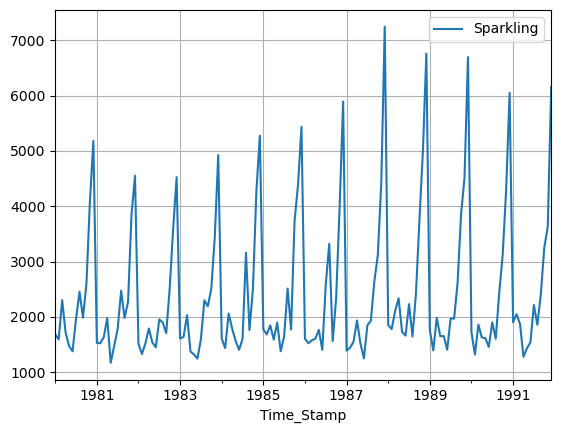

In [104]:
df_train.plot(grid=True);

### Model #7 - Automated ARIMA Model
##### ARIMA works with the params with lowest AIC on training data, then evaluate with RMSE on test data.

In [105]:
## let's identify pdq
import itertools
p = q = range(0,4)
d = range(1,2)
pdq = list(itertools.product(p,d,q))
print('Examples of the parameter combinations for the models')
for i in range(0,len(pdq)):
    print('Model : {}'.format(pdq[i]))

Examples of the parameter combinations for the models
Model : (0, 1, 0)
Model : (0, 1, 1)
Model : (0, 1, 2)
Model : (0, 1, 3)
Model : (1, 1, 0)
Model : (1, 1, 1)
Model : (1, 1, 2)
Model : (1, 1, 3)
Model : (2, 1, 0)
Model : (2, 1, 1)
Model : (2, 1, 2)
Model : (2, 1, 3)
Model : (3, 1, 0)
Model : (3, 1, 1)
Model : (3, 1, 2)
Model : (3, 1, 3)


In [106]:
# let's create an empty DataFrame to store the prams and AIC
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARIMA_AIC

,param,AIC


In [107]:
## let's build the model and append the params & AIC
from statsmodels.tsa.arima.model import ARIMA

for param in pdq: # running a loop within the pdq parameters defined by itertools
    ARIMA_model  =  ARIMA(df_train['Sparkling'].values, order=param).fit()
    print('ARIMA{} - AIC{}'.format(param, ARIMA_model.aic))
    
    #printing the parameters and the AIC from the fitted models
    ARIMA_AIC = ARIMA_AIC.append({'param': param, 'AIC': ARIMA_model.aic},ignore_index=True)
    
    #appending the AIC values and the model parameters to the previously created data frame
    #for easier understanding and sorting of the AIC values

ARIMA(0, 1, 0) - AIC2476.745546947
ARIMA(0, 1, 1) - AIC2470.90326541436
ARIMA(0, 1, 2) - AIC2439.4718189729174
ARIMA(0, 1, 3) - AIC2439.127183727969
ARIMA(1, 1, 0) - AIC2474.923642766008
ARIMA(1, 1, 1) - AIC2440.486112755901
ARIMA(1, 1, 2) - AIC2439.712391789759


/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/3470811296.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param': param, 'AIC': ARIMA_model.aic},ignore_index=True)
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/3470811296.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param': param, 'AIC': ARIMA_model.aic},ignore_index=True)
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/3470811296.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param': param, 'AIC': ARIMA_model.aic},ignore_index=True)
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/3470811296.py:9: 

ARIMA(1, 1, 3) - AIC2440.808627802614
ARIMA(2, 1, 0) - AIC2468.7139871180243
ARIMA(2, 1, 1) - AIC2438.8717349905737
ARIMA(2, 1, 2) - AIC2419.166998343935


/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/3470811296.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param': param, 'AIC': ARIMA_model.aic},ignore_index=True)
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/3470811296.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param': param, 'AIC': ARIMA_model.aic},ignore_index=True)
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/3470811296.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param': param, 'AIC': ARIMA_model.aic},ignore_index=True)
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/3470811296.py:9: 

ARIMA(2, 1, 3) - AIC2438.364959921283
ARIMA(3, 1, 0) - AIC2466.3465536939157


/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/3470811296.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param': param, 'AIC': ARIMA_model.aic},ignore_index=True)
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/3470811296.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param': param, 'AIC': ARIMA_model.aic},ignore_index=True)
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/3470811296.py:9: FutureWarning: The frame.append method is deprecated and will be 

ARIMA(3, 1, 1) - AIC2440.427770958855
ARIMA(3, 1, 2) - AIC2435.454760251594
ARIMA(3, 1, 3) - AIC2427.507783817512


/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/3470811296.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param': param, 'AIC': ARIMA_model.aic},ignore_index=True)


In [108]:
## let's sort the results in asc. order
ARIMA_AIC.sort_values(by='AIC',ascending=True).head()

,param,AIC
10,"(2, 1, 2)",2419.166998
15,"(3, 1, 3)",2427.507784
14,"(3, 1, 2)",2435.454760
11,"(2, 1, 3)",2438.364960
9,"(2, 1, 1)",2438.871735


In [109]:
#### let's pick param (2,1,2)
auto_ARIMA = ARIMA(df_train, order=(2,1,2))

results_auto_ARIMA = auto_ARIMA.fit()

print(results_auto_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:              Sparkling   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1204.583
Date:                Sun, 17 Mar 2024   AIC                           2419.167
Time:                        19:56:21   BIC                           2433.981
Sample:                    01-31-1980   HQIC                          2425.187
                         - 12-31-1991                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3214      0.043     30.410      0.000       1.236       1.407
ar.L2         -0.5501      0.062     -8.906      0.000      -0.671      -0.429
ma.L1         -1.9912      0.105    -18.931      0.0

/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


#### observations
- we observe that AIC is 2419 and BIC 2433 which no much difference of each others
-  in addtion, p-values are all signficant less than 0.05.  

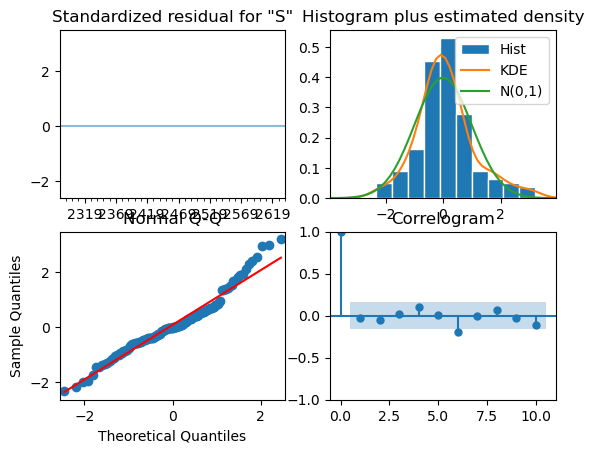

In [110]:
results_auto_ARIMA.plot_diagnostics();

#### Observation
- we observe that the Co.gram is normal dist. and resid are nearly around the line.

In [111]:
## now good to go and predict on the test data
predicted_auto_ARIMA = results_auto_ARIMA.forecast(steps=len(df_test))
predicted_auto_ARIMA.head()

1992-01-31    4263.657727
1992-02-29    2810.657901
1992-03-31    1929.951029
1992-04-30    1565.440721
1992-05-31    1568.223571
Freq: M, Name: predicted_mean, dtype: float64

In [112]:
## let's validate the model using Mape and RMSE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean((np.abs(y_true-y_pred))/(y_true))*100

## Importing the mean_squared_error function from sklearn to calculate the RMSE

from sklearn.metrics import mean_squared_error

## validate the model on test data
rmse = mean_squared_error(df_test['Sparkling'],predicted_auto_ARIMA,squared=False)
mape = mean_absolute_percentage_error(df_test['Sparkling'],predicted_auto_ARIMA)
print('RMSE:',rmse,'\nMAPE:',mape)

RMSE: 1309.6307309477766 
MAPE: 42.10606642538864


In [113]:
## let's corss check the results of RMSE
from math import sqrt
from sklearn.metrics import  mean_squared_error
rmse = sqrt(mean_squared_error(df_test.Sparkling,predicted_auto_ARIMA))
print(rmse)

1309.6307309477766


In [114]:
## let's create data frame to stor the results of both tests
resultsDf_ARIMA = pd.DataFrame({'RMSE': rmse,'MAPE':mape}
                           ,index=['ARIMA(2,1,2)'])

resultsDf_ARIMA

,RMSE,MAPE
"ARIMA(2,1,2)",1309.630731,42.106066


### Model #8 - Automated SARIMA Model
this model incorporates both regular and seasonal components. SARIMA as having two parts: a familiar ARIMA section (p, d, q) for capturing the general trend, and a seasonal section (P, D, Q, F) to account for those repeating ups and downs. The F indicates the seasonal cycle length (like months in a year). The best settings for all these parts (p, d, q) and (P, D, Q), we compare different options and pick the one with the lowest AIC value

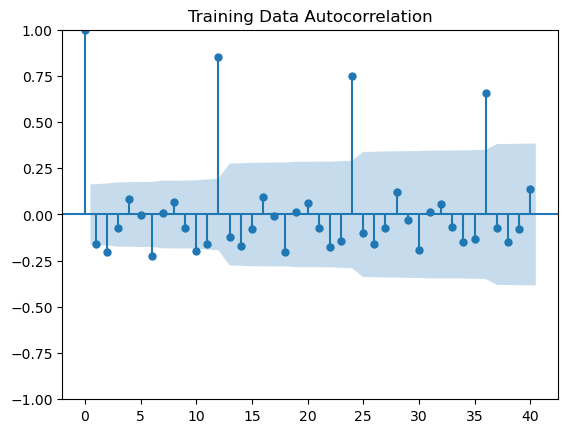

In [115]:
## let's plot the ACF on training
plot_acf(df_train.diff(),title='Training Data Autocorrelation',missing='drop',lags=40);

#### Observations 
- We see that there can be a seasonality of 6 as well as 12. 

In [116]:
## let's determine the params ranges a under:
import itertools
p = q = range(0, 4)
d= range(1,2)
D = range(0,1)
pdq = list(itertools.product(p, d, q))
PDQ = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, D, q))]
print('Examples of the parameter combinations for the Model are')
for i in range(1,len(pdq)):
    print('Model: {}{}'.format(pdq[i], PDQ[i]))

Examples of the parameter combinations for the Model are
Model: (0, 1, 1)(0, 0, 1, 12)
Model: (0, 1, 2)(0, 0, 2, 12)
Model: (0, 1, 3)(0, 0, 3, 12)
Model: (1, 1, 0)(1, 0, 0, 12)
Model: (1, 1, 1)(1, 0, 1, 12)
Model: (1, 1, 2)(1, 0, 2, 12)
Model: (1, 1, 3)(1, 0, 3, 12)
Model: (2, 1, 0)(2, 0, 0, 12)
Model: (2, 1, 1)(2, 0, 1, 12)
Model: (2, 1, 2)(2, 0, 2, 12)
Model: (2, 1, 3)(2, 0, 3, 12)
Model: (3, 1, 0)(3, 0, 0, 12)
Model: (3, 1, 1)(3, 0, 1, 12)
Model: (3, 1, 2)(3, 0, 2, 12)
Model: (3, 1, 3)(3, 0, 3, 12)


In [117]:
## let's create empty data frame to store param, seasonal, and AIC
SARIMA_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
SARIMA_AIC

,param,seasonal,AIC


In [118]:
import statsmodels.api as sm

for param in pdq:
    for param_seasonal in PDQ:
        SARIMA_model = sm.tsa.statespace.SARIMAX(df_train['Sparkling'].values,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMA = SARIMA_model.fit(maxiter=1000)
        print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
        SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.53626D+00    |proj g|=  1.00338D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      2      1     0     0   8.980D-06   8.536D+00
  F =   8.5362470716704433     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:2460.4391566410877
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable

 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   20    f=  6.64048D+00    |proj g|=  1.25489D-01

At iterate   25    f=  6.62268D+00    |proj g|=  2.80933D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     30      1     0     0   3.776D-06   6.623D+00
  F =   6.6226819896488074     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 0)x(0, 0, 2, 12) - AIC:1913.3324130188564
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92478D+01    |proj g|=  5.33882D-04


/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-7.215E+01  -gs= 7.287E-01 BFGS update SKIPPED
  ys=-4.391E+01  -gs= 7.242E-01 BFGS update SKIPPED
  ys=-3.019E+01  -gs= 7.190E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5     86      3     3     0   9.809D+03   1.698D+01
  F =   16.983780033796350     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(0, 1, 0)x(0, 0, 3, 12) - AIC:4899.328649733349
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.99902D+00    |proj g|=  3.06542D-05

           * * *
SARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:2019.717559589209

Tit   = total number of iterations
Tnf   = total number of function

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be remov


At iterate   15    f=  6.89290D+00    |proj g|=  2.17542D-01

At iterate   20    f=  6.88813D+00    |proj g|=  2.49326D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     29      1     0     0   2.280D-05   6.888D+00
  F =   6.8881200742114421     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:1989.7785813728954
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.29031D+00    |proj g|=  4.39256D-01

At iterate    

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-2.527E+01  -gs= 7.158E-01 BFGS update SKIPPED
  ys=-1.323E+02  -gs= 7.321E-01 BFGS update SKIPPED

At iterate    5    f=  1.22634D+01    |proj g|=  2.04405D+05
  ys=-1.335E+00  -gs= 5.200E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6     87      4     3     0   2.044D+05   1.226D+01
  F =   12.263367391653624     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(0, 1, 0)x(1, 0, 3, 12) - AIC:3541.8498087962435
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.33337D+00    |proj g|=  3.00653D-05


/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     13      1     0     0   3.003D-05   6.333D+00
  F =   6.3333690762078891     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 0)x(2, 0, 0, 12) - AIC:1830.010293947872
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.33026D+00    |proj g|=  1.48278D-02

At iterate    5    f=  6.32801D+00    |proj g|=  1.96242D-02

At iterate   10    f=  6.32800D+00    |proj g|=  3.16496D-04

At iterate   15

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68606D+01    |proj g|=  2.34706D-03
  ys=-5.511E+01  -gs= 7.265E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-4.656E-01  -gs= 3.596E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5    111      3     2     0   2.479D+05   1.165D+01
  F =   11.650565980353740     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(0, 1, 0)x(2, 0, 3, 12) - AIC:3367.363002341877
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70697D+00    |proj g|=  2.73180D-05


/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     16      1     0     0   2.732D-05   5.707D+00
  F =   5.7069696363684734     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 0)x(3, 0, 0, 12) - AIC:1651.6072552741205
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70679D+00    |proj g|=  1.26592D-02

At iterate    5    f=  5.70660D+00    |proj g|=  6.02047D-03


/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  5.70652D+00    |proj g|=  1.41995D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.420D-05   5.707D+00
  F =   5.7065166237782430     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 0)x(3, 0, 1, 12) - AIC:1653.476787648134
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.71693D+00    |proj g|=  2.97247D-01


/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  5.70647D+00    |proj g|=  1.89959D-02

At iterate   10    f=  5.70584D+00    |proj g|=  2.89361D-03

At iterate   15    f=  5.70578D+00    |proj g|=  3.08205D-04

At iterate   20    f=  5.70578D+00    |proj g|=  5.15122D-04

At iterate   25    f=  5.70556D+00    |proj g|=  4.00360D-02

At iterate   30    f=  5.70442D+00    |proj g|=  3.53581D-03

At iterate   35    f=  5.70442D+00    |proj g|=  2.12940D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     43      1     0     0   2.129D-05   5.704D+00
  F =   5.7044175970495274     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-2.627E+01  -gs= 7.165E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      3     65      2     1     0   8.820D+03   1.576D+01
  F =   15.757376735292253     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(0, 1, 0)x(3, 0, 3, 12) - AIC:4552.124499764169
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

SARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:2437.9469723862785
At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.45381D+00    |proj g|=  4.70315D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of functio

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':pa


At iterate   15    f=  7.49453D+00    |proj g|=  3.60579D-02

At iterate   20    f=  7.36567D+00    |proj g|=  1.96955D-01

At iterate   25    f=  7.35005D+00    |proj g|=  7.07279D-05

SARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:2122.815214759637
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     43      1     0     0   9.517D-06   7.350D+00
  F =   7.3500528290265175     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-4.999E+01  -gs= 7.188E-01 BFGS update SKIPPED
  ys=-2.914E+01  -gs= 7.118E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5    123      3     2     0   2.365D+05   1.291D+01
  F =   12.913323944019499     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(0, 1, 1)x(0, 0, 3, 12) - AIC:3729.0372958776156
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.46407D+00    |proj g|=  1.87827D-02

At iterate    5    f=  7.46137D+00    |proj g|=  5.84784D-04

At iterate   10    f=  7.46098D+00    |proj g|=  1.03248D-02

At iterate   1

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


SARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:1972.078873375493
At iterate   25    f=  6.82666D+00    |proj g|=  6.58580D-04


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     39      1     0     0   2.846D-06   6.827D+00
  F =   6.8266627547760175     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.34346D+00    |proj g|=  4.49161D-02

At iterate    5    f=  7.33227D+00    |proj g|=  1.28739D-02

At iterate   10

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.65596D+00    |proj g|=  6.75501D-02

At iterate   10    f=  6.65329D+00    |proj g|=  8.19622D-04

At iterate   15    f=  6.65325D+00    |proj g|=  2.02550D-03

At iterate   20    f=  6.64936D+00    |proj g|=  4.22836D-02

At iterate   25    f=  6.41548D+00    |proj g|=  3.04334D-01

At iterate   30    f=  6.15317D+00    |proj g|=  1.98976D-01

At iterate   35    f=  6.03973D+00    |proj g|=  2.59645D-02

At iterate   40    f=  6.03952D+00    |proj g|=  7.68120D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     53      1     0     0   6.627D-05   6.040D+00
  F =   6.03951588006

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-4.999E+01  -gs= 7.188E-01 BFGS update SKIPPED
  ys=-2.914E+01  -gs= 7.118E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5    123      3     2     0   2.354D+05   1.183D+01
  F =   11.834041081250870     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(0, 1, 1)x(1, 0, 3, 12) - AIC:3420.2038314002507
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77592D+00    |proj g|=  2.57045D-02

At iterate    5    f=  6.76622D+00    |proj g|=  1.56478D-03

At iterate   10    f=  6.76615D+00    |proj g|=  2.05154D-03

At iterate   1

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   15    f=  6.76504D+00    |proj g|=  6.30499D-03

At iterate   20    f=  6.75088D+00    |proj g|=  6.46006D-02

At iterate   25    f=  6.58745D+00    |proj g|=  2.52937D-01

At iterate   30    f=  6.20983D+00    |proj g|=  8.83382D-02

At iterate   35    f=  6.14249D+00    |proj g|=  4.54099D-02

At iterate   40    f=  6.14102D+00    |proj g|=  4.29052D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     57      1     0     0   8.479D-06   6.141D+00
  F =   6.1410208786424230     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 1)x(2, 0, 1, 12) - AIC:1778.6140130490

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.66227D+00    |proj g|=  4.20943D-02

At iterate    5    f=  6.65092D+00    |proj g|=  1.70194D-02

At iterate   10    f=  6.65073D+00    |proj g|=  1.05639D-03

At iterate   15    f=  6.65064D+00    |proj g|=  1.86294D-03

At iterate   20    f=  6.64562D+00    |proj g|=  3.40319D-02

At iterate   25    f=  6.52153D+00    |proj g|=  1.57110D-01

At iterate   30    f=  6.43396D+00    |proj g|=  3.25458D-01

At iterate   35    f=  6.09039D+00    |proj g|=  1.47168D-01

At iterate   40    f=  6.04892D+00    |proj g|=  3.31569D-02

At iterate   45    f=  6.04831D+00    |proj g|=  7.11213D-02

At iterate   50    f=  6.03974D+00    |proj g|=  3.21151D-02

At iterate   55    f=  6.03529D+00    |proj g|=  2.05603D-02

At iterate   60    f=  6.03497D+00    |proj g|=  5.28958D-05

           * * *

Tit   = 

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-4.999E+01  -gs= 7.188E-01 BFGS update SKIPPED
  ys=-2.914E+01  -gs= 7.118E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      5    123      3     2     0   2.364D+05   1.163D+01
  F =   11.629050325671949     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(0, 1, 1)x(2, 0, 3, 12) - AIC:3363.1664937935216
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.09380D+00    |proj g|=  2.54827D-02


/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.08419D+00    |proj g|=  4.29690D-03

At iterate   10    f=  6.08414D+00    |proj g|=  4.91316D-04

At iterate   15    f=  6.08365D+00    |proj g|=  1.29509D-02

At iterate   20    f=  6.02957D+00    |proj g|=  1.33320D-01

At iterate   25    f=  5.66416D+00    |proj g|=  2.67736D-01

At iterate   30    f=  5.55270D+00    |proj g|=  7.01459D-02

At iterate   35    f=  5.54446D+00    |proj g|=  2.94391D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     57      1     0     0   3.238D-05   5.544D+00
  F =   5.5444578396316837     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.08416D+00    |proj g|=  2.31313D-03

At iterate   10    f=  6.08410D+00    |proj g|=  9.85052D-04

At iterate   15    f=  6.08289D+00    |proj g|=  8.93795D-03

At iterate   20    f=  5.91432D+00    |proj g|=  3.04915D-01

At iterate   25    f=  5.57957D+00    |proj g|=  2.95408D-01

At iterate   30    f=  5.54320D+00    |proj g|=  8.67028D-03

At iterate   35    f=  5.54307D+00    |proj g|=  7.55997D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     54      1     0     0   1.475D-05   5.543D+00
  F =   5.5430743308622361     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.08829D+00    |proj g|=  4.64991D-02

At iterate   10    f=  6.08404D+00    |proj g|=  1.67370D-03

At iterate   15    f=  6.08397D+00    |proj g|=  1.01963D-03

At iterate   20    f=  6.08351D+00    |proj g|=  3.77849D-03

At iterate   25    f=  5.98946D+00    |proj g|=  2.07894D-01

At iterate   30    f=  5.69197D+00    |proj g|=  2.35369D-01

At iterate   35    f=  5.55894D+00    |proj g|=  5.12807D-02

At iterate   40    f=  5.54844D+00    |proj g|=  4.00745D-03

At iterate   45    f=  5.54774D+00    |proj g|=  3.07287D-02

At iterate   50    f=  5.54173D+00    |proj g|=  2.24140D-02

At iterate   55    f=  5.54031D+00    |proj g|=  6.59251D-03

At iterate   60    f=  5.53985D+00    |proj g|=  8.62740D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-4.999E+01  -gs= 7.188E-01 BFGS update SKIPPED
  ys=-2.914E+01  -gs= 7.118E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      5    123      3     2     0   2.355D+05   1.163D+01
  F =   11.634987485877893     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(0, 1, 1)x(3, 0, 3, 12) - AIC:3366.8763959328335
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.35549D+00    |proj g|=  1.08317D-01
SARIMA(0, 1, 2)x(0, 0, 0, 12) - AIC:2392.74369647859
At iterate    5    f=  8.28730D+00    |proj g|=  1.94333D-04


           * * *

Tit  

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.65575D+00    |proj g|=  2.38662D-02

At iterate   10    f=  6.65414D+00    |proj g|=  1.16468D-03

At iterate   15    f=  6.65411D+00    |proj g|=  3.59314D-03

At iterate   20    f=  6.65213D+00    |proj g|=  3.61158D-02

At iterate   25    f=  6.49187D+00    |proj g|=  1.94546D-01

At iterate   30    f=  6.38275D+00    |proj g|=  4.83761D-02

At iterate   35    f=  6.37905D+00    |proj g|=  8.79568D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     46      1     0     0   4.851D-05   6.379D+00
  F =   6.3790520557104085     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-1.055E+02  -gs= 7.173E-01 BFGS update SKIPPED
  ys=-3.153E+01  -gs= 7.064E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-4.731E+02  -gs= 7.212E-01 BFGS update SKIPPED


/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5     93      3     3     0   1.594D+05   1.508D+01
  F =   15.084763852117593     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(0, 1, 2)x(0, 0, 3, 12) - AIC:4356.411989409867
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.44874D+00    |proj g|=  2.81714D-02

At iterate    5    f=  7.44496D+00    |proj g|=  5.99194D-04

At iterate   10    f=  7.44372D+00    |proj g|=  2.41575D-02

At iterate   15

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   25    f=  7.00129D+00    |proj g|=  1.48722D+00

At iterate   30    f=  6.59841D+00    |proj g|=  3.71234D-01

At iterate   35    f=  6.56795D+00    |proj g|=  6.34036D-02

At iterate   40    f=  6.56713D+00    |proj g|=  2.34395D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     57      1     0     0   4.669D-06   6.567D+00
  F =   6.5671265852648197     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 2)x(1, 0, 1, 12) - AIC:1901.3324565562682
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   15    f=  6.58501D+00    |proj g|=  1.94953D-03

At iterate   20    f=  6.58428D+00    |proj g|=  3.45341D-02

At iterate   25    f=  6.53785D+00    |proj g|=  3.33094D-01

At iterate   30    f=  6.28718D+00    |proj g|=  3.23157D-01

At iterate   35    f=  5.99808D+00    |proj g|=  2.74846D-01

At iterate   40    f=  5.97933D+00    |proj g|=  1.32491D-02

At iterate   45    f=  5.97908D+00    |proj g|=  1.47165D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     57      1     0     0   1.472D-05   5.979D+00
  F =   5.9790810489381689     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-1.055E+02  -gs= 7.173E-01 BFGS update SKIPPED
  ys=-3.152E+01  -gs= 7.064E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-2.456E+02  -gs= 7.216E-01 BFGS update SKIPPED


/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      5     93      3     3     0   8.284D+04   1.388D+01
  F =   13.881874995248040     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(0, 1, 2)x(1, 0, 3, 12) - AIC:4011.9799986314356
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76024D+00    |proj g|=  2.82791D-02

At iterate    5    f=  6.75418D+00    |proj g|=  4.99334D-03

At iterate   10    f=  6.75376D+00    |proj g|=  5.56007D-04

At iterate   1

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   30    f=  6.13200D+00    |proj g|=  1.46383D-01

At iterate   35    f=  6.12913D+00    |proj g|=  9.72410D-03

At iterate   40    f=  6.12907D+00    |proj g|=  4.11125D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     55      1     0     0   4.111D-05   6.129D+00
  F =   6.1290726132117639     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 2)x(2, 0, 1, 12) - AIC:1777.172912604988
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  6.58275D+00    |proj g|=  1.36589D-03

At iterate   15    f=  6.58271D+00    |proj g|=  9.98526D-04

At iterate   20    f=  6.58257D+00    |proj g|=  3.31916D-03

At iterate   25    f=  6.54560D+00    |proj g|=  1.55818D-01

At iterate   30    f=  6.29383D+00    |proj g|=  1.17436D+00

At iterate   35    f=  5.99015D+00    |proj g|=  1.49312D-01

At iterate   40    f=  5.97739D+00    |proj g|=  2.06636D-02

At iterate   45    f=  5.97496D+00    |proj g|=  4.18861D-03

At iterate   50    f=  5.97387D+00    |proj g|=  4.02770D-03

At iterate   55    f=  5.97377D+00    |proj g|=  1.89766D-03

At iterate   60    f=  5.97377D+00    |proj g|=  2.88656D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-1.055E+02  -gs= 7.173E-01 BFGS update SKIPPED
  ys=-3.154E+01  -gs= 7.064E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  ys=-6.626E+02  -gs= 7.209E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      5     93      3     3     0   2.234D+05   1.392D+01
  F =   13.920881531038098     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(0, 1, 2)x(2, 0, 3, 12) - AIC:4025.2138809389726
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.07970D+00    |proj g|=  2.68092D-02

At iterate    5    f=  6.07402D+00    |proj g|=  6.37603D-03


/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  6.07347D+00    |proj g|=  1.61691D-03

At iterate   15    f=  6.07342D+00    |proj g|=  2.33737D-03

At iterate   20    f=  6.06980D+00    |proj g|=  2.29306D-02

At iterate   25    f=  5.84651D+00    |proj g|=  4.86966D-01

At iterate   30    f=  5.55638D+00    |proj g|=  1.94493D-01

At iterate   35    f=  5.52950D+00    |proj g|=  2.87318D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     53      1     0     0   7.319D-06   5.529D+00
  F =   5.5294943974788193     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 2)x(3, 0, 0, 12) - AIC:1604.4943864739

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.07414D+00    |proj g|=  6.37458D-03

At iterate   10    f=  6.07347D+00    |proj g|=  5.90383D-04

At iterate   15    f=  6.07341D+00    |proj g|=  1.81291D-03

At iterate   20    f=  6.07313D+00    |proj g|=  4.04467D-03

At iterate   25    f=  6.05309D+00    |proj g|=  1.16028D-01

At iterate   30    f=  5.66683D+00    |proj g|=  2.96875D-01

At iterate   35    f=  5.54388D+00    |proj g|=  8.49055D-02

At iterate   40    f=  5.52986D+00    |proj g|=  1.12935D-01

At iterate   45    f=  5.52899D+00    |proj g|=  1.38123D-03

At iterate   50    f=  5.52898D+00    |proj g|=  2.53019D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.07581D+00    |proj g|=  2.94064D-02

At iterate   10    f=  6.07354D+00    |proj g|=  1.34730D-02

At iterate   15    f=  6.07339D+00    |proj g|=  4.98871D-04

At iterate   20    f=  6.07328D+00    |proj g|=  4.51691D-03

At iterate   25    f=  6.07306D+00    |proj g|=  3.36369D-03

At iterate   30    f=  6.06835D+00    |proj g|=  2.55549D-02

At iterate   35    f=  5.92190D+00    |proj g|=  3.36432D-01

At iterate   40    f=  5.61461D+00    |proj g|=  1.64696D-01

At iterate   45    f=  5.53648D+00    |proj g|=  2.01956D-01

At iterate   50    f=  5.52952D+00    |proj g|=  2.10936D-02

At iterate   55    f=  5.52793D+00    |proj g|=  2.39478D-02

At iterate   60    f=  5.52773D+00    |proj g|=  1.54801D-03

At iterate   65    f=  5.52773D+00    |proj g|=  1.43403D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-1.055E+02  -gs= 7.173E-01 BFGS update SKIPPED
  ys=-3.152E+01  -gs= 7.064E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-2.115E+02  -gs= 7.217E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5     93      3     3     0   7.133D+04   1.366D+01
  F =   13.656220960185404     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


SARIMA(0, 1, 2)x(3, 0, 3, 12) - AIC:3950.9916365333966
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.24502D+00    |proj g|=  1.91283D-01

At iterate    5    f=  8.21811D+00    |proj g|=  3.41679D-02

At iterate   10    f=  8.21763D+00    |proj g|=  3.19505D-03
SARIMA(0, 1, 3)x(0, 0, 0, 12) - AIC:2374.677632869249

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   1.038D-04   8.218D+00
  F =   8.2176306696848922     

CONVERGENCE: REL_REDUC

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   25    f=  7.20687D+00    |proj g|=  4.01039D-01

At iterate   30    f=  7.16005D+00    |proj g|=  1.34090D-02

At iterate   35    f=  7.15986D+00    |proj g|=  8.53861D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     42      1     0     0   6.214D-06   7.160D+00
  F =   7.1598604635087355     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 3)x(0, 0, 1, 12) - AIC:2072.039813490516
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   15    f=  6.56901D+00    |proj g|=  2.76557D-03

At iterate   20    f=  6.56900D+00    |proj g|=  1.07673D-03

At iterate   25    f=  6.56899D+00    |proj g|=  4.11153D-03

At iterate   30    f=  6.56677D+00    |proj g|=  1.72657D-02

At iterate   35    f=  6.34511D+00    |proj g|=  2.19891D-01

At iterate   40    f=  6.32243D+00    |proj g|=  4.61046D-02

At iterate   45    f=  6.31929D+00    |proj g|=  1.99291D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     53      1     0     0   6.165D-05   6.319D+00
  F =   6.3192858625947865     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-1.139E+02  -gs= 7.108E-01 BFGS update SKIPPED
  ys=-3.033E+01  -gs= 6.992E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.44006D+01    |proj g|=  2.19174D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6    124      3     2     0   2.192D+04   1.440D+01
  F =   14.400597789021838     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(0, 1, 3)x(0, 0, 3, 12) - AIC:4161.372163238289
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.40840D+00    |proj g|=  1.83881D-02

At iterate    5    f=  7.40582D+00    |proj g|=  6.22064D-04

At iterate   10    f=  7.40562D+00    |proj g|=  3.71703D-03

At iterate   15

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   35    f=  6.54450D+00    |proj g|=  1.95816D-01

At iterate   40    f=  6.52001D+00    |proj g|=  9.39936D-02

At iterate   45    f=  6.51578D+00    |proj g|=  3.57925D-01

At iterate   50    f=  6.51155D+00    |proj g|=  7.00766D-03

At iterate   55    f=  6.51155D+00    |proj g|=  1.72134D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     56     74      1     0     0   2.720D-05   6.512D+00
  F =   6.5115453994673125     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 3)x(1, 0, 1, 12) - AIC:1887.325075046586
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  6.49262D+00    |proj g|=  1.17863D-03

At iterate   15    f=  6.49255D+00    |proj g|=  4.44939D-03

At iterate   20    f=  6.49165D+00    |proj g|=  3.62415D-02

At iterate   25    f=  6.43437D+00    |proj g|=  3.00459D-01

At iterate   30    f=  6.09601D+00    |proj g|=  1.05461D+00

At iterate   35    f=  5.93566D+00    |proj g|=  4.67487D-01

At iterate   40    f=  5.92427D+00    |proj g|=  3.76023D-02

At iterate   45    f=  5.92060D+00    |proj g|=  1.34621D-02

At iterate   50    f=  5.92056D+00    |proj g|=  3.23326D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     52     68   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72990D+01    |proj g|=  5.58128D-04
  ys=-1.139E+02  -gs= 7.108E-01 BFGS update SKIPPED
  ys=-3.034E+01  -gs= 6.992E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.33374D+01    |proj g|=  2.09680D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      6    124      3     2     0   2.097D+04   1.334D+01
  F =   13.337389140786293     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(0, 1, 3)x(1, 0, 3, 12) - AIC:3857.168072546452
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.72438D+00    |proj g|=  2.36809D-02

At iterate    5    f=  6.71712D+00    |proj g|=  1.41424D-03

At iterate   10    f=  6.71706D+00    |proj g|=  1.01255D-03

At iterate   15

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.71649D+00    |proj g|=  4.83388D-03

At iterate   10    f=  6.71631D+00    |proj g|=  5.94592D-04

At iterate   15    f=  6.71609D+00    |proj g|=  1.07699D-02

At iterate   20    f=  6.71430D+00    |proj g|=  1.64775D-02

At iterate   25    f=  6.62591D+00    |proj g|=  1.46629D-01

At iterate   30    f=  6.26577D+00    |proj g|=  3.06901D-01

At iterate   35    f=  6.13359D+00    |proj g|=  1.20414D-01

At iterate   40    f=  6.12645D+00    |proj g|=  5.05483D-02

At iterate   45    f=  6.12362D+00    |proj g|=  4.73022D-03

At iterate   50    f=  6.12355D+00    |proj g|=  8.66284D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  6.49056D+00    |proj g|=  5.92693D-04

At iterate   15    f=  6.49050D+00    |proj g|=  3.52566D-03

At iterate   20    f=  6.48940D+00    |proj g|=  1.04163D-02

At iterate   25    f=  6.48270D+00    |proj g|=  4.57085D-02

At iterate   30    f=  6.46368D+00    |proj g|=  7.45083D-02

At iterate   35    f=  6.28087D+00    |proj g|=  3.65386D-01

At iterate   40    f=  5.99382D+00    |proj g|=  3.49130D-01

At iterate   45    f=  5.91803D+00    |proj g|=  7.61471D-02

At iterate   50    f=  5.91651D+00    |proj g|=  2.93450D-03

At iterate   55    f=  5.91649D+00    |proj g|=  4.25638D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-1.139E+02  -gs= 7.108E-01 BFGS update SKIPPED
  ys=-3.034E+01  -gs= 6.992E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.31426D+01    |proj g|=  2.14772D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      6    124      3     2     0   2.148D+04   1.314D+01
  F =   13.142624922878650     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(0, 1, 3)x(2, 0, 3, 12) - AIC:3803.075977789051
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04792D+00    |proj g|=  2.44512D-02

At iterate    5    f=  6.04061D+00    |proj g|=  2.20149D-03

At iterate   10    f=  6.04053D+00    |proj g|=  6.36218D-04

At iterate   15

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.04055D+00    |proj g|=  2.41134D-03

At iterate   10    f=  6.04046D+00    |proj g|=  1.42361D-03

At iterate   15    f=  6.03940D+00    |proj g|=  4.82521D-03

At iterate   20    f=  6.03039D+00    |proj g|=  2.51436D-02

At iterate   25    f=  5.94868D+00    |proj g|=  5.85562D-02

At iterate   30    f=  5.56896D+00    |proj g|=  1.51447D-01

At iterate   35    f=  5.55340D+00    |proj g|=  2.88491D-02

At iterate   40    f=  5.55256D+00    |proj g|=  6.03767D-04

At iterate   45    f=  5.55256D+00    |proj g|=  1.40347D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     59   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.04312D+00    |proj g|=  3.83733D-02

At iterate   10    f=  6.04048D+00    |proj g|=  2.08350D-03

At iterate   15    f=  6.04039D+00    |proj g|=  5.19094D-04

At iterate   20    f=  6.04029D+00    |proj g|=  5.10004D-03

At iterate   25    f=  6.03931D+00    |proj g|=  5.83143D-03

At iterate   30    f=  6.02382D+00    |proj g|=  1.05054D-01

At iterate   35    f=  5.88976D+00    |proj g|=  1.38101D-01

At iterate   40    f=  5.56814D+00    |proj g|=  1.74358D-01

At iterate   45    f=  5.52362D+00    |proj g|=  4.89659D-02

At iterate   50    f=  5.52066D+00    |proj g|=  1.04025D-02

At iterate   55    f=  5.52049D+00    |proj g|=  3.54523D-03

At iterate   60    f=  5.52047D+00    |proj g|=  9.25928D-04

At iterate   65    f=  5.52047D+00    |proj g|=  3.64248D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71047D+01    |proj g|=  5.58127D-04
  ys=-1.139E+02  -gs= 7.108E-01 BFGS update SKIPPED
  ys=-3.036E+01  -gs= 6.992E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.31697D+01    |proj g|=  1.62481D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      6    124      3     2     0   1.625D+04   1.317D+01
  F =   13.169717712787035     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(0, 1, 3)x(3, 0, 3, 12) - AIC:3812.878701282666
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.52300D+00    |proj g|=  4.94698D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':pa

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.56397D+00    |proj g|=  5.87462D-02

At iterate    5    f=  7.56235D+00    |proj g|=  4.26906D-03

At iterate   10    f=  7.54961D+00    |proj g|=  8.85174D-02

At iterate   15    f=  7.45293D+00    |proj g|=  7.33317D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     25      1     0     0   1.797D-05   7.451D+00
  F =   7.4510884424167516     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-1.406E+02  -gs= 7.323E-01 BFGS update SKIPPED
  ys=-8.894E+01  -gs= 7.301E-01 BFGS update SKIPPED
  ys=-1.073E+02  -gs= 7.255E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5     89      3     3     0   3.067D+05   1.546D+01
  F =   15.463149968782622     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(1, 1, 0)x(0, 0, 3, 12) - AIC:4463.387191009395
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.41396D+00    |proj g|=  2.24097D-02

At iterate    5    f=  7.41204D+00    |proj g|=  1.76356D-03

At iterate   10    f=  7.40742D+00    |proj g|=  3.39372D-02

At iterate   15

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


SARIMA(1, 1, 0)x(1, 0, 0, 12) - AIC:1992.3915127682087
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.40793D+00    |proj g|=  4.27863D-02

At iterate    5    f=  7.40528D+00    |proj g|=  5.81010D-04

At iterate   10    f=  7.40524D+00    |proj g|=  2.48544D-03

At iterate   15    f=  7.40026D+00    |proj g|=  4.40827D-02

At iterate   20    f=  7.07872D+00    |proj g|=  2.28682D+00

At iterate   25    f=  6.86925D+00    |proj g|=  1.19382D+00

At iterate   30    f=  6.82342D+00    |proj g|=  1.30533D-01

At iterate   35    f=  6.82133D+00    |proj g|=  3.28595D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm 

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.72486D+00    |proj g|=  1.45195D-02

At iterate   10    f=  6.72473D+00    |proj g|=  5.22493D-04

At iterate   15    f=  6.72455D+00    |proj g|=  7.29887D-03

At iterate   20    f=  6.71105D+00    |proj g|=  5.93750D-02

At iterate   25    f=  6.45868D+00    |proj g|=  2.02891D-01

At iterate   30    f=  6.23866D+00    |proj g|=  7.10486D-01

At iterate   35    f=  6.21800D+00    |proj g|=  6.20508D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     50      1     0     0   1.625D-04   6.218D+00
  F =   6.2179984370409507     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-1.406E+02  -gs= 7.323E-01 BFGS update SKIPPED
  ys=-8.894E+01  -gs= 7.301E-01 BFGS update SKIPPED
  ys=-1.072E+02  -gs= 7.255E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5     89      3     3     0   3.065D+05   1.436D+01
  F =   14.363404577305269     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(1, 1, 0)x(1, 0, 3, 12) - AIC:4148.660518263918
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.72624D+00    |proj g


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  6.67336D+00    |proj g|=  2.34337D-01

At iterate   15    f=  6.23845D+00    |proj g|=  7.86885D-02

At iterate   20    f=  6.23420D+00    |proj g|=  5.11426D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     32      1     0     0   9.540D-07   6.234D+00
  F =   6.2342019872900396     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 1, 0)x(2, 0, 0, 12) - AIC:1803.4501723395315
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   25    f=  6.22077D+00    |proj g|=  1.77804D-02

At iterate   30    f=  6.22029D+00    |proj g|=  6.85337D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     42      1     0     0   4.563D-05   6.220D+00
  F =   6.2202920693117747     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 0)x(2, 0, 1, 12) - AIC:1801.444115961791
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.72575D+00    |proj g|=  4.10458D-02

At iterate    5

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   15    f=  6.72232D+00    |proj g|=  5.35148D-03

At iterate   20    f=  6.72002D+00    |proj g|=  1.00198D-02

At iterate   25    f=  6.63070D+00    |proj g|=  1.52502D-01

At iterate   30    f=  6.27050D+00    |proj g|=  2.24244D-02

At iterate   35    f=  6.21249D+00    |proj g|=  1.76554D-02

At iterate   40    f=  6.21226D+00    |proj g|=  5.97069D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     54      1     0     0   1.148D-04   6.212D+00
  F =   6.2122585550456355     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 0)x(2, 0, 2, 12) - AIC:1801.1304638531

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-1.406E+02  -gs= 7.323E-01 BFGS update SKIPPED
  ys=-8.894E+01  -gs= 7.301E-01 BFGS update SKIPPED
  ys=-1.072E+02  -gs= 7.255E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      5     89      3     3     0   3.065D+05   1.417D+01
  F =   14.165972698521934     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(1, 1, 0)x(2, 0, 3, 12) - AIC:4093.800137174317
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04374D+00    |proj g|=  1.90420D-02


/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.04178D+00    |proj g|=  4.67098D-04

At iterate   10    f=  6.04038D+00    |proj g|=  9.90415D-03

At iterate   15    f=  5.92960D+00    |proj g|=  1.50319D-01

At iterate   20    f=  5.63590D+00    |proj g|=  1.19928D-01

At iterate   25    f=  5.60945D+00    |proj g|=  2.29318D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     34      1     0     0   7.541D-05   5.609D+00
  F =   5.6094528502430530     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 0)x(3, 0, 0, 12) - AIC:1625.5224208699992
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.04174D+00    |proj g|=  4.67160D-04

At iterate   10    f=  6.04161D+00    |proj g|=  1.53649D-03

At iterate   15    f=  6.02938D+00    |proj g|=  1.79977D-02

At iterate   20    f=  5.70738D+00    |proj g|=  5.72199D-01

At iterate   25    f=  5.60926D+00    |proj g|=  2.48234D-02

At iterate   30    f=  5.60908D+00    |proj g|=  7.53044D-04

At iterate   35    f=  5.60908D+00    |proj g|=  3.06576D-04

At iterate   40    f=  5.60908D+00    |proj g|=  7.98988D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     51      1     0     0   7.990D-06   5.609D+00
  F =   5.60908045454

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.04270D+00    |proj g|=  1.87814D-02

At iterate   10    f=  6.04180D+00    |proj g|=  4.90408D-03

At iterate   15    f=  6.04168D+00    |proj g|=  5.81841D-04

At iterate   20    f=  6.04162D+00    |proj g|=  1.36931D-03

At iterate   25    f=  6.04140D+00    |proj g|=  8.17504D-03

At iterate   30    f=  6.02840D+00    |proj g|=  2.29940D-01

At iterate   35    f=  5.67380D+00    |proj g|=  2.77418D-01

At iterate   40    f=  5.62844D+00    |proj g|=  1.76632D-02

At iterate   45    f=  5.61260D+00    |proj g|=  5.97212D-02

At iterate   50    f=  5.60795D+00    |proj g|=  2.37420D-02

At iterate   55    f=  5.60768D+00    |proj g|=  4.12549D-03

At iterate   60    f=  5.60753D+00    |proj g|=  4.23793D-03

At iterate   65    f=  5.60753D+00    |proj g|=  1.82075D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-1.406E+02  -gs= 7.323E-01 BFGS update SKIPPED
  ys=-8.894E+01  -gs= 7.301E-01 BFGS update SKIPPED
  ys=-1.073E+02  -gs= 7.255E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipy


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      5     89      3     3     0   3.067D+05   1.416D+01
  F =   14.163379718282016     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(1, 1, 0)x(3, 0, 3, 12) - AIC:4095.0533588652206
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.39139D+00    |proj g|=  2.81734D-01

At iterate    5    f=  8.34753D+00    |proj g|=  1.40918D-04

SARIMA(1, 1, 1)x(0, 0, 0, 12) - AIC:2410.088462727542
           * * *

Tit 

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.71328D+00    |proj g|=  7.14691D-02

At iterate   10    f=  6.70891D+00    |proj g|=  7.79958D-03

At iterate   15    f=  6.70884D+00    |proj g|=  1.53011D-03

At iterate   20    f=  6.70856D+00    |proj g|=  2.85547D-02

At iterate   25    f=  6.64157D+00    |proj g|=  1.46894D-01

At iterate   30    f=  6.56890D+00    |proj g|=  1.30577D-02

At iterate   35    f=  6.46697D+00    |proj g|=  2.67068D-01

At iterate   40    f=  6.43798D+00    |proj g|=  1.81995D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     69      1     0     0   1.467D-05   6.438D+00
  F =   6.43797737239

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89468D+01    |proj g|=  5.47293D-04
  ys=-2.836E+01  -gs= 7.113E-01 BFGS update SKIPPED
  ys=-7.583E+01  -gs= 7.223E-01 BFGS update SKIPPED

At iterate    5    f=  1.36198D+01    |proj g|=  1.75496D+05
  ys=-4.409E+00  -gs= 6.071E-01 BFGS update SKIPPED
  ys=-4.959E-01  -gs= 1.736E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7    109      4     4     0   6.767D+05   8.538D+00
  F =   8.5384860023563363     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(1, 1, 1)x(0, 0, 3, 12) - AIC:2471.083968678625
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.39141D+00    |proj g|=  1.19402D-01

At iterate    5    f=  7.37517D+00    |proj g|=  2.38474D-03

At iterate   10    f=  7.37512D+00    |proj g|=  1.68210D-03

At iterate   15

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   25    f=  6.74504D+00    |proj g|=  9.55497D-02

At iterate   30    f=  6.74241D+00    |proj g|=  1.71947D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     39      1     0     0   2.865D-05   6.742D+00
  F =   6.7424054279427121     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:1949.8127632475012
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.33199D+00    |proj g|=  1.56302D-01

At iterate    

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.65369D+00    |proj g|=  1.55624D-01

At iterate    5    f=  6.63767D+00    |proj g|=  2.34549D-02

At iterate   10    f=  6.63525D+00    |proj g|=  6.01169D-04

At iterate   15    f=  6.63518D+00    |proj g|=  4.17365D-03

At iterate   20    f=  6.62532D+00    |proj g|=  6.05270D-02

At iterate   25    f=  6.17891D+00    |proj g|=  4.00472D-01

At iterate   30    f=  6.03401D+00    |proj g|=  2.12146D-02

At iterate   35    f=  6.03095D+00    |proj g|=  1.14861D-02

At iterate   40    f=  6.03094D+00    |proj g|=  4.51323D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-2.836E+01  -gs= 7.113E-01 BFGS update SKIPPED
  ys=-7.583E+01  -gs= 7.223E-01 BFGS update SKIPPED

At iterate    5    f=  1.31876D+01    |proj g|=  8.24984D+04
  ys=-3.732E+00  -gs= 6.978E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6     89      4     3     0   8.250D+04   1.319D+01
  F =   13.187621042665031     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(1, 1, 1)x(1, 0, 3, 12) - AIC:3812.0348602875288
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.70561D+00    |proj g|=  1.21136D-01

At iterate    5    f=  6.69093D+00    |proj g|=  1.62779D-02

At iterate   10    f=  6.69055D+00    |proj g|=  8.89072D-04

At iterate   1

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   25    f=  6.55493D+00    |proj g|=  3.95454D-01

At iterate   30    f=  6.34894D+00    |proj g|=  4.37119D-01

At iterate   35    f=  6.29127D+00    |proj g|=  7.61176D-02

At iterate   40    f=  6.28324D+00    |proj g|=  1.61189D-02

At iterate   45    f=  6.28307D+00    |proj g|=  1.59621D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     62      1     0     0   2.999D-05   6.283D+00
  F =   6.2830712164008045     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 1)x(2, 0, 1, 12) - AIC:1821.5245103234317
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.63510D+00    |proj g|=  2.04813D-02

At iterate   10    f=  6.63274D+00    |proj g|=  1.33800D-03

At iterate   15    f=  6.63248D+00    |proj g|=  7.38112D-03

At iterate   20    f=  6.59605D+00    |proj g|=  2.62934D-01

At iterate   25    f=  6.12296D+00    |proj g|=  1.01296D+00

At iterate   30    f=  6.02965D+00    |proj g|=  4.52559D-02

At iterate   35    f=  6.02662D+00    |proj g|=  9.81939D-03

At iterate   40    f=  6.02656D+00    |proj g|=  1.97751D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     52      1     0     0   8.730D-05   6.027D+00
  F =   6.02656405242

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-2.836E+01  -gs= 7.113E-01 BFGS update SKIPPED
  ys=-7.583E+01  -gs= 7.223E-01 BFGS update SKIPPED

At iterate    5    f=  1.15297D+01    |proj g|=  2.46686D+05
  ys=-2.145E+00  -gs= 5.283E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      6     94      4     3     0   2.467D+05   1.153D+01
  F =   11.529698757828156     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(1, 1, 1)x(2, 0, 3, 12) - AIC:3336.553242254509
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.02580D+00    |proj g|=  1.21710D-01


/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.01179D+00    |proj g|=  1.69334D-02

At iterate   10    f=  6.01129D+00    |proj g|=  1.09995D-03

At iterate   15    f=  6.01115D+00    |proj g|=  6.42216D-03

At iterate   20    f=  5.99541D+00    |proj g|=  3.08323D-02

At iterate   25    f=  5.54588D+00    |proj g|=  3.81305D-01

At iterate   30    f=  5.48533D+00    |proj g|=  1.84394D-02

At iterate   35    f=  5.48476D+00    |proj g|=  9.97195D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     46      1     0     0   4.436D-05   5.485D+00
  F =   5.4847613995203952     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.02597D+00    |proj g|=  1.23990D-01

At iterate    5    f=  6.01181D+00    |proj g|=  1.64599D-02

At iterate   10    f=  6.01128D+00    |proj g|=  4.96694D-04

At iterate   15    f=  6.01121D+00    |proj g|=  1.00806D-03

At iterate   20    f=  6.01042D+00    |proj g|=  7.15743D-03

At iterate   25    f=  5.94801D+00    |proj g|=  2.84364D-01

At iterate   30    f=  5.63394D+00    |proj g|=  1.13790D+00

At iterate   35    f=  5.50062D+00    |proj g|=  8.91430D-02

At iterate   40    f=  5.49350D+00    |proj g|=  5.96877D-02

At iterate   45    f=  5.48856D+00    |proj g|=  2.22093D-02

At iterate   50    f=  5.48641D+00    |proj g|=  4.47892D-02

At iterate   55    f=  5.48541D+00    |proj g|=  8.07065D-03

At iterate   60    f=  5.48485D+00    |proj g|=  3.25100D-03

At iterate   65    f=  5.48452D+00    |proj g|=  6.14

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.01527D+00    |proj g|=  3.35420D-02

At iterate   10    f=  6.01128D+00    |proj g|=  2.58730D-03

At iterate   15    f=  6.01118D+00    |proj g|=  1.09717D-03

At iterate   20    f=  6.01113D+00    |proj g|=  3.70076D-03

At iterate   25    f=  6.00963D+00    |proj g|=  1.08015D-02

At iterate   30    f=  6.00615D+00    |proj g|=  8.88802D-03

At iterate   35    f=  5.93489D+00    |proj g|=  1.50516D-01

At iterate   40    f=  5.73988D+00    |proj g|=  2.73699D-01

At iterate   45    f=  5.54807D+00    |proj g|=  5.53833D-02

At iterate   50    f=  5.54661D+00    |proj g|=  3.18250D-01

At iterate   55    f=  5.52755D+00    |proj g|=  1.77680D-01

At iterate   60    f=  5.51221D+00    |proj g|=  4.44124D-02

At iterate   65    f=  5.50340D+00    |proj g|=  1.97162D-02

At iterate   70    f=  5.50063D+00    |proj g|=  1.59229D-02

At iterate   75    f=  5.49696D+00    |proj g|=  1.29705D-02

At iterate   80    f=  5.49515D+00    |proj g|=  4.50393D-02

At iter

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-2.836E+01  -gs= 7.113E-01 BFGS update SKIPPED
  ys=-7.583E+01  -gs= 7.223E-01 BFGS update SKIPPED

At iterate    5    f=  1.25235D+01    |proj g|=  1.39438D+05
  ys=-2.165E+00  -gs= 6.244E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      6     89      4     3     0   1.394D+05   1.252D+01
  F =   12.523519024317453     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(1, 1, 1)x(3, 0, 3, 12) - AIC:3624.7734790034265
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34993D+00    |proj g|=  1.41354D-01

At iterate    5    f=  8.28381D+00    |proj g|=  1.25078D-02

At iterate   10    f=  8.28370D+00    |proj g|=  3.44096D-04

At iterate   1

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75399D+00    |proj g|=  3.25725D-01

At iterate    5    f=  6.65643D+00    |proj g|=  3.15378D-02

At iterate   10    f=  6.65390D+00    |proj g|=  1.33257D-03

At iterate   15    f=  6.65385D+00    |proj g|=  3.31153D-03

At iterate   20    f=  6.65383D+00    |proj g|=  1.35864D-03

At iterate   25    f=  6.65349D+00    |proj g|=  2.22798D-02

At iterate   30    f=  6.64262D+00    |proj g|=  1.32607D-01

At iterate   35    f=  6.49013D+00    |proj g|=  3.70263D-01

At iterate   40    f=  6.42309D+00    |proj g|=  1.45521D-01

At iterate   45    f=  6.37345D+00    |proj g|=  3.32416D-02

At iterate   50    f=  6.36964D+00    |proj g|=  2.33231D-03

At iterate   55    f=  6.36962D+00    |proj g|=  5.19243D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped


/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  1.46682D+01    |proj g|=  1.74243D+03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      7     85      2     0     0   4.714D+02   1.466D+01
  F =   14.657142981266905     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(1, 1, 2)x(0, 0, 3, 12) - AIC:4235.257178604868
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.38989D+00    |proj g|=  3.55895D-02

At iterate    5    f=  7.38339D+00    |proj g|=  1.70448D-03

At iterate   10    f=  7.38251D+00    |proj g|=  8.75244D-03

At iterate   15

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   35    f=  6.63742D+00    |proj g|=  4.79433D-01

At iterate   40    f=  6.57243D+00    |proj g|=  9.96430D-02

At iterate   45    f=  6.56766D+00    |proj g|=  1.32892D-02

At iterate   50    f=  6.56628D+00    |proj g|=  1.94802D-01

At iterate   55    f=  6.55882D+00    |proj g|=  8.98114D-02

At iterate   60    f=  6.55849D+00    |proj g|=  5.27941D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     61     88      1     0     0   2.254D-06   6.558D+00
  F =   6.5584861379559429     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 1, 2)x(1, 0, 1, 12) - AIC:1900.8440077313

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  6.58421D+00    |proj g|=  2.69678D-03

At iterate   15    f=  6.58332D+00    |proj g|=  2.06578D-03

At iterate   20    f=  6.58325D+00    |proj g|=  1.70143D-03

At iterate   25    f=  6.57943D+00    |proj g|=  3.14028D-02

At iterate   30    f=  6.38481D+00    |proj g|=  6.22672D-01

At iterate   35    f=  6.00010D+00    |proj g|=  2.51850D-01

At iterate   40    f=  5.96581D+00    |proj g|=  2.20874D-02

At iterate   45    f=  5.96540D+00    |proj g|=  6.39726D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     59      1     0     0   1.739D-04   5.965D+00
  F =   5.96539844478

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  1.35518D+01    |proj g|=  5.63289D+03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      6     83      2     0     0   5.633D+03   1.355D+01
  F =   13.551753285777693     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(1, 1, 2)x(1, 0, 3, 12) - AIC:3918.9049463039755
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.70342D+00    |proj g|=  3.05076D-02

At iterate    5    f=  6.69629D+00    |proj g|=  2.43343D-03

At iterate   10    f=  6.69570D+00    |proj g|=  1.24281D-02

At iterate   1

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   20    f=  6.69435D+00    |proj g|=  1.71429D-02

At iterate   25    f=  6.68665D+00    |proj g|=  5.36244D-02

At iterate   30    f=  6.65258D+00    |proj g|=  9.80749D-02

At iterate   35    f=  6.30878D+00    |proj g|=  2.26803D+00

At iterate   40    f=  6.09962D+00    |proj g|=  2.04683D-01

At iterate   45    f=  6.08715D+00    |proj g|=  1.07627D-01

At iterate   50    f=  6.07178D+00    |proj g|=  2.46031D-01

At iterate   55    f=  6.06943D+00    |proj g|=  3.73921D-03

At iterate   60    f=  6.06915D+00    |proj g|=  2.51179D-02

At iterate   65    f=  6.06886D+00    |proj g|=  8.38129D-03

At iterate   70    f=  6.06884D+00    |proj g|=  2.14542D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  6.58142D+00    |proj g|=  4.54036D-03

At iterate   15    f=  6.58094D+00    |proj g|=  1.14361D-03

At iterate   20    f=  6.58088D+00    |proj g|=  1.25119D-03

At iterate   25    f=  6.57389D+00    |proj g|=  3.24196D-02

At iterate   30    f=  6.50717D+00    |proj g|=  2.19970D-01

At iterate   35    f=  6.36747D+00    |proj g|=  5.06666D-01

At iterate   40    f=  6.01052D+00    |proj g|=  2.20998D-01

At iterate   45    f=  5.96577D+00    |proj g|=  6.71858D-02

At iterate   50    f=  5.96162D+00    |proj g|=  1.92276D-03

At iterate   55    f=  5.96162D+00    |proj g|=  6.54171D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74049D+01    |proj g|=  5.37220D-04

At iterate    5    f=  1.23953D+01    |proj g|=  1.39418D+05
  ys=-6.155E+00  -gs= 6.731E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      6     85      2     1     0   1.394D+05   1.240D+01
  F =   12.395336161496829     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(1, 1, 2)x(2, 0, 3, 12) - AIC:3587.8568145110867
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.02310D+00    |proj g|=  2.81924D-02

At iterate    5    f=  6.01644D+00    |proj g|=  3.13465D-03

At iterate   10    f=  6.01572D+00    |proj g|=  3.98540D-03

At iterate   1

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.01644D+00    |proj g|=  2.81670D-03

At iterate   10    f=  6.01604D+00    |proj g|=  4.11261D-03

At iterate   15    f=  6.01526D+00    |proj g|=  3.39192D-03

At iterate   20    f=  6.01519D+00    |proj g|=  1.22568D-03

At iterate   25    f=  6.01514D+00    |proj g|=  1.67044D-03

At iterate   30    f=  6.01124D+00    |proj g|=  1.35055D-02

At iterate   35    f=  5.97836D+00    |proj g|=  7.02645D-02

At iterate   40    f=  5.94841D+00    |proj g|=  1.11422D-01

At iterate   45    f=  5.76675D+00    |proj g|=  4.77997D-01

At iterate   50    f=  5.48667D+00    |proj g|=  1.11960D-01

At iterate   55    f=  5.47923D+00    |proj g|=  4.80080D-02

At iterate   60    f=  5.47279D+00    |proj g|=  7.38546D-02

At iterate   65    f=  5.47021D+00    |proj g|=  1.09310D-02

At iterate   70    f=  5.46926D+00    |proj g|=  1.57126D-02

At iterate   75    f=  5.46924D+00    |proj g|=  2.32767D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  6.01636D+00    |proj g|=  6.16771D-03

At iterate   15    f=  6.01583D+00    |proj g|=  2.95482D-03

At iterate   20    f=  6.01524D+00    |proj g|=  3.10704D-03

At iterate   25    f=  6.01518D+00    |proj g|=  6.93032D-04

At iterate   30    f=  6.01447D+00    |proj g|=  1.21813D-02

At iterate   35    f=  6.00767D+00    |proj g|=  2.89952D-02

At iterate   40    f=  5.94676D+00    |proj g|=  1.07866D-01

At iterate   45    f=  5.60131D+00    |proj g|=  1.35685D-01

At iterate   50    f=  5.48620D+00    |proj g|=  2.51490D-01

At iterate   55    f=  5.47027D+00    |proj g|=  4.08488D-02

At iterate   60    f=  5.46879D+00    |proj g|=  8.00805D-03

At iterate   65    f=  5.46857D+00    |proj g|=  1.10915D-02

At iterate   70    f=  5.46854D+00    |proj g|=  9.32063D-04

At iterate   75    f=  5.46853D+00    |proj g|=  6.21130D-04

At iterate   80    f=  5.46853D+00    |proj g|=  1.99921D-04

At iterate   85    f=  5.46853D+00    |proj g|=  1.24850D-04

       

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  1.21557D+01    |proj g|=  1.66006D+05
  ys=-7.452E+00  -gs= 6.685E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      6     85      2     1     0   1.660D+05   1.216D+01
  F =   12.155698094755778     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


SARIMA(1, 1, 2)x(3, 0, 3, 12) - AIC:3520.841051289664
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.24884D+00    |proj g|=  1.69358D-01

At iterate    5    f=  8.21696D+00    |proj g|=  1.14265D-02

At iterate   10    f=  8.21687D+00    |proj g|=  4.29996D-03

At iterate   15    f=  8.21685D+00    |proj g|=  3.28605D-04

At iterate   20    f=  8.21684D+00    |proj g|=  4.20887D-03

At iterate   25    f=  8.21600D+00    |proj g|=  6.89235D-02

At iterate   30    f=  8.21200D+00    |proj g|=  5.15609D-03

At iterate   35    f=  8.21175D+00    |proj g|=  3.86040D-03
SARIMA(1, 1, 3)x(0, 0, 0, 12) - AIC:2374.9830777495367

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active 

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   15    f=  7.30482D+00    |proj g|=  3.94883D-03

At iterate   20    f=  7.30479D+00    |proj g|=  4.33987D-04

At iterate   25    f=  7.30452D+00    |proj g|=  1.31111D-02

At iterate   30    f=  7.29044D+00    |proj g|=  1.28033D-01

At iterate   35    f=  7.23593D+00    |proj g|=  1.93057D+00

At iterate   40    f=  7.17498D+00    |proj g|=  6.13480D-01

At iterate   45    f=  7.15903D+00    |proj g|=  2.92220D-01

At iterate   50    f=  7.15430D+00    |proj g|=  2.64911D-01

At iterate   55    f=  7.14980D+00    |proj g|=  2.71872D-01

At iterate   60    f=  7.14973D+00    |proj g|=  3.61326D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.56847D+00    |proj g|=  1.44151D-02

At iterate   10    f=  6.56804D+00    |proj g|=  1.34775D-03

At iterate   15    f=  6.56793D+00    |proj g|=  3.76548D-03

At iterate   20    f=  6.56785D+00    |proj g|=  4.54092D-04

At iterate   25    f=  6.56760D+00    |proj g|=  7.65436D-03

At iterate   30    f=  6.53972D+00    |proj g|=  9.68217D-02

At iterate   35    f=  6.37129D+00    |proj g|=  1.44257D-01

At iterate   40    f=  6.32109D+00    |proj g|=  9.11585D-02

At iterate   45    f=  6.31233D+00    |proj g|=  1.66392D-02

At iterate   50    f=  6.31067D+00    |proj g|=  6.42843D-03

At iterate   55    f=  6.31064D+00    |proj g|=  4.67114D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83672D+01    |proj g|=  5.58481D-04
  ys=-9.101E+01  -gs= 7.097E-01 BFGS update SKIPPED
  ys=-3.685E+01  -gs= 7.019E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.20480D+01    |proj g|=  2.97759D+05
  ys=-1.006E+01  -gs= 6.286E-01 BFGS update SKIPPED
  ys=-1.824E-02  -gs= 6.013E-02 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      7    141      3     4     0   3.881D+05   1.113D+01
  F =   11.130570788932680     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(1, 1, 3)x(0, 0, 3, 12) - AIC:3221.604387212612
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.34943D+00    |proj g|=  2.88561D-02

At iterate    5    f=  7.34475D+00    |proj g|=  1.22481D-03

At iterate   10    f=  7.34265D+00    |proj g|=  4.54091D-03

At iterate   15

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  7.16605D+00    |proj g|=  7.43958D-03

At iterate   10    f=  7.16570D+00    |proj g|=  1.63810D-03

At iterate   15    f=  7.16547D+00    |proj g|=  2.81752D-03

At iterate   20    f=  7.16511D+00    |proj g|=  6.82324D-03

At iterate   25    f=  7.14764D+00    |proj g|=  1.68830D-01

At iterate   30    f=  6.79771D+00    |proj g|=  7.76575D-01

At iterate   35    f=  6.51827D+00    |proj g|=  8.53779D-02

At iterate   40    f=  6.51075D+00    |proj g|=  9.53670D-03

At iterate   45    f=  6.51018D+00    |proj g|=  1.83991D-02

At iterate   50    f=  6.50992D+00    |proj g|=  2.88191D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.49240D+00    |proj g|=  7.95419D-03

At iterate   10    f=  6.49171D+00    |proj g|=  6.33111D-04

At iterate   15    f=  6.49154D+00    |proj g|=  4.74510D-03

At iterate   20    f=  6.49146D+00    |proj g|=  1.30195D-03

At iterate   25    f=  6.49020D+00    |proj g|=  8.57629D-03

At iterate   30    f=  6.45506D+00    |proj g|=  7.79253D-02

At iterate   35    f=  6.42326D+00    |proj g|=  1.21185D-01

At iterate   40    f=  6.37369D+00    |proj g|=  5.63863D-01

At iterate   45    f=  6.36787D+00    |proj g|=  2.13797D-01

At iterate   50    f=  6.30588D+00    |proj g|=  9.27810D-01

At iterate   55    f=  6.27255D+00    |proj g|=  2.16922D-01

At iterate   60    f=  6.13393D+00    |proj g|=  1.30354D+00

At iterate   65    f=  5.95983D+00    |proj g|=  2.44008D-01

At iterate   70    f=  5.92684D+00    |proj g|=  9.59484D-02

At iterate   75    f=  5.92347D+00    |proj g|=  3.59014D-03

At iterate   80    f=  5.92334D+00    |proj g|=  2.23603D-02

At iter

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-9.101E+01  -gs= 7.097E-01 BFGS update SKIPPED
  ys=-3.684E+01  -gs= 7.019E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.27468D+01    |proj g|=  1.05066D+05
  ys=-3.096E+00  -gs= 6.614E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      6    124      3     3     0   1.051D+05   1.275D+01
  F =   12.746840249529148     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(1, 1, 3)x(1, 0, 3, 12) - AIC:3689.0899918643945
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.66756D+00    |proj g|=  2.89897D-02

At iterate    5    f=  6.65970D+00    |proj g|=  4.82886D-03

At iterate   10    f=  6.65939D+00    |proj g|=  3.37542D-03

At iterate   1

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   20    f=  6.65869D+00    |proj g|=  1.14414D-03

At iterate   25    f=  6.65632D+00    |proj g|=  2.11575D-02

At iterate   30    f=  6.63954D+00    |proj g|=  4.22206D-02

At iterate   35    f=  6.58533D+00    |proj g|=  4.32346D-02

At iterate   40    f=  6.09757D+00    |proj g|=  5.38495D-01

At iterate   45    f=  6.06985D+00    |proj g|=  1.99155D-02

At iterate   50    f=  6.06866D+00    |proj g|=  1.38769D-03

At iterate   55    f=  6.06866D+00    |proj g|=  1.90223D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     57     76      1     0     0   2.018D-04   6.069D+00
  F =   6.06865568482

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


At iterate    5    f=  6.48993D+00    |proj g|=  4.02628D-03

At iterate   10    f=  6.48954D+00    |proj g|=  1.30751D-03

At iterate   15    f=  6.48935D+00    |proj g|=  4.84460D-03

At iterate   20    f=  6.48928D+00    |proj g|=  8.02651D-04

At iterate   25    f=  6.48856D+00    |proj g|=  1.24495D-02

At iterate   30    f=  6.48446D+00    |proj g|=  1.77926D-02

At iterate   35    f=  6.40021D+00    |proj g|=  1.02768D-01

At iterate   40    f=  6.29404D+00    |proj g|=  1.38860D-01

At iterate   45    f=  5.96431D+00    |proj g|=  5.15190D-01

At iterate   50    f=  5.92340D+00    |proj g|=  9.97979D-02

At iterate   55    f=  5.91286D+00    |proj g|=  3.29843D-02

At iterate   60    f=  5.91112D+00    |proj g|=  1.02527D-02

At iterate   65    f=  5.91084D+00    |proj g|=  1.61617D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates 

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71067D+01    |proj g|=  5.58476D-04
  ys=-9.101E+01  -gs= 7.097E-01 BFGS update SKIPPED
  ys=-3.685E+01  -gs= 7.019E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.15986D+01    |proj g|=  2.11920D+05
  ys=-6.958E+00  -gs= 6.386E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      6    124      3     3     0   2.119D+05   1.160D+01
  F =   11.598596903913101     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(1, 1, 3)x(2, 0, 3, 12) - AIC:3360.3959083269733


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.99120D+00    |proj g|=  2.70809D-02

At iterate    5    f=  5.98357D+00    |proj g|=  7.46698D-03

At iterate   10    f=  5.98325D+00    |proj g|=  2.74113D-03

At iterate   15    f=  5.98304D+00    |proj g|=  7.73330D-04

At iterate   20    f=  5.98268D+00    |proj g|=  5.72017D-03

At iterate   25    f=  5.95206D+00    |proj g|=  1.48474D-01

At iterate   30    f=  5.80822D+00    |proj g|=  2.70240D-01

At iterate   35    f=  5.57802D+00    |proj g|=  2.31726D-01

At iterate   40    f=  5.47326D+00    |proj g|=  1.05888D-01

At iterate   45    f=  5.47125D+00    |proj g|=  8.10872D-03

At iterate   50    f=  5.47002D+00    |proj g|=  2.68875D-02

At iterate   55    f=  5.46983D+00    |proj g|=  5.84542D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function ev

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  5.98336D+00    |proj g|=  1.77293D-03

At iterate   10    f=  5.98314D+00    |proj g|=  2.60965D-03

At iterate   15    f=  5.98302D+00    |proj g|=  6.48250D-04

At iterate   20    f=  5.98203D+00    |proj g|=  5.65585D-03

At iterate   25    f=  5.97872D+00    |proj g|=  2.82893D-02

At iterate   30    f=  5.96946D+00    |proj g|=  7.63253D-02

At iterate   35    f=  5.90475D+00    |proj g|=  3.53678D-01

At iterate   40    f=  5.76744D+00    |proj g|=  4.57094D-01

At iterate   45    f=  5.50746D+00    |proj g|=  2.66352D-01

At iterate   50    f=  5.47923D+00    |proj g|=  2.05248D-02

At iterate   55    f=  5.47815D+00    |proj g|=  3.37177D-02

At iterate   60    f=  5.47758D+00    |proj g|=  7.06842D-03

At iterate   65    f=  5.47747D+00    |proj g|=  5.55821D-04

At iterate   70    f=  5.47747D+00    |proj g|=  3.62882D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  5.98505D+00    |proj g|=  2.25787D-02

At iterate   10    f=  5.98332D+00    |proj g|=  4.63748D-03

At iterate   15    f=  5.98321D+00    |proj g|=  1.13059D-03

At iterate   20    f=  5.98308D+00    |proj g|=  1.28072D-03

At iterate   25    f=  5.98300D+00    |proj g|=  5.95322D-04

At iterate   30    f=  5.98290D+00    |proj g|=  9.18372D-04

At iterate   35    f=  5.98223D+00    |proj g|=  8.64272D-03

At iterate   40    f=  5.97137D+00    |proj g|=  2.61165D-02

At iterate   45    f=  5.93482D+00    |proj g|=  3.17190D-02

At iterate   50    f=  5.86565D+00    |proj g|=  1.19501D-01

At iterate   55    f=  5.68113D+00    |proj g|=  7.16213D-01

At iterate   60    f=  5.51756D+00    |proj g|=  2.82085D-01

At iterate   65    f=  5.50305D+00    |proj g|=  7.21868D-02

At iterate   70    f=  5.49283D+00    |proj g|=  6.02721D-02

At iterate   75    f=  5.48079D+00    |proj g|=  2.45285D-01

At iterate   80    f=  5.47478D+00    |proj g|=  1.31552D-02

At iter

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-9.101E+01  -gs= 7.097E-01 BFGS update SKIPPED
  ys=-3.683E+01  -gs= 7.019E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.25588D+01    |proj g|=  1.04287D+05
  ys=-3.068E+00  -gs= 6.617E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11      6    124      3     3     0   1.043D+05   1.256D+01
  F =   12.558839192700475     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(1, 1, 3)x(3, 0, 3, 12) - AIC:3638.945687497737
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.43628D+00    |proj g|=  5.22391D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':pa


At iterate    5    f=  6.78626D+00    |proj g|=  4.24694D-04

At iterate   10    f=  6.78621D+00    |proj g|=  5.65853D-03

At iterate   15    f=  6.78016D+00    |proj g|=  5.79352D-02

At iterate   20    f=  6.62753D+00    |proj g|=  2.95135D-01

At iterate   25    f=  6.56764D+00    |proj g|=  3.39534D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   9.080D-06   6.568D+00
  F =   6.5676400121682672     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(2, 1, 0)x(0, 0, 2, 12) - AIC:1901.480323504461
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5     82      2     0     0   3.519D+04   1.474D+01
  F =   14.744655596761715     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(2, 1, 0)x(0, 0, 3, 12) - AIC:4258.460811867374
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.32975D+00    |proj g|=  2.85750D-02

At iterate    5    f=  7.32593D+00    |proj g|=  5.87720D-04

At iterate   10    f=  7.32581D+00    |proj g|=  9.59488D-03

At iterate   15

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  7.31978D+00    |proj g|=  1.35467D-03

At iterate   15    f=  7.31780D+00    |proj g|=  4.11441D-02

At iterate   20    f=  7.04867D+00    |proj g|=  1.08202D+00

At iterate   25    f=  6.73051D+00    |proj g|=  2.62070D-01

At iterate   30    f=  6.70751D+00    |proj g|=  8.14890D-02

At iterate   35    f=  6.70698D+00    |proj g|=  3.97741D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     53      1     0     0   1.233D-04   6.707D+00
  F =   6.7069832819449466     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 1, 0)x(1, 0, 1, 12) - AIC:1941.6111852001

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.69833D+00    |proj g|=  2.23724D-02

At iterate   10    f=  6.69793D+00    |proj g|=  6.94173D-04

At iterate   15    f=  6.69784D+00    |proj g|=  5.68123D-03

At iterate   20    f=  6.68791D+00    |proj g|=  3.69353D-02

At iterate   25    f=  6.25071D+00    |proj g|=  1.21710D+00

At iterate   30    f=  6.15643D+00    |proj g|=  4.99893D-02

At iterate   35    f=  6.15613D+00    |proj g|=  1.48489D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     49      1     0     0   1.485D-05   6.156D+00
  F =   6.1561344899776431     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.81243D+01    |proj g|=  5.51308D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      5     83      2     0     0   2.151D+05   1.216D+01
  F =   12.162281747779126     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(2, 1, 0)x(1, 0, 3, 12) - AIC:3516.7371433603885
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.64487D+00    |proj g|=  2.54652D-02

At iterate    5    f=  6.64122D+00    |proj g|=  5.37895D-04

At iterate   10    f=  6.64092D+00    |proj g|=  5.13438D-03

At iterate   1

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.64433D+00    |proj g|=  2.66108D-02

At iterate    5    f=  6.64034D+00    |proj g|=  1.48523D-03

At iterate   10    f=  6.64029D+00    |proj g|=  8.94428D-04

At iterate   15    f=  6.63853D+00    |proj g|=  2.29951D-02

At iterate   20    f=  6.54429D+00    |proj g|=  1.16178D-01

At iterate   25    f=  6.23470D+00    |proj g|=  1.35467D-01

At iterate   30    f=  6.11619D+00    |proj g|=  1.17851D-01

At iterate   35    f=  6.11232D+00    |proj g|=  3.98435D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.63936D+00    |proj g|=  2.73202D-03

At iterate   10    f=  6.63932D+00    |proj g|=  1.46610D-03

At iterate   15    f=  6.63821D+00    |proj g|=  6.37623D-03

At iterate   20    f=  6.61171D+00    |proj g|=  1.49951D-01

At iterate   25    f=  6.24666D+00    |proj g|=  4.66833D-01

At iterate   30    f=  6.10388D+00    |proj g|=  1.28864D-01

At iterate   35    f=  6.09990D+00    |proj g|=  7.59132D-03

At iterate   40    f=  6.09987D+00    |proj g|=  4.37974D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     58      1     0     0   5.317D-05   6.100D+00
  F =   6.09986592072

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79269D+01    |proj g|=  5.51308D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      5     84      2     0     0   1.826D+05   1.227D+01
  F =   12.268808672350374     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(2, 1, 0)x(2, 0, 3, 12) - AIC:3549.416897636908
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96462D+00    |proj g|=  2.45890D-02

At iterate    5    f=  5.96079D+00    |proj g|=  1.89115D-03

At iterate   10    f=  5.96076D+00    |proj g|=  1.65927D-03

At iterate   15

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  5.96071D+00    |proj g|=  8.36866D-04

At iterate   10    f=  5.96066D+00    |proj g|=  2.73009D-03

At iterate   15    f=  5.95612D+00    |proj g|=  3.66077D-02

At iterate   20    f=  5.94582D+00    |proj g|=  1.90613D-02

At iterate   25    f=  5.83720D+00    |proj g|=  1.42780D-01

At iterate   30    f=  5.59960D+00    |proj g|=  1.63064D-01

At iterate   35    f=  5.50300D+00    |proj g|=  3.04793D-02

At iterate   40    f=  5.50265D+00    |proj g|=  1.38077D-02

At iterate   45    f=  5.50221D+00    |proj g|=  2.25015D-02

At iterate   50    f=  5.50216D+00    |proj g|=  7.78684D-04

At iterate   55    f=  5.50216D+00    |proj g|=  5.46123D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  5.96080D+00    |proj g|=  2.96596D-03

At iterate   15    f=  5.96064D+00    |proj g|=  4.81872D-04

At iterate   20    f=  5.96059D+00    |proj g|=  9.86081D-04

At iterate   25    f=  5.96054D+00    |proj g|=  2.05141D-03

At iterate   30    f=  5.95835D+00    |proj g|=  2.54269D-02

At iterate   35    f=  5.87635D+00    |proj g|=  1.29903D-01

At iterate   40    f=  5.66632D+00    |proj g|=  1.77324D-01

At iterate   45    f=  5.55739D+00    |proj g|=  2.86203D-02

At iterate   50    f=  5.52285D+00    |proj g|=  2.86951D-01

At iterate   55    f=  5.49979D+00    |proj g|=  2.55079D-02

At iterate   60    f=  5.49864D+00    |proj g|=  4.51496D-03

At iterate   65    f=  5.49759D+00    |proj g|=  3.14075D-02

At iterate   70    f=  5.49721D+00    |proj g|=  2.04027D-03

At iterate   75    f=  5.49720D+00    |proj g|=  1.13310D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76609D+01    |proj g|=  5.46107D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipy


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5     83      2     0     0   1.141D+05   1.274D+01
  F =   12.738715082148182     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(2, 1, 0)x(3, 0, 3, 12) - AIC:3686.749943658677
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.39848D+00    |proj g|=  2.17169D-01

At iterate    5    f=  8.33517D+00    |proj g|=  5.48888D-02

At iterate   10    f=  8.33482D+00    |proj g|=  1.72508D-04
SARIMA(2, 1, 1)x

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.81052D+00    |proj g|=  3.55728D-01

At iterate    5    f=  6.70405D+00    |proj g|=  1.32408D-01

At iterate   10    f=  6.70237D+00    |proj g|=  1.28978D-03

At iterate   15    f=  6.70235D+00    |proj g|=  3.00374D-03

At iterate   20    f=  6.70061D+00    |proj g|=  4.08974D-02

At iterate   25    f=  6.60598D+00    |proj g|=  2.80731D-01

At iterate   30    f=  6.42686D+00    |proj g|=  3.35830D-02

At iterate   35    f=  6.42448D+00    |proj g|=  1.43583D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-4.532E+01  -gs= 7.178E-01 BFGS update SKIPPED
  ys=-6.670E+01  -gs= 7.214E-01 BFGS update SKIPPED

At iterate    5    f=  1.31505D+01    |proj g|=  2.11645D+05
  ys=-9.044E+00  -gs= 6.665E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6     97      3     3     0   2.116D+05   1.315D+01
  F =   13.150467552848841     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(2, 1, 1)x(0, 0, 3, 12) - AIC:3801.334655220466
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31979D+00    |proj g|=  4.08374D-02


/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  7.31095D+00    |proj g|=  3.04764D-03

At iterate   10    f=  7.31078D+00    |proj g|=  1.48611D-03

At iterate   15    f=  7.30937D+00    |proj g|=  1.11345D-02

At iterate   20    f=  7.28956D+00    |proj g|=  3.82851D-02

At iterate   25    f=  7.26587D+00    |proj g|=  7.24763D-02

At iterate   30    f=  6.95610D+00    |proj g|=  2.73519D+00

At iterate   35    f=  6.82427D+00    |proj g|=  2.04090D-01

At iterate   40    f=  6.81830D+00    |proj g|=  1.11173D-02

At iterate   45    f=  6.81819D+00    |proj g|=  5.99357D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     62   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  7.30609D+00    |proj g|=  1.13961D-03

At iterate   15    f=  7.30275D+00    |proj g|=  2.22913D-02

At iterate   20    f=  7.28673D+00    |proj g|=  8.52927D-02

At iterate   25    f=  7.26357D+00    |proj g|=  4.99188D-02

At iterate   30    f=  7.04506D+00    |proj g|=  4.85077D-01

At iterate   35    f=  6.63537D+00    |proj g|=  5.38912D-01

At iterate   40    f=  6.61533D+00    |proj g|=  1.53479D-02

At iterate   45    f=  6.61531D+00    |proj g|=  1.60936D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     61      1     0     0   1.609D-04   6.615D+00
  F =   6.61531036949

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78527D+01    |proj g|=  5.50861D-04
  ys=-4.532E+01  -gs= 7.178E-01 BFGS update SKIPPED
  ys=-6.683E+01  -gs= 7.214E-01 BFGS update SKIPPED
  ys=-2.569E+01  -gs= 7.095E-01 BFGS update SKIPPED

At iterate    5    f=  1.37515D+01    |proj g|=  8.32893D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      8     74      2     3     0   1.174D-07   1.371D+01
  F =   13.711048154320805     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SAR

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   20    f=  6.61463D+00    |proj g|=  7.05027D-02

At iterate   25    f=  6.33306D+00    |proj g|=  2.75127D-01

At iterate   30    f=  6.04414D+00    |proj g|=  8.31200D-02

At iterate   35    f=  6.04062D+00    |proj g|=  8.89253D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     49      1     0     0   4.226D-06   6.041D+00
  F =   6.0406200216418977     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(2, 1, 1)x(2, 0, 0, 12) - AIC:1751.6985662328666
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   15    f=  6.62722D+00    |proj g|=  6.06521D-03

At iterate   20    f=  6.62239D+00    |proj g|=  1.33771D-02

At iterate   25    f=  6.36771D+00    |proj g|=  2.34620D-01

At iterate   30    f=  6.09533D+00    |proj g|=  6.53488D-01

At iterate   35    f=  6.04622D+00    |proj g|=  1.44245D-01

At iterate   40    f=  6.02823D+00    |proj g|=  3.20641D-02

At iterate   45    f=  6.02790D+00    |proj g|=  3.44472D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     63      1     0     0   3.445D-05   6.028D+00
  F =   6.0278962644229068     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.62708D+00    |proj g|=  6.18447D-03

At iterate   10    f=  6.62670D+00    |proj g|=  1.13947D-03

At iterate   15    f=  6.62660D+00    |proj g|=  1.85798D-03

At iterate   20    f=  6.62302D+00    |proj g|=  1.21008D-02

At iterate   25    f=  6.40403D+00    |proj g|=  1.14856D+00

At iterate   30    f=  6.19597D+00    |proj g|=  7.33675D-01

At iterate   35    f=  6.02954D+00    |proj g|=  3.17950D-01

At iterate   40    f=  6.01950D+00    |proj g|=  4.47938D-02

At iterate   45    f=  6.01868D+00    |proj g|=  2.42778D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     59   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-4.532E+01  -gs= 7.178E-01 BFGS update SKIPPED
  ys=-6.690E+01  -gs= 7.214E-01 BFGS update SKIPPED
  ys=-2.899E+01  -gs= 7.116E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5     89      3     3     0   1.923D+04   1.509D+01
  F =   15.086753628268943     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(2, 1, 1)x(2, 0, 3, 12) - AIC:4362.985044941455
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95749D+00    |proj g|=  3.33497D-02

At iterate    5    f=  5.95017D+00    |proj g|=  6.86980D-03

At iterate   10    f=  5.94959D+00    |proj g|=  4.94943D-04

At iterate   15

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  5.95014D+00    |proj g|=  6.58862D-03

At iterate   10    f=  5.94956D+00    |proj g|=  4.94965D-04

At iterate   15    f=  5.94923D+00    |proj g|=  5.47879D-03

At iterate   20    f=  5.94410D+00    |proj g|=  1.22992D-02

At iterate   25    f=  5.82772D+00    |proj g|=  2.06908D-01

At iterate   30    f=  5.71176D+00    |proj g|=  1.00662D-01

At iterate   35    f=  5.57642D+00    |proj g|=  2.26292D-01

At iterate   40    f=  5.54759D+00    |proj g|=  1.65590D-02
  ys=-1.027E-03  -gs= 1.180E-02 BFGS update SKIPPED

At iterate   45    f=  5.47636D+00    |proj g|=  1.27312D-01

At iterate   50    f=  5.45468D+00    |proj g|=  2.98479D-02

At iterate   55    f=  5.44946D+00    |proj g|=  9.84881D-02

At iterate   60    f=  5.44225D+00    |proj g|=  4.93610D-02

At iterate   65    f=  5.43862D+00    |proj g|=  2.13367D-02

At iterate   70    f=  5.43643D+00    |proj g|=  1.90383D-02

At iterate   75    f=  5.43506D+00    |proj g|=  1.84962D-02

At iterate   80  

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  5.95011D+00    |proj g|=  6.59339D-03

At iterate   10    f=  5.94941D+00    |proj g|=  6.27690D-04

At iterate   15    f=  5.94930D+00    |proj g|=  2.44994D-03

At iterate   20    f=  5.94736D+00    |proj g|=  4.25922D-03

At iterate   25    f=  5.88908D+00    |proj g|=  1.15223D-01

At iterate   30    f=  5.80144D+00    |proj g|=  9.59824D-02

At iterate   35    f=  5.64762D+00    |proj g|=  3.13856D-01

At iterate   40    f=  5.56381D+00    |proj g|=  7.87735D-02

At iterate   45    f=  5.54326D+00    |proj g|=  3.95631D-02

At iterate   50    f=  5.52003D+00    |proj g|=  3.52555D-02

At iterate   55    f=  5.51755D+00    |proj g|=  1.53516D-02

At iterate   60    f=  5.51657D+00    |proj g|=  9.98516D-03

At iterate   65    f=  5.51457D+00    |proj g|=  3.05449D-02

At iterate   70    f=  5.51246D+00    |proj g|=  1.82476D-02

At iterate   75    f=  5.51131D+00    |proj g|=  9.66417D-02

At iterate   80    f=  5.50838D+00    |proj g|=  5.60436D-02

At iter

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-4.532E+01  -gs= 7.178E-01 BFGS update SKIPPED
  ys=-6.693E+01  -gs= 7.214E-01 BFGS update SKIPPED
  ys=-3.072E+01  -gs= 7.125E-01 BFGS update SKIPPED

At iterate    5    f=  1.34723D+01    |proj g|=  7.90822D+03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      6    109      3     3     0   7.908D+03   1.347D+01
  F =   13.472338818836725     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(2, 1, 1)x(3, 0, 3, 12) - AIC:3900.0335798249766
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.35260D+00    |proj g|=  1.37561D-01


/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  8.28392D+00    |proj g|=  1.23678D-02

At iterate   10    f=  8.28368D+00    |proj g|=  2.05105D-02
  ys=-6.236E-03  -gs= 6.706E-03 BFGS update SKIPPED

At iterate   15    f=  8.24542D+00    |proj g|=  1.83311D-01

At iterate   20    f=  8.23458D+00    |proj g|=  1.06860D-02

At iterate   25    f=  8.23457D+00    |proj g|=  4.72995D-03

At iterate   30    f=  8.23445D+00    |proj g|=  1.06214D-01

At iterate   35    f=  8.22164D+00    |proj g|=  2.03232D-01

At iterate   40    f=  8.19807D+00    |proj g|=  1.84505D-01

At iterate   45    f=  8.19786D+00    |proj g|=  3.73431D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.65439D+00    |proj g|=  1.38771D-02

At iterate   10    f=  6.65397D+00    |proj g|=  2.22393D-03

At iterate   15    f=  6.65360D+00    |proj g|=  2.86225D-03

At iterate   20    f=  6.65360D+00    |proj g|=  1.21421D-03

At iterate   25    f=  6.65193D+00    |proj g|=  1.85333D-02

At iterate   30    f=  6.61029D+00    |proj g|=  1.80225D-01

At iterate   35    f=  6.39091D+00    |proj g|=  1.69228D-01

At iterate   40    f=  6.36970D+00    |proj g|=  6.05214D-03

At iterate   45    f=  6.36960D+00    |proj g|=  1.76156D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     57   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-5.144E+01  -gs= 7.123E-01 BFGS update SKIPPED

At iterate    5    f=  1.46595D+01    |proj g|=  3.77460D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      7     57      1     1     0   1.385D-14   1.466D+01
  F =   14.659503975313410     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(2, 1, 2)x(0, 0, 3, 12) - AIC:4237.937144890262
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.33146D+00    |proj g|=  3.68147D-02

At iterate    5    f=  7.

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  7.32313D+00    |proj g|=  2.03486D-03

At iterate   15    f=  7.32177D+00    |proj g|=  7.19959D-03

At iterate   20    f=  7.32111D+00    |proj g|=  6.43713D-03

At iterate   25    f=  7.27806D+00    |proj g|=  1.13622D-01

At iterate   30    f=  7.01233D+00    |proj g|=  4.74918D-01

At iterate   35    f=  6.83367D+00    |proj g|=  1.08395D-01

At iterate   40    f=  6.73199D+00    |proj g|=  6.69349D-01

At iterate   45    f=  6.67425D+00    |proj g|=  1.46892D-01

At iterate   50    f=  6.66849D+00    |proj g|=  1.04881D-01

At iterate   55    f=  6.66368D+00    |proj g|=  2.93104D-03

At iterate   60    f=  6.66367D+00    |proj g|=  9.42766D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   35    f=  6.71339D+00    |proj g|=  5.14385D-01

At iterate   40    f=  6.57066D+00    |proj g|=  8.94471D-02

At iterate   45    f=  6.56115D+00    |proj g|=  3.07426D-02

At iterate   50    f=  6.55840D+00    |proj g|=  1.19425D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     54     79      1     0     0   9.229D-05   6.558D+00
  F =   6.5583791279944057     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 1, 2)x(1, 0, 1, 12) - AIC:1902.8131888623889
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  6.58358D+00    |proj g|=  7.06482D-04

At iterate   15    f=  6.58309D+00    |proj g|=  6.76123D-03

At iterate   20    f=  6.58282D+00    |proj g|=  5.42531D-04

At iterate   25    f=  6.58228D+00    |proj g|=  4.52359D-03

At iterate   30    f=  6.55940D+00    |proj g|=  4.70051D-02

At iterate   35    f=  6.52589D+00    |proj g|=  8.02923D-02

At iterate   40    f=  6.48438D+00    |proj g|=  1.49810D-01

At iterate   45    f=  6.33688D+00    |proj g|=  1.30834D-01

At iterate   50    f=  6.20302D+00    |proj g|=  2.46311D+00

At iterate   55    f=  6.12853D+00    |proj g|=  2.96966D-01

At iterate   60    f=  6.05817D+00    |proj g|=  4.45782D-01

At iterate   65    f=  5.98891D+00    |proj g|=  3.19528D-01

At iterate   70    f=  5.97842D+00    |proj g|=  1.98661D-02

At iterate   75    f=  5.97780D+00    |proj g|=  4.69518D-02

At iterate   80    f=  5.97535D+00    |proj g|=  3.73380D-02
  ys=-4.579E-04  -gs= 2.307E-03 BFGS update SKIPPED

At iterate   85  

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-5.170E+01  -gs= 7.124E-01 BFGS update SKIPPED
  ys=-5.212E+00  -gs= 7.095E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5     93      2     2     0   5.818D+04   1.323D+01
  F =   13.232471629300075     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(2, 1, 2)x(1, 0, 3, 12) - AIC:3828.951829238422
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.64699D+00    |proj g|=  3.17773D-02

At iterate    5    f=  6.63901D+00    |proj g|=  2.37918D-03

At iterate   10    f=  6.63863D+00    |proj g|=  4.00040D-03

At iterate   15

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   15    f=  6.63790D+00    |proj g|=  1.19268D-02

At iterate   20    f=  6.63761D+00    |proj g|=  7.74858D-04

At iterate   25    f=  6.63752D+00    |proj g|=  9.99741D-04

At iterate   30    f=  6.63539D+00    |proj g|=  2.08528D-02

At iterate   35    f=  6.31338D+00    |proj g|=  3.63297D-01

At iterate   40    f=  6.10710D+00    |proj g|=  2.31362D-01

At iterate   45    f=  6.04912D+00    |proj g|=  8.58547D-02

At iterate   50    f=  6.02891D+00    |proj g|=  2.63275D-02

At iterate   55    f=  6.02791D+00    |proj g|=  1.75701D-02

At iterate   60    f=  6.02786D+00    |proj g|=  1.04113D-03

At iterate   65    f=  6.02786D+00    |proj g|=  1.13980D-03

At iterate   70    f=  6.02784D+00    |proj g|=  4.89702D-03
  ys=-1.526E-03  -gs= 2.846E-04 BFGS update SKIPPED

At iterate   75    f=  6.02234D+00    |proj g|=  5.41270D-02

At iterate   80    f=  6.02097D+00    |proj g|=  5.36252D-03

At iterate   85    f=  6.02089D+00    |proj g|=  5.02389D-04

           * * *


/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  6.58127D+00    |proj g|=  2.15526D-03

At iterate   15    f=  6.58064D+00    |proj g|=  1.52240D-03

At iterate   20    f=  6.58048D+00    |proj g|=  5.45023D-04

At iterate   25    f=  6.57838D+00    |proj g|=  1.01656D-02

At iterate   30    f=  6.50325D+00    |proj g|=  3.92678D-01

At iterate   35    f=  6.32840D+00    |proj g|=  2.57185D-01

At iterate   40    f=  6.20582D+00    |proj g|=  3.19543D-01

At iterate   45    f=  6.06724D+00    |proj g|=  5.75179D-01

At iterate   50    f=  6.00763D+00    |proj g|=  5.77793D-02

At iterate   55    f=  5.98626D+00    |proj g|=  7.77664D-02

At iterate   60    f=  5.97910D+00    |proj g|=  5.51519D-02

At iterate   65    f=  5.97629D+00    |proj g|=  6.22164D-02

At iterate   70    f=  5.97364D+00    |proj g|=  3.15813D-02

At iterate   75    f=  5.97304D+00    |proj g|=  6.57224D-03

At iterate   80    f=  5.96975D+00    |proj g|=  7.85413D-02

At iterate   85    f=  5.96452D+00    |proj g|=  3.91996D-02

At iter

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-5.221E+01  -gs= 7.125E-01 BFGS update SKIPPED
  ys=-1.306E+01  -gs= 6.966E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      5     92      2     2     0   1.390D+05   1.240D+01
  F =   12.399192584643330     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(2, 1, 2)x(2, 0, 3, 12) - AIC:3590.967464377279


/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96675D+00    |proj g|=  2.93341D-02

At iterate    5    f=  5.95942D+00    |proj g|=  1.40658D-03

At iterate   10    f=  5.95902D+00    |proj g|=  3.80795D-03

At iterate   15    f=  5.95836D+00    |proj g|=  1.22462D-03

At iterate   20    f=  5.95827D+00    |proj g|=  1.12966D-03

At iterate   25    f=  5.95262D+00    |proj g|=  5.74728D-02

At iterate   30    f=  5.90252D+00    |proj g|=  5.73459D-02

At iterate   35    f=  5.77918D+00    |proj g|=  2.64099D-01

At iterate   40    f=  5.62075D+00    |proj g|=  1.86893D-01

At iterate   45    f=  5.56266D+00    |proj g|=  8.38277D-02

At iterate   50    f=  5.55866D+00    |proj g|=  2.08299D-02

At iterate   55    f=  5.55851D+00    |proj g|=  1.79400D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function ev

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  5.95927D+00    |proj g|=  1.93776D-03

At iterate   15    f=  5.95872D+00    |proj g|=  1.30778D-02

At iterate   20    f=  5.95837D+00    |proj g|=  6.38411D-04

At iterate   25    f=  5.95807D+00    |proj g|=  1.79229D-03

At iterate   30    f=  5.95397D+00    |proj g|=  1.62207D-02

At iterate   35    f=  5.90000D+00    |proj g|=  7.72982D-02

At iterate   40    f=  5.85342D+00    |proj g|=  1.15472D-01

At iterate   45    f=  5.62503D+00    |proj g|=  3.30081D-01

At iterate   50    f=  5.56438D+00    |proj g|=  4.25802D-02

At iterate   55    f=  5.53345D+00    |proj g|=  9.54825D-02

At iterate   60    f=  5.45640D+00    |proj g|=  2.35823D-01

At iterate   65    f=  5.42333D+00    |proj g|=  8.65939D-02

At iterate   70    f=  5.42055D+00    |proj g|=  8.04818D-03

At iterate   75    f=  5.42017D+00    |proj g|=  6.76296D-03

At iterate   80    f=  5.41994D+00    |proj g|=  1.53071D-03

At iterate   85    f=  5.41994D+00    |proj g|=  1.03960D-04

       

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  5.96008D+00    |proj g|=  1.55170D-02

At iterate   10    f=  5.95921D+00    |proj g|=  2.27968D-03

At iterate   15    f=  5.95910D+00    |proj g|=  1.57252D-03

At iterate   20    f=  5.95846D+00    |proj g|=  3.25575D-03

At iterate   25    f=  5.95833D+00    |proj g|=  9.21477D-04

At iterate   30    f=  5.95818D+00    |proj g|=  2.89461D-03

At iterate   35    f=  5.94993D+00    |proj g|=  4.59619D-02

At iterate   40    f=  5.76774D+00    |proj g|=  1.80108D-01

At iterate   45    f=  5.61043D+00    |proj g|=  1.91722D-01

At iterate   50    f=  5.54537D+00    |proj g|=  2.27245D-01

At iterate   55    f=  5.42770D+00    |proj g|=  2.42437D-01

At iterate   60    f=  5.42065D+00    |proj g|=  4.63444D-02

At iterate   65    f=  5.41966D+00    |proj g|=  6.56713D-03

At iterate   70    f=  5.41924D+00    |proj g|=  5.22745D-03

At iterate   75    f=  5.41911D+00    |proj g|=  2.46214D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-5.185E+01  -gs= 7.124E-01 BFGS update SKIPPED
  ys=-9.022E+00  -gs= 7.023E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11      5     92      2     2     0   9.678D+04   1.275D+01
  F =   12.749093088178975     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(2, 1, 2)x(3, 0, 3, 12) - AIC:3693.738809395545
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.26154D+00    |proj g|=  1.42324D-01

At iterate    5    f=  8.21538D+00    |proj g|=  7.66989D-03

At iterate   10    f=  8.21518D+00    |proj g|=  3.21665D-03

At iterate   15

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  7.30384D+00    |proj g|=  5.93424D-03

At iterate   15    f=  7.30380D+00    |proj g|=  1.17259D-03

At iterate   20    f=  7.30376D+00    |proj g|=  9.06873D-04

At iterate   25    f=  7.30372D+00    |proj g|=  3.99563D-03

At iterate   30    f=  7.30313D+00    |proj g|=  1.15800D-02

At iterate   35    f=  7.28367D+00    |proj g|=  2.08432D-01

At iterate   40    f=  7.27266D+00    |proj g|=  5.14860D-01

At iterate   45    f=  7.25712D+00    |proj g|=  2.92799D-01

At iterate   50    f=  7.24418D+00    |proj g|=  4.23397D-01

At iterate   55    f=  7.19333D+00    |proj g|=  2.05710D-01

At iterate   60    f=  7.15289D+00    |proj g|=  1.91283D-01

At iterate   65    f=  7.13984D+00    |proj g|=  1.81819D+00

At iterate   70    f=  7.12226D+00    |proj g|=  1.24718D+00

At iterate   75    f=  7.11699D+00    |proj g|=  2.03162D-01

At iterate   80    f=  7.11656D+00    |proj g|=  3.74494D-01

At iterate   85    f=  7.11569D+00    |proj g|=  5.29986D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  6.56688D+00    |proj g|=  1.28034D-03

At iterate   15    f=  6.56676D+00    |proj g|=  2.41876D-03

At iterate   20    f=  6.56673D+00    |proj g|=  2.23459D-03

At iterate   25    f=  6.56664D+00    |proj g|=  2.95947D-03

At iterate   30    f=  6.56660D+00    |proj g|=  1.99825D-03

At iterate   35    f=  6.56324D+00    |proj g|=  3.21921D-02
  ys=-8.051E-03  -gs= 7.970E-03 BFGS update SKIPPED

At iterate   40    f=  6.54500D+00    |proj g|=  1.93142D-01

At iterate   45    f=  6.52303D+00    |proj g|=  1.33740D-01

At iterate   50    f=  6.51049D+00    |proj g|=  1.07622D-01

At iterate   55    f=  6.41589D+00    |proj g|=  3.13993D+00

At iterate   60    f=  6.37926D+00    |proj g|=  1.40066D+00

At iterate   65    f=  6.31278D+00    |proj g|=  5.16605D-01

At iterate   70    f=  6.29365D+00    |proj g|=  1.57267D+00

At iterate   75    f=  6.28278D+00    |proj g|=  8.23057D-02

At iterate   80    f=  6.27865D+00    |proj g|=  1.54965D-01

At iterate   85  

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83660D+01    |proj g|=  5.59481D-04
  ys=-3.269E+01  -gs= 7.003E-01 BFGS update SKIPPED
  ys=-1.961E+02  -gs= 7.127E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-5.377E+01  -gs= 7.057E-01 BFGS update SKIPPED


/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5     96      3     3     0   4.913D+04   1.551D+01
  F =   15.514659922343160     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(2, 1, 3)x(0, 0, 3, 12) - AIC:4486.22205763483
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.29011D+00    |proj g|=  3.34517D-02

At iterate    5    f=  7.28325D+00    |proj g|=  1.20684D-03

At iterate   10    f=  7.28285D+00    |proj g|=  2.00152D-03

At iterate   15 

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   35    f=  7.11892D+00    |proj g|=  8.71933D-02

At iterate   40    f=  7.00550D+00    |proj g|=  6.84545D-02

At iterate   45    f=  6.95020D+00    |proj g|=  1.25540D+00

At iterate   50    f=  6.87886D+00    |proj g|=  1.01262D+00

At iterate   55    f=  6.87412D+00    |proj g|=  6.96333D-01

At iterate   60    f=  6.85141D+00    |proj g|=  1.18773D+00

At iterate   65    f=  6.79883D+00    |proj g|=  2.22083D-01

At iterate   70    f=  6.55104D+00    |proj g|=  2.72619D-01

At iterate   75    f=  6.50971D+00    |proj g|=  1.12822D-01

At iterate   80    f=  6.50860D+00    |proj g|=  6.41289D-02

At iterate   85    f=  6.50097D+00    |proj g|=  4.33820D-01

At iterate   90    f=  6.49061D+00    |proj g|=  9.53913D-02

At iterate   95    f=  6.49035D+00    |proj g|=  1.41280D-02

At iterate  100    f=  6.49034D+00    |proj g|=  9.27743D-03

At iterate  105    f=  6.49033D+00    |proj g|=  7.61290D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.50061D+00    |proj g|=  8.76708D-02

At iterate    5    f=  6.49071D+00    |proj g|=  1.67026D-03

At iterate   10    f=  6.49056D+00    |proj g|=  2.98347D-03

At iterate   15    f=  6.49012D+00    |proj g|=  6.50022D-04

At iterate   20    f=  6.49002D+00    |proj g|=  6.19362D-03

At iterate   25    f=  6.48940D+00    |proj g|=  1.61959D-03

At iterate   30    f=  6.48935D+00    |proj g|=  2.05748D-03

At iterate   35    f=  6.48836D+00    |proj g|=  7.28949D-03

At iterate   40    f=  6.46663D+00    |proj g|=  6.94114D-02

At iterate   45    f=  6.32796D+00    |proj g|=  8.95988D-01

At iterate   50    f=  6.07657D+00    |proj g|=  5.10286D-01

At iterate   55    f=  5.91740D+00    |proj g|=  6.36843D-02

At iterate   60    f=  5.91625D+00    |proj g|=  8.58950D-03

At iterate   65    f=  5.9

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72973D+01    |proj g|=  5.59480D-04
  ys=-3.269E+01  -gs= 7.003E-01 BFGS update SKIPPED
  ys=-1.724E+02  -gs= 7.123E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-1.146E+02  -gs= 7.103E-01 BFGS update SKIPPED


/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      5     97      3     3     0   9.095D+04   1.418D+01
  F =   14.181049419203523     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(2, 1, 3)x(1, 0, 3, 12) - AIC:4104.1422327306145
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.61028D+00    |proj g|=  3.44459D-02

At iterate    5    f=  6.60215D+00    |proj g|=  1.26933D-03

At iterate   10    f=  6.60147D+00    |proj g|=  2.56756D-03

At iterate   1

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   15    f=  6.60093D+00    |proj g|=  1.21875D-03

At iterate   20    f=  6.60039D+00    |proj g|=  2.32245D-03

At iterate   25    f=  6.60021D+00    |proj g|=  1.40036D-03

At iterate   30    f=  6.60016D+00    |proj g|=  2.08079D-03

At iterate   35    f=  6.59829D+00    |proj g|=  2.25699D-02

At iterate   40    f=  6.53649D+00    |proj g|=  7.16295D-02

At iterate   45    f=  6.42257D+00    |proj g|=  4.42126D-01

At iterate   50    f=  6.39800D+00    |proj g|=  1.92046D-01

At iterate   55    f=  6.24391D+00    |proj g|=  3.09369D-01

At iterate   60    f=  6.08442D+00    |proj g|=  2.24827D-01

At iterate   65    f=  6.02691D+00    |proj g|=  1.05444D-01

At iterate   70    f=  6.01896D+00    |proj g|=  1.20316D-02

At iterate   75    f=  6.01845D+00    |proj g|=  1.54304D-02

At iterate   80    f=  6.01503D+00    |proj g|=  1.56347D-01

At iterate   85    f=  6.00900D+00    |proj g|=  5.41957D-02

At iterate   90    f=  6.00540D+00    |proj g|=  1.15213D-01

At iter

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.49786D+00    |proj g|=  4.55401D-02

At iterate    5    f=  6.48856D+00    |proj g|=  1.36220D-03

At iterate   10    f=  6.48839D+00    |proj g|=  3.28781D-03

At iterate   15    f=  6.48795D+00    |proj g|=  1.67052D-03

At iterate   20    f=  6.48782D+00    |proj g|=  7.21460D-04

At iterate   25    f=  6.48744D+00    |proj g|=  3.14273D-03

At iterate   30    f=  6.48717D+00    |proj g|=  2.38194D-03

At iterate   35    f=  6.48673D+00    |proj g|=  9.01929D-03

At iterate   40    f=  6.47059D+00    |proj g|=  6.22631D-02

At iterate   45    f=  6.38662D+00    |proj g|=  3.56295D-01

At iterate   50    f=  6.35193D+00    |proj g|=  1.05355D-01

At iterate   55    f=  6.34210D+00    |proj g|=  2.52460D-01

At iterate   60    f=  6.33118D+00    |proj g|=  1.33015D-01

At iterate   65    f=  6.2

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-3.269E+01  -gs= 7.003E-01 BFGS update SKIPPED
  ys=-1.365E+02  -gs= 7.116E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-2.776E+01  -gs= 6.977E-01 BFGS update SKIPPED


/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11      5     95      3     3     0   1.813D+04   1.482D+01
  F =   14.824453625303015     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(2, 1, 3)x(2, 0, 3, 12) - AIC:4291.4426440872685
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.93415D+00    |proj g|=  3.17141D-02


 This problem is unconstrained.



At iterate    5    f=  5.92632D+00    |proj g|=  1.52141D-03

At iterate   10    f=  5.92593D+00    |proj g|=  4.68721D-03

At iterate   15    f=  5.92549D+00    |proj g|=  1.52229D-03

At iterate   20    f=  5.92521D+00    |proj g|=  3.78684D-03

At iterate   25    f=  5.92502D+00    |proj g|=  1.86892D-03

At iterate   30    f=  5.92484D+00    |proj g|=  4.33671D-03

At iterate   35    f=  5.91756D+00    |proj g|=  2.57351D-02

At iterate   40    f=  5.84315D+00    |proj g|=  1.50433D-01

At iterate   45    f=  5.73206D+00    |proj g|=  6.80925D-01

At iterate   50    f=  5.65259D+00    |proj g|=  2.63513D-01

At iterate   55    f=  5.46285D+00    |proj g|=  1.17952D-01

At iterate   60    f=  5.43242D+00    |proj g|=  2.25982D-02

At iterate   65    f=  5.43159D+00    |proj g|=  5.29135D-02

At iterate   70    f=  5.42883D+00    |proj g|=  2.75464D-02

At iterate   75    f=  5.42605D+00    |proj g|=  7.45426D-02

At iterate   80    f=  5.42284D+00    |proj g|=  6.97681D-02

At iter

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  5.92632D+00    |proj g|=  3.44542D-03

At iterate   10    f=  5.92616D+00    |proj g|=  4.61822D-03

At iterate   15    f=  5.92564D+00    |proj g|=  6.51968D-03

At iterate   20    f=  5.92537D+00    |proj g|=  3.56746D-03

At iterate   25    f=  5.92505D+00    |proj g|=  2.14550D-03

At iterate   30    f=  5.92497D+00    |proj g|=  1.68832D-03

At iterate   35    f=  5.92464D+00    |proj g|=  5.08540D-03

At iterate   40    f=  5.92203D+00    |proj g|=  9.24959D-03

At iterate   45    f=  5.91953D+00    |proj g|=  6.13816D-03

At iterate   50    f=  5.90544D+00    |proj g|=  1.02236D-01

At iterate   55    f=  5.89523D+00    |proj g|=  2.91993D-02

At iterate   60    f=  5.88943D+00    |proj g|=  4.51870D-02

At iterate   65    f=  5.88409D+00    |proj g|=  6.96951D-02

At iterate   70    f=  5.87149D+00    |proj g|=  4.53398D-02

At iterate   75    f=  5.86493D+00    |proj g|=  1.57357D-01

At iterate   80    f=  5.84973D+00    |proj g|=  9.82433D-02

At iter

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.93729D+00    |proj g|=  5.71226D-02

At iterate    5    f=  5.92680D+00    |proj g|=  6.21935D-03

At iterate   10    f=  5.92613D+00    |proj g|=  2.13461D-03

At iterate   15    f=  5.92604D+00    |proj g|=  6.37036D-03

At iterate   20    f=  5.92559D+00    |proj g|=  3.43899D-03

At iterate   25    f=  5.92547D+00    |proj g|=  1.01288D-03

At iterate   30    f=  5.92523D+00    |proj g|=  2.34826D-03

At iterate   35    f=  5.92493D+00    |proj g|=  1.04036D-03

At iterate   40    f=  5.92488D+00    |proj g|=  9.63402D-04

At iterate   45    f=  5.92346D+00    |proj g|=  8.25389D-03

At iterate   50    f=  5.90302D+00    |proj g|=  8.20185D-02

At iterate   55    f=  5.76788D+00    |proj g|=  1.24321D-01

At iterate   60    f=  5.50770D+00    |proj g|=  4.68921D-01

At iterate   65    f=  5.4

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71030D+01    |proj g|=  5.59480D-04
  ys=-3.269E+01  -gs= 7.003E-01 BFGS update SKIPPED
  ys=-2.165E+02  -gs= 7.129E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12      5    115      3     2     0   1.742D+05   1.195D+01
  F =   11.949419506765656     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(2, 1, 3)x(3, 0, 3, 12) - AIC:3465.4328179485087
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.36463D+00    |proj g|=  5.34985D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explore

 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  7.52656D+00    |proj g|=  3.74740D-04

At iterate   10    f=  7.52652D+00    |proj g|=  3.06051D-03

At iterate   15    f=  7.52121D+00    |proj g|=  3.81345D-02

At iterate   20    f=  7.41601D+00    |proj g|=  6.72431D-02

At iterate   25    f=  7.41246D+00    |proj g|=  2.76137D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     31      1     0     0   1.596D-06   7.412D+00
  F =   7.4124645632871751     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(3, 1, 0)x(0, 0, 1, 12) - AIC:2144.7897942267064
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-6.374E+01  -gs= 7.278E-01 BFGS update SKIPPED
  ys=-2.323E+02  -gs= 7.338E-01 BFGS update SKIPPED
  ys=-4.985E+01  -gs= 7.256E-01 BFGS update SKIPPED
  ys=-1.162E+02  -gs= 7.295E-01 BFGS update SKIPPED


/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      5     69      5     4     0   1.754D+05   1.377D+01
  F =   13.768630347541380     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(3, 1, 0)x(0, 0, 3, 12) - AIC:3979.3655400919174
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.26183D+00    |proj g|=  2.84521D-02

At iterate    5    f=  7.25734D+00    |proj g|=  5.91799D-04

At iterate   10    f=  7.25599D+00    |proj g|=  1.49527D-02

At iterate   1

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.69502D+00    |proj g|=  9.37778D-02

At iterate    5    f=  6.68845D+00    |proj g|=  1.03719D-02

At iterate   10    f=  6.68802D+00    |proj g|=  6.67413D-04

At iterate   15    f=  6.68794D+00    |proj g|=  3.65841D-03

At iterate   20    f=  6.67644D+00    |proj g|=  5.71162D-02

At iterate   25    f=  6.36873D+00    |proj g|=  4.44630D-01

At iterate   30    f=  6.15256D+00    |proj g|=  9.56145D-02

At iterate   35    f=  6.14361D+00    |proj g|=  1.36650D-02

At iterate   40    f=  6.14351D+00    |proj g|=  2.39954D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-6.374E+01  -gs= 7.278E-01 BFGS update SKIPPED
  ys=-2.323E+02  -gs= 7.338E-01 BFGS update SKIPPED
  ys=-4.966E+01  -gs= 7.255E-01 BFGS update SKIPPED
  ys=-2.672E+01  -gs= 7.347E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      5     69      5     4     0   4.075D+04   1.361D+01
  F =   13.610007851161102     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(3, 1, 0)x(1, 0, 3, 12) - AIC:3935.6822611343973
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the 

/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  6.57512D+00    |proj g|=  3.58357D-03

At iterate   15    f=  6.57081D+00    |proj g|=  6.95932D-02

At iterate   20    f=  6.35223D+00    |proj g|=  2.17179D-01

At iterate   25    f=  6.07962D+00    |proj g|=  2.10977D-02

At iterate   30    f=  6.06775D+00    |proj g|=  3.44269D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     41      1     0     0   2.653D-05   6.068D+00
  F =   6.0677515005390674     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(3, 1, 0)x(2, 0, 0, 12) - AIC:1759.5124321552514
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  6.57438D+00    |proj g|=  8.60259D-04

At iterate   15    f=  6.57399D+00    |proj g|=  6.47314D-03

At iterate   20    f=  6.54051D+00    |proj g|=  8.16747D-02

At iterate   25    f=  6.31030D+00    |proj g|=  1.46439D-01

At iterate   30    f=  6.06518D+00    |proj g|=  1.16673D-01

At iterate   35    f=  6.05239D+00    |proj g|=  1.87707D-01

At iterate   40    f=  6.05169D+00    |proj g|=  5.75949D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     52      1     0     0   4.421D-05   6.052D+00
  F =   6.0516925637234458     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  6.57327D+00    |proj g|=  5.42356D-04

At iterate   15    f=  6.57316D+00    |proj g|=  8.62846D-03

At iterate   20    f=  6.57265D+00    |proj g|=  1.10578D-02

At iterate   25    f=  6.54490D+00    |proj g|=  7.32871D-02

At iterate   30    f=  6.42645D+00    |proj g|=  1.42956D+00

At iterate   35    f=  6.20803D+00    |proj g|=  4.34312D-01

At iterate   40    f=  6.04672D+00    |proj g|=  8.07327D-02

At iterate   45    f=  6.04017D+00    |proj g|=  8.39547D-03

At iterate   50    f=  6.04007D+00    |proj g|=  1.64080D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     51     64   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-6.374E+01  -gs= 7.278E-01 BFGS update SKIPPED
  ys=-2.323E+02  -gs= 7.338E-01 BFGS update SKIPPED
  ys=-5.003E+01  -gs= 7.256E-01 BFGS update SKIPPED
  ys=-3.535E+01  -gs= 7.207E-01 BFGS update SKIPPED


/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5     69      5     4     0   5.497D+04   1.408D+01
  F =   14.077574647193195     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(3, 1, 0)x(2, 0, 3, 12) - AIC:4072.34149839164
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89976D+00    |proj g|=  2.57699D-02

At iterate    5    f=  5.89504D+00    |proj g|=  3.73421D-03

At iterate   10    f=  5.89502D+00    |proj g|=  2.39305D-03

At iterate   15 

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89974D+00    |proj g|=  2.60356D-02

At iterate    5    f=  5.89496D+00    |proj g|=  1.49416D-03

At iterate   10    f=  5.89491D+00    |proj g|=  8.41977D-04

At iterate   15    f=  5.89480D+00    |proj g|=  1.96445D-03

At iterate   20    f=  5.89225D+00    |proj g|=  1.71939D-02

At iterate   25    f=  5.76903D+00    |proj g|=  1.74358D-01

At iterate   30    f=  5.48384D+00    |proj g|=  1.09414D-01

At iterate   35    f=  5.44845D+00    |proj g|=  1.99085D-01

At iterate   40    f=  5.43838D+00    |proj g|=  5.93446D-03

At iterate   45    f=  5.43834D+00    |proj g|=  5.21999D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  5.89607D+00    |proj g|=  1.83471D-02

At iterate   10    f=  5.89489D+00    |proj g|=  5.16995D-03

At iterate   15    f=  5.89483D+00    |proj g|=  2.37817D-03

At iterate   20    f=  5.89480D+00    |proj g|=  2.99649D-03

At iterate   25    f=  5.89475D+00    |proj g|=  6.65129D-04

At iterate   30    f=  5.89435D+00    |proj g|=  4.45599D-03

At iterate   35    f=  5.88250D+00    |proj g|=  3.13424D-02

At iterate   40    f=  5.74660D+00    |proj g|=  1.50769D-01

At iterate   45    f=  5.55379D+00    |proj g|=  1.28644D-01

At iterate   50    f=  5.50212D+00    |proj g|=  4.34806D-02

At iterate   55    f=  5.46298D+00    |proj g|=  1.62352D-01

At iterate   60    f=  5.43933D+00    |proj g|=  2.42250D-02

At iterate   65    f=  5.43464D+00    |proj g|=  3.50845D-02

At iterate   70    f=  5.43237D+00    |proj g|=  4.41786D-02

At iterate   75    f=  5.43209D+00    |proj g|=  7.14944D-03

At iterate   80    f=  5.43204D+00    |proj g|=  1.31304D-03

At iter

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-6.254E+01  -gs= 7.141E-01 BFGS update SKIPPED
  ys=-9.680E+01  -gs= 7.169E-01 BFGS update SKIPPED

At iterate    5    f=  1.33144D+01    |proj g|=  1.33465D+04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      6     63      3     2     0   1.335D+04   1.331D+01
  F =   13.314445686027373     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(3, 1, 0)x(3, 0, 3, 12) - AIC:3854.5603575758832


 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.36382D+00    |proj g|=  1.26792D-02

At iterate    5    f=  8.28174D+00    |proj g|=  9.45124D-02

At iterate   10    f=  8.27673D+00    |proj g|=  2.92063D-03

At iterate   15    f=  8.27671D+00    |proj g|=  2.53547D-04

At iterate   20    f=  8.27670D+00    |proj g|=  3.63397D-03

At iterate   25    f=  8.27530D+00    |proj g|=  9.22671D-02

At iterate   30    f=  8.26497D+00    |proj g|=  4.31671D-03

At iterate   35    f=  8.26497D+00    |proj g|=  4.70148D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  6.70330D+00    |proj g|=  5.17330D-02

At iterate   15    f=  6.70213D+00    |proj g|=  1.06100D-03

At iterate   20    f=  6.70210D+00    |proj g|=  1.91567D-03

At iterate   25    f=  6.69949D+00    |proj g|=  2.51241D-02

At iterate   30    f=  6.63644D+00    |proj g|=  1.11989D-01

At iterate   35    f=  6.44031D+00    |proj g|=  2.56947D-01

At iterate   40    f=  6.42432D+00    |proj g|=  1.79227D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     62      1     0     0   9.639D-06   6.424D+00
  F =   6.4243148351924404     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-4.532E+01  -gs= 7.178E-01 BFGS update SKIPPED
  ys=-6.670E+01  -gs= 7.214E-01 BFGS update SKIPPED

At iterate    5    f=  1.31505D+01    |proj g|=  2.11645D+05
  ys=-9.044E+00  -gs= 6.665E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      6     97      3     3     0   2.116D+05   1.315D+01
  F =   13.150467552773803     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(3, 1, 1)x(0, 0, 3, 12) - AIC:3803.334655198855
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.26410D+00    |proj g|=  3.18113D-02

At iterate    5    f=  7.25729D+00    |proj g|=  7.57785D-03

At iterate   10    f=  7.25391D+00    |proj g|=  2.48378D-03

At iterate   15

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   25    f=  7.20917D+00    |proj g|=  2.06045D-01

At iterate   30    f=  6.66454D+00    |proj g|=  2.25764D-01

At iterate   35    f=  6.56426D+00    |proj g|=  2.00068D-02

At iterate   40    f=  6.56400D+00    |proj g|=  4.22484D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     52      1     0     0   1.093D-05   6.564D+00
  F =   6.5640006527764889     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(3, 1, 1)x(1, 0, 1, 12) - AIC:1904.4321879996287
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-4.532E+01  -gs= 7.178E-01 BFGS update SKIPPED
  ys=-6.683E+01  -gs= 7.214E-01 BFGS update SKIPPED
  ys=-2.569E+01  -gs= 7.095E-01 BFGS update SKIPPED

At iterate    5    f=  1.37515D+01    |proj g|=  8.32893D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      8     74      2     3     0   1.178D-07   1.371D+01
  F =   13.711048154284640     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(3, 1, 1)x(1, 0, 3, 12) - AIC:3966.7818684339763
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exact

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.57485D+00    |proj g|=  1.27850D-02

At iterate   10    f=  6.57172D+00    |proj g|=  6.73141D-03

At iterate   15    f=  6.57164D+00    |proj g|=  1.16623D-03

At iterate   20    f=  6.57159D+00    |proj g|=  3.09312D-03

At iterate   25    f=  6.56973D+00    |proj g|=  8.09421D-03

At iterate   30    f=  6.46236D+00    |proj g|=  3.12148D-01

At iterate   35    f=  6.07262D+00    |proj g|=  2.43610D-01

At iterate   40    f=  5.99588D+00    |proj g|=  6.29654D-02

At iterate   45    f=  5.99110D+00    |proj g|=  2.48799D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     60   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.58109D+00    |proj g|=  3.16794D-02

At iterate    5    f=  6.57442D+00    |proj g|=  1.36472D-02

At iterate   10    f=  6.57140D+00    |proj g|=  6.26880D-03

At iterate   15    f=  6.57124D+00    |proj g|=  5.49130D-04

At iterate   20    f=  6.57112D+00    |proj g|=  1.41570D-03

At iterate   25    f=  6.56498D+00    |proj g|=  3.94082D-02

At iterate   30    f=  6.41938D+00    |proj g|=  6.14347D-01

At iterate   35    f=  6.00821D+00    |proj g|=  8.13574D-02

At iterate   40    f=  5.98426D+00    |proj g|=  3.53467D-02

At iterate   45    f=  5.97906D+00    |proj g|=  9.31271D-03

At iterate   50    f=  5.97905D+00    |proj g|=  2.08596D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.58138D+00    |proj g|=  4.89006D-02

At iterate    5    f=  6.57367D+00    |proj g|=  5.53368D-03

At iterate   10    f=  6.57082D+00    |proj g|=  6.83354D-03

At iterate   15    f=  6.57037D+00    |proj g|=  5.50535D-04

At iterate   20    f=  6.57031D+00    |proj g|=  4.79648D-03

At iterate   25    f=  6.56743D+00    |proj g|=  1.50563D-02

At iterate   30    f=  6.55429D+00    |proj g|=  1.53687D-02

At iterate   35    f=  6.50517D+00    |proj g|=  1.12254D-01

At iterate   40    f=  6.27654D+00    |proj g|=  4.73946D-01

At iterate   45    f=  6.07883D+00    |proj g|=  3.16384D-01

At iterate   50    f=  6.05287D+00    |proj g|=  1.81159D-02

At iterate   55    f=  6.05246D+00    |proj g|=  1.46202D-02

At iterate   60    f=  6.05233D+00    |proj g|=  5.29460D-03

At iterate   65    f=  6.0

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76571D+01    |proj g|=  5.50861D-04
  ys=-4.532E+01  -gs= 7.178E-01 BFGS update SKIPPED
  ys=-6.687E+01  -gs= 7.214E-01 BFGS update SKIPPED
  ys=-2.760E+01  -gs= 7.108E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      5     89      3     3     0   1.835D+04   1.512D+01
  F =   15.116775134317967     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(3, 1, 1)x(2, 0, 3, 12) - AIC:4373.631238683574


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.90131D+00    |proj g|=  2.89276D-02

At iterate    5    f=  5.89554D+00    |proj g|=  1.34475D-02

At iterate   10    f=  5.89292D+00    |proj g|=  1.91531D-02

At iterate   15    f=  5.89240D+00    |proj g|=  5.16018D-04

At iterate   20    f=  5.89238D+00    |proj g|=  9.65792D-04

At iterate   25    f=  5.89181D+00    |proj g|=  8.63934D-03

At iterate   30    f=  5.86089D+00    |proj g|=  1.05289D-01

At iterate   35    f=  5.59626D+00    |proj g|=  2.94787D-01

At iterate   40    f=  5.37857D+00    |proj g|=  4.17226D-02

At iterate   45    f=  5.37470D+00    |proj g|=  2.87460D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.90130D+00    |proj g|=  2.90987D-02

At iterate    5    f=  5.89510D+00    |proj g|=  6.12296D-03

At iterate   10    f=  5.89255D+00    |proj g|=  3.10815D-03

At iterate   15    f=  5.89238D+00    |proj g|=  4.90958D-04

At iterate   20    f=  5.89223D+00    |proj g|=  1.92464D-03

At iterate   25    f=  5.88651D+00    |proj g|=  1.62822D-02

At iterate   30    f=  5.71141D+00    |proj g|=  2.54218D-01

At iterate   35    f=  5.40858D+00    |proj g|=  1.45316D-01

At iterate   40    f=  5.37356D+00    |proj g|=  1.29562D-02

At iterate   45    f=  5.37348D+00    |proj g|=  3.76992D-04

At iterate   50    f=  5.37348D+00    |proj g|=  3.42753D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  5.89428D+00    |proj g|=  1.18663D-02

At iterate   15    f=  5.89244D+00    |proj g|=  3.26540D-03

At iterate   20    f=  5.89230D+00    |proj g|=  4.91133D-04

At iterate   25    f=  5.89198D+00    |proj g|=  3.77126D-03

At iterate   30    f=  5.88712D+00    |proj g|=  2.12592D-02

At iterate   35    f=  5.84857D+00    |proj g|=  9.08314D-02

At iterate   40    f=  5.51109D+00    |proj g|=  2.84550D-01

At iterate   45    f=  5.40618D+00    |proj g|=  4.29731D-02

At iterate   50    f=  5.38335D+00    |proj g|=  1.45175D-01

At iterate   55    f=  5.37483D+00    |proj g|=  9.74174D-02

At iterate   60    f=  5.37077D+00    |proj g|=  2.25316D-02

At iterate   65    f=  5.37010D+00    |proj g|=  8.30445D-03

At iterate   70    f=  5.37008D+00    |proj g|=  2.78199D-03

At iterate   75    f=  5.37008D+00    |proj g|=  1.05020D-03

At iterate   80    f=  5.37008D+00    |proj g|=  5.07968D-04

At iterate   85    f=  5.37008D+00    |proj g|=  7.96834D-05

       

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-4.488E+01  -gs= 7.110E-01 BFGS update SKIPPED
  ys=-2.461E+03  -gs= 7.220E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11      5     85      4     2     0   5.888D+04   1.303D+01
  F =   13.031460504232431     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(3, 1, 1)x(3, 0, 3, 12) - AIC:3775.06062521894
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.67359D+00    |proj g|=  5.47303D-01

At iterate    5    f=  8.35443D+00    |proj g|=  2.67038D-01

At iterate   10    f=  8.32946D+00    |proj g|=  6.08459D-02
SARIMA(3, 1, 2)x(

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   25    f=  7.37856D+00    |proj g|=  2.58987D-03

At iterate   30    f=  7.37816D+00    |proj g|=  2.48217D-02

At iterate   35    f=  7.37288D+00    |proj g|=  4.09377D-02

At iterate   40    f=  7.26930D+00    |proj g|=  2.72981D-01

At iterate   45    f=  7.21380D+00    |proj g|=  1.45352D-02

At iterate   50    f=  7.21341D+00    |proj g|=  2.28997D-03

At iterate   55    f=  7.19445D+00    |proj g|=  7.48062D-02

At iterate   60    f=  7.19176D+00    |proj g|=  1.05835D-02

At iterate   65    f=  7.19173D+00    |proj g|=  1.38341D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     65    106   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.66507D+00    |proj g|=  3.70324D-02

At iterate   10    f=  6.66248D+00    |proj g|=  1.14237D-02

At iterate   15    f=  6.65503D+00    |proj g|=  6.08732D-02

At iterate   20    f=  6.64702D+00    |proj g|=  1.77786D-02

At iterate   25    f=  6.64592D+00    |proj g|=  6.51652D-03

At iterate   30    f=  6.64586D+00    |proj g|=  4.56733D-04

At iterate   35    f=  6.64578D+00    |proj g|=  9.29517D-03

At iterate   40    f=  6.64203D+00    |proj g|=  8.54646D-02

At iterate   45    f=  6.52440D+00    |proj g|=  1.91705D-01

At iterate   50    f=  6.36781D+00    |proj g|=  3.78324D-02

At iterate   55    f=  6.36611D+00    |proj g|=  5.73407D-04

At iterate   60    f=  6.36610D+00    |proj g|=  6.66511D-03

At iterate   65    f=  6.36595D+00    |proj g|=  1.73667D-02

At iterate   70    f=  6.36574D+00    |proj g|=  2.12008D-03

At iterate   75    f=  6.36573D+00    |proj g|=  2.53165D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-4.749E+01  -gs= 2.644E+00 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5     61      2     1     0   2.057D+06   8.263D+00
  F =   8.2633068131566958     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(3, 1, 2)x(0, 0, 3, 12) - AIC:2397.8323621891286
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.55565D+00    |proj g|=  3.99174D-01

At iterate    5    f=  7.26141D+00    |proj g|=  6.86699D-03

At iterate   10    f=  7.25943D+00    |proj g|=  6.00790D-04

At iterate   1


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   25    f=  7.25321D+00    |proj g|=  4.24944D-03

At iterate   30    f=  7.23350D+00    |proj g|=  1.19421D-01

At iterate   35    f=  7.15760D+00    |proj g|=  1.87855D-01

At iterate   40    f=  6.76928D+00    |proj g|=  3.91260D-01

At iterate   45    f=  6.67512D+00    |proj g|=  4.08820D-02

At iterate   50    f=  6.66137D+00    |proj g|=  9.68469D-02

At iterate   55    f=  6.59731D+00    |proj g|=  6.91970D-01

At iterate   60    f=  6.55881D+00    |proj g|=  9.24694D-02

At iterate   65    f=  6.55839D+00    |proj g|=  2.12000D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     69    107   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  6.57778D+00    |proj g|=  9.87226D-03

At iterate   15    f=  6.57743D+00    |proj g|=  1.06679D-03

At iterate   20    f=  6.57738D+00    |proj g|=  1.82302D-03

At iterate   25    f=  6.57734D+00    |proj g|=  1.50875D-03

At iterate   30    f=  6.57450D+00    |proj g|=  1.49306D-02

At iterate   35    f=  6.50706D+00    |proj g|=  3.60626D-01

At iterate   40    f=  6.07612D+00    |proj g|=  8.15823D-01

At iterate   45    f=  5.96727D+00    |proj g|=  1.82881D-01

At iterate   50    f=  5.96532D+00    |proj g|=  2.77730D-03

At iterate   55    f=  5.96528D+00    |proj g|=  1.60360D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77531D+01    |proj g|=  1.76861D+06



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      3     54      2     0     0   1.979D+06   7.957D+00
  F =   7.9567097671606950     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(3, 1, 2)x(1, 0, 3, 12) - AIC:2311.53241294228
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.84097D+00    |proj g|=  3.77384D-01

At iterate    5    f=  6.57777D+00    |proj g|=  1.02195D-02

At iterate   10    f=  6.57618D+00    |proj g|=  2.73443D-03

At iterate   15 

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   20    f=  6.57583D+00    |proj g|=  2.51974D-03

At iterate   25    f=  6.57571D+00    |proj g|=  2.76124D-03

At iterate   30    f=  6.57295D+00    |proj g|=  9.76413D-03

At iterate   35    f=  6.57133D+00    |proj g|=  6.36263D-03

At iterate   40    f=  6.56742D+00    |proj g|=  5.72467D-02

At iterate   45    f=  6.54937D+00    |proj g|=  3.44833D-02

At iterate   50    f=  6.29336D+00    |proj g|=  3.10298D-01

At iterate   55    f=  6.00902D+00    |proj g|=  2.57849D-01

At iterate   60    f=  5.97031D+00    |proj g|=  1.56592D-02

At iterate   65    f=  5.96964D+00    |proj g|=  3.26657D-03

At iterate   70    f=  5.96962D+00    |proj g|=  2.97656D-04

At iterate   75    f=  5.96962D+00    |proj g|=  5.49183D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.57628D+00    |proj g|=  8.18738D-03

At iterate   10    f=  6.57522D+00    |proj g|=  6.78540D-03

At iterate   15    f=  6.57506D+00    |proj g|=  1.55166D-03

At iterate   20    f=  6.57500D+00    |proj g|=  7.67363D-04

At iterate   25    f=  6.57486D+00    |proj g|=  2.87871D-03

At iterate   30    f=  6.57313D+00    |proj g|=  1.03956D-02

At iterate   35    f=  6.57195D+00    |proj g|=  2.81081D-03

At iterate   40    f=  6.56458D+00    |proj g|=  2.91425D-02

At iterate   45    f=  6.42023D+00    |proj g|=  2.00401D-01

At iterate   50    f=  6.21875D+00    |proj g|=  1.96969D-01

At iterate   55    f=  5.97460D+00    |proj g|=  1.12750D-01

At iterate   60    f=  5.96966D+00    |proj g|=  1.33888D-02

At iterate   65    f=  5.96723D+00    |proj g|=  6.83741D-02

At iterate   70    f=  5.96299D+00    |proj g|=  8.17520D-02

At iterate   75    f=  5.96176D+00    |proj g|=  2.19993D-02

At iterate   80    f=  5.96156D+00    |proj g|=  2.51330D-03

At iter

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-4.893E+07  -gs= 3.555E+02 BFGS update SKIPPED


/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11      5     57      3     1     0   2.887D+06  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(3, 1, 2)x(2, 0, 3, 12) - AIC:22.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.13406D+00    |proj g|=  3.37200D-01

At iterate    5    f=  5.89796D+00    |proj g|=  9.34426D-03


/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  5.89644D+00    |proj g|=  3.56304D-03

At iterate   15    f=  5.89637D+00    |proj g|=  8.56380D-04

At iterate   20    f=  5.89633D+00    |proj g|=  4.89344D-04

At iterate   25    f=  5.89584D+00    |proj g|=  7.62148D-03

At iterate   30    f=  5.89159D+00    |proj g|=  1.80884D-02

At iterate   35    f=  5.88000D+00    |proj g|=  1.98477D-02

At iterate   40    f=  5.81703D+00    |proj g|=  7.20437D-02

At iterate   45    f=  5.44749D+00    |proj g|=  2.47938D-01

At iterate   50    f=  5.39202D+00    |proj g|=  1.22946D-01

At iterate   55    f=  5.37473D+00    |proj g|=  1.93992D-02

At iterate   60    f=  5.37449D+00    |proj g|=  3.04177D-02

At iterate   65    f=  5.37402D+00    |proj g|=  1.10666D-02

At iterate   70    f=  5.37391D+00    |proj g|=  7.10361D-04

At iterate   75    f=  5.37391D+00    |proj g|=  1.35301D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.13409D+00    |proj g|=  3.37034D-01

At iterate    5    f=  5.89797D+00    |proj g|=  6.48636D-03

At iterate   10    f=  5.89645D+00    |proj g|=  1.62425D-03

At iterate   15    f=  5.89637D+00    |proj g|=  6.99984D-04

At iterate   20    f=  5.89633D+00    |proj g|=  4.89336D-04

At iterate   25    f=  5.89609D+00    |proj g|=  5.83182D-03

At iterate   30    f=  5.88101D+00    |proj g|=  8.34285D-02

At iterate   35    f=  5.84537D+00    |proj g|=  1.48111D-01

At iterate   40    f=  5.81524D+00    |proj g|=  5.67969D-02

At iterate   45    f=  5.77566D+00    |proj g|=  4.22636D-02

At iterate   50    f=  5.74163D+00    |proj g|=  9.66890D-02

At iterate   55    f=  5.71221D+00    |proj g|=  2.73675D-01

At iterate   60    f=  5.51733D+00    |proj g|=  5.68950D-01

At iterate   65    f=  5.3

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  5.91069D+00    |proj g|=  8.42743D-02

At iterate   10    f=  5.89764D+00    |proj g|=  1.66760D-02

At iterate   15    f=  5.89634D+00    |proj g|=  3.02725D-03

At iterate   20    f=  5.89632D+00    |proj g|=  7.06609D-04

At iterate   25    f=  5.89620D+00    |proj g|=  1.47076D-03

At iterate   30    f=  5.89567D+00    |proj g|=  3.62088D-03

At iterate   35    f=  5.89477D+00    |proj g|=  8.13980D-03

At iterate   40    f=  5.89391D+00    |proj g|=  4.83378D-03

At iterate   45    f=  5.89311D+00    |proj g|=  5.99274D-03

At iterate   50    f=  5.81941D+00    |proj g|=  9.94748D-02

At iterate   55    f=  5.71080D+00    |proj g|=  1.92195D-01

At iterate   60    f=  5.45105D+00    |proj g|=  2.42499D-01

At iterate   65    f=  5.38694D+00    |proj g|=  3.30163D-02

At iterate   70    f=  5.36514D+00    |proj g|=  3.92591D-02

At iterate   75    f=  5.36434D+00    |proj g|=  2.56356D-02

At iterate   80    f=  5.36398D+00    |proj g|=  3.90967D-03

At iter

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75582D+01    |proj g|=  1.86085D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12      4     33      1     0     0   2.709D+04   8.163D+00
  F =   8.1627010577522263     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(3, 1, 2)x(3, 0, 3, 12) - AIC:2374.8579046326413
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variable

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  7.29710D+00    |proj g|=  5.75005D-02

At iterate   10    f=  7.29100D+00    |proj g|=  8.02897D-03

At iterate   15    f=  7.28975D+00    |proj g|=  1.72804D-03

At iterate   20    f=  7.28971D+00    |proj g|=  3.99317D-03

At iterate   25    f=  7.28713D+00    |proj g|=  2.07723D-02
  ys=-5.163E-04  -gs= 4.847E-04 BFGS update SKIPPED

At iterate   30    f=  7.28431D+00    |proj g|=  2.38517D-02

At iterate   35    f=  7.28360D+00    |proj g|=  4.26588D-03

At iterate   40    f=  7.28359D+00    |proj g|=  8.10235D-04

At iterate   45    f=  7.28358D+00    |proj g|=  4.07779D-03

At iterate   50    f=  7.28167D+00    |proj g|=  4.95436D-02

At iterate   55    f=  7.20528D+00    |proj g|=  2.19357D-01

At iterate   60    f=  7.15902D+00    |proj g|=  1.07261D-02

At iterate   65    f=  7.15803D+00    |proj g|=  9.67388D-03

At iterate   70    f=  7.15765D+00    |proj g|=  3.06397D-03

At iterate   75    f=  7.15060D+00    |proj g|=  1.37026D-01

At iterate   80  

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   10    f=  6.55274D+00    |proj g|=  6.52493D-03

At iterate   15    f=  6.55163D+00    |proj g|=  1.26159D-02

At iterate   20    f=  6.55137D+00    |proj g|=  1.39382D-03

At iterate   25    f=  6.55126D+00    |proj g|=  1.17427D-03

At iterate   30    f=  6.55120D+00    |proj g|=  4.57024D-03

At iterate   35    f=  6.55115D+00    |proj g|=  1.34612D-03

At iterate   40    f=  6.54944D+00    |proj g|=  2.39813D-02

At iterate   45    f=  6.51727D+00    |proj g|=  1.92162D-01

At iterate   50    f=  6.49890D+00    |proj g|=  7.67866D-02

At iterate   55    f=  6.48756D+00    |proj g|=  6.55043D-02

At iterate   60    f=  6.40646D+00    |proj g|=  2.98151D-01

At iterate   65    f=  6.37049D+00    |proj g|=  7.41603D-02

At iterate   70    f=  6.36323D+00    |proj g|=  8.84501D-02

At iterate   75    f=  6.32444D+00    |proj g|=  1.82423D-01

At iterate   80    f=  6.29484D+00    |proj g|=  1.93388D-01

At iterate   85    f=  6.29167D+00    |proj g|=  2.43654D-02

At iter

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-4.502E+01  -gs= 7.043E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-4.982E+01  -gs= 7.053E-01 BFGS update SKIPPED

At iterate    5    f=  1.28164D+01    |proj g|=  2.16407D+05
  ys=-8.496E+00  -gs= 6.484E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      6    110      4     3     0   2.164D+05   1.282D+01
  F =   12.816371481004060     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(3, 1, 3)x(0, 0, 3, 12) - AIC:3711.114986529169
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10


 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.24612D+00    |proj g|=  3.11196D-01

At iterate    5    f=  7.20594D+00    |proj g|=  1.76577D-02

At iterate   10    f=  7.20514D+00    |proj g|=  1.13322D-03

At iterate   15    f=  7.20474D+00    |proj g|=  3.60909D-03

At iterate   20    f=  7.20464D+00    |proj g|=  1.60430D-03

At iterate   25    f=  7.20304D+00    |proj g|=  1.33882D-02

At iterate   30    f=  7.20147D+00    |proj g|=  3.78909D-03

At iterate   35    f=  7.20079D+00    |proj g|=  9.84380D-03

At iterate   40    f=  7.18475D+00    |proj g|=  8.44972D-02

At iterate   45    f=  7.05432D+00    |proj g|=  1.35916D-01

At iterate   50    f=  6.83675D+00    |proj g|=  8.05591D-01

At iterate   55    f=  6.78916D+00    |proj g|=  9.83196D-02

At iterate   60    f=  6.76580D+00    |proj g|=  1.32536D-01

At iterate   65    f=  6.66436D+00    |proj g|=  4.00160D-01

At iterate   70    f=  6.61497D+00    |proj g|=  4.81020D-02

At iterate   75 

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   40    f=  7.10684D+00    |proj g|=  7.09854D-02

At iterate   45    f=  7.05572D+00    |proj g|=  1.74726D-01

At iterate   50    f=  6.85190D+00    |proj g|=  1.02646D+00

At iterate   55    f=  6.73644D+00    |proj g|=  3.63774D-01

At iterate   60    f=  6.53481D+00    |proj g|=  3.69012D-01

At iterate   65    f=  6.51183D+00    |proj g|=  6.26267D-02

At iterate   70    f=  6.50972D+00    |proj g|=  1.14863D-02

At iterate   75    f=  6.50969D+00    |proj g|=  2.93538D-03

At iterate   80    f=  6.50968D+00    |proj g|=  3.42999D-03

At iterate   85    f=  6.50966D+00    |proj g|=  3.28434D-03

At iterate   90    f=  6.50962D+00    |proj g|=  1.41186D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  6.47477D+00    |proj g|=  1.69512D-02

At iterate   10    f=  6.47232D+00    |proj g|=  2.04979D-03

At iterate   15    f=  6.47133D+00    |proj g|=  6.52217D-03

At iterate   20    f=  6.47090D+00    |proj g|=  3.24426D-03

At iterate   25    f=  6.47084D+00    |proj g|=  2.61103D-03

At iterate   30    f=  6.47020D+00    |proj g|=  7.28562D-03

At iterate   35    f=  6.47002D+00    |proj g|=  2.59957D-03

At iterate   40    f=  6.46974D+00    |proj g|=  3.55285D-03

At iterate   45    f=  6.45643D+00    |proj g|=  4.18740D-02

At iterate   50    f=  6.20589D+00    |proj g|=  2.67735D-01

At iterate   55    f=  6.07969D+00    |proj g|=  2.45007D-01

At iterate   60    f=  5.91879D+00    |proj g|=  7.83480D-02

At iterate   65    f=  5.91237D+00    |proj g|=  9.70276D-03

At iterate   70    f=  5.91214D+00    |proj g|=  6.34354D-03

At iterate   75    f=  5.91067D+00    |proj g|=  3.36240D-02

At iterate   80    f=  5.91047D+00    |proj g|=  8.09911D-03

At iter

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72782D+01    |proj g|=  5.74667D-04
  ys=-4.936E+01  -gs= 7.053E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-2.149E+01  -gs= 6.929E-01 BFGS update SKIPPED

At iterate    5    f=  1.37971D+01    |proj g|=  5.73918D+04
  ys=-1.552E+01  -gs= 6.836E-01 BFGS update SKIPPED
  ys=-7.896E-01  -gs= 5.355E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11      7    120      4     4     0   1.420D+05   1.243D+01
  F =   12.433561614303313     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(3, 1, 3)x(1, 0, 3, 12) - AIC:3602.8657449193543
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.56694D+00    |proj g|=  2.84722D-01

At iterate    5    f=  6.52981D+00    |proj g|=  1.62015D-02


 This problem is unconstrained.



At iterate   10    f=  6.52739D+00    |proj g|=  1.39905D-03

At iterate   15    f=  6.52650D+00    |proj g|=  1.47683D-02

At iterate   20    f=  6.52609D+00    |proj g|=  1.31750D-03

At iterate   25    f=  6.52581D+00    |proj g|=  3.17850D-03

At iterate   30    f=  6.52537D+00    |proj g|=  1.59598D-03

At iterate   35    f=  6.52524D+00    |proj g|=  3.36824D-03

At iterate   40    f=  6.51888D+00    |proj g|=  2.39167D-02

At iterate   45    f=  6.49999D+00    |proj g|=  5.35236D-02

At iterate   50    f=  6.40104D+00    |proj g|=  5.06129D-01

At iterate   55    f=  6.17708D+00    |proj g|=  5.36193D-01

At iterate   60    f=  6.08376D+00    |proj g|=  1.52140D-01

At iterate   65    f=  6.06693D+00    |proj g|=  9.11837D-02

At iterate   70    f=  6.05541D+00    |proj g|=  1.49792D-01

At iterate   75    f=  5.99608D+00    |proj g|=  1.04163D-01

At iterate   80    f=  5.98153D+00    |proj g|=  2.11901D-02

At iterate   85    f=  5.97999D+00    |proj g|=  1.51110D-02

At iter

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate   15    f=  6.52646D+00    |proj g|=  2.73804D-02

At iterate   20    f=  6.52570D+00    |proj g|=  3.63544D-03

At iterate   25    f=  6.52557D+00    |proj g|=  2.96316D-03

At iterate   30    f=  6.52542D+00    |proj g|=  3.20597D-03

At iterate   35    f=  6.52476D+00    |proj g|=  1.92270D-03

At iterate   40    f=  6.52470D+00    |proj g|=  1.60455D-03

At iterate   45    f=  6.52398D+00    |proj g|=  1.02624D-02

At iterate   50    f=  6.51198D+00    |proj g|=  2.91949D-02

At iterate   55    f=  6.47130D+00    |proj g|=  7.20373D-02

At iterate   60    f=  6.10370D+00    |proj g|=  1.76466D-01

At iterate   65    f=  5.98792D+00    |proj g|=  3.74356D-02

At iterate   70    f=  5.97892D+00    |proj g|=  6.89435D-02

At iterate   75    f=  5.97790D+00    |proj g|=  2.47387D-02

At iterate   80    f=  5.97066D+00    |proj g|=  3.13245D-02

At iterate   85    f=  5.97004D+00    |proj g|=  2.88516D-02

At iterate   90    f=  5.96997D+00    |proj g|=  1.13797D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  115    f=  5.96758D+00    |proj g|=  1.19198D-02

At iterate  120    f=  5.96663D+00    |proj g|=  5.97551D-03

At iterate  125    f=  5.96599D+00    |proj g|=  1.31041D-02

At iterate  130    f=  5.96551D+00    |proj g|=  1.67496D-02

At iterate  135    f=  5.96476D+00    |proj g|=  4.63489D-03

At iterate  140    f=  5.96475D+00    |proj g|=  3.13711D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10    142    211      2     0     0   1.239D-04   5.965D+00
  F =   5.9647472701164652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


SARIMA(3, 1, 3)x(2, 0, 1, 12) - AIC:1737.8472137935419
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.51089D+00    |proj g|=  2.73868D-01

At iterate    5    f=  6.47325D+00    |proj g|=  1.83599D-02

At iterate   10    f=  6.46995D+00    |proj g|=  1.40454D-03

At iterate   15    f=  6.46939D+00    |proj g|=  5.45797D-03

At iterate   20    f=  6.46885D+00    |proj g|=  1.91895D-03

At iterate   25    f=  6.46872D+00    |proj g|=  1.60319D-03

At iterate   30    f=  6.46862D+00    |proj g|=  1.75666D-03

At iterate   35    f=  6.46809D+00    |proj g|=  2.42261D-03

At iterate   40    f=  6.46800D+00    |proj g|=  5.96086D-04

At iterate   45    f=  6.46793D+00    |proj g|=  2.48810D-03

At iterate   50    f=  6.46562D+00    |proj g|=  4.46938D-02

At iterate   55    f=  6.45834D+00    |proj g|=  1.48321D-02

At iterate   60    f=  6.43413D+0

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-4.491E+01  -gs= 7.042E-01 BFGS update SKIPPED
  ys=-8.890E+01  -gs= 7.096E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.14567D+01    |proj g|=  2.32541D+05
  ys=-1.957E+01  -gs= 6.741E-01 BFGS update SKIPPED
  ys=-4.972E-02  -gs= 1.157E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12      7    137      3     4     0   3.325D+05   1.042D+01
  F =   10.422493104735160     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA(3, 1, 3)x(2, 0, 3, 12) - AIC:3025.6780141637264


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.88848D+00    |proj g|=  2.56418D-01

At iterate    5    f=  5.85484D+00    |proj g|=  1.84006D-02

At iterate   10    f=  5.85250D+00    |proj g|=  2.12663D-03

At iterate   15    f=  5.85226D+00    |proj g|=  8.97154D-03

At iterate   20    f=  5.85152D+00    |proj g|=  4.65621D-03

At iterate   25    f=  5.85134D+00    |proj g|=  2.91414D-03

At iterate   30    f=  5.85099D+00    |proj g|=  4.34147D-03

At iterate   35    f=  5.85083D+00    |proj g|=  6.99587D-04

At iterate   40    f=  5.85079D+00    |proj g|=  1.43435D-03

At iterate   45    f=  5.85027D+00    |proj g|=  1.60906D-02

At iterate   50    f=  5.84047D+00    |proj g|=  3.41534D-02

At iterate   55    f=  5.80510D+00    |proj g|=  9.54643D-02

At iterate   60    f=  5.70362D+00    |proj g|=  3.16989D-01

At iterate   65    f=  5.4

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.88869D+00    |proj g|=  2.55863D-01

At iterate    5    f=  5.85497D+00    |proj g|=  1.98079D-02

At iterate   10    f=  5.85250D+00    |proj g|=  3.19242D-03

At iterate   15    f=  5.85237D+00    |proj g|=  5.89787D-03

At iterate   20    f=  5.85186D+00    |proj g|=  3.89743D-03

At iterate   25    f=  5.85153D+00    |proj g|=  1.39753D-03

At iterate   30    f=  5.85132D+00    |proj g|=  5.16573D-04

At iterate   35    f=  5.85097D+00    |proj g|=  4.99856D-03

At iterate   40    f=  5.85079D+00    |proj g|=  1.08811D-03

At iterate   45    f=  5.85070D+00    |proj g|=  1.97454D-03

At iterate   50    f=  5.84766D+00    |proj g|=  1.60631D-02

At iterate   55    f=  5.81513D+00    |proj g|=  8.67441D-02

At iterate   60    f=  5.78377D+00    |proj g|=  5.34557D-02

At iterate   65    f=  5.5

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.



At iterate    5    f=  5.86122D+00    |proj g|=  4.22505D-02

At iterate   10    f=  5.85267D+00    |proj g|=  1.31533D-02

At iterate   15    f=  5.85241D+00    |proj g|=  2.52196D-03

At iterate   20    f=  5.85227D+00    |proj g|=  3.40136D-03

At iterate   25    f=  5.85173D+00    |proj g|=  1.84557D-02

At iterate   30    f=  5.85132D+00    |proj g|=  6.96565D-04

At iterate   35    f=  5.85120D+00    |proj g|=  6.34218D-03

At iterate   40    f=  5.85100D+00    |proj g|=  5.10198D-03

At iterate   45    f=  5.85081D+00    |proj g|=  3.97295D-03

At iterate   50    f=  5.85068D+00    |proj g|=  8.00955D-04

At iterate   55    f=  5.85064D+00    |proj g|=  1.40251D-03

At iterate   60    f=  5.84979D+00    |proj g|=  1.48304D-02

At iterate   65    f=  5.84640D+00    |proj g|=  3.66849D-02

At iterate   70    f=  5.83817D+00    |proj g|=  3.43990D-02

At iterate   75    f=  5.81733D+00    |proj g|=  1.16798D-01

At iterate   80    f=  5.63017D+00    |proj g|=  2.21429D-01

At iter

/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
 This problem is unconstrained.


  ys=-2.583E+01  -gs= 6.965E-01 BFGS update SKIPPED

At iterate    5    f=  1.22461D+01    |proj g|=  1.58738D+05
  ys=-1.408E-01  -gs= 2.377E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13      7     79      1     2     0   2.528D+05   1.120D+01
  F =   11.203252803491596     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


SARIMA(3, 1, 3)x(3, 0, 3, 12) - AIC:3252.5368074055796


/var/folders/96/2fhhdcjn663fz4tk2pd_mr2w0000gn/T/ipykernel_35529/1335644396.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


In [119]:
## let's sort the values as usual
SARIMA_AIC.sort_values(by='AIC',ascending=True).head()

,param,seasonal,AIC
235,"(3, 1, 2)","(2, 0, 3, 12)",22.000000
220,"(3, 1, 1)","(3, 0, 0, 12)",1563.911623
237,"(3, 1, 2)","(3, 0, 1, 12)",1565.029207
252,"(3, 1, 3)","(3, 0, 0, 12)",1565.097091
221,"(3, 1, 1)","(3, 0, 1, 12)",1565.561714


In [120]:
## let's fit the data using the best params
import statsmodels.api as sm

auto_SARIMA = sm.tsa.statespace.SARIMAX(df_train['Sparkling'],order=(0,1,2),seasonal_order=(3,0,0,12),enforce_stationarity=False,
                                       enforce_invertibility=False)
results_auto_SARIMA = auto_SARIMA.fit(maxiter=1000)
print(results_auto_SARIMA.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.07970D+00    |proj g|=  2.68092D-02


/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.07402D+00    |proj g|=  6.37603D-03

At iterate   10    f=  6.07347D+00    |proj g|=  1.61691D-03

At iterate   15    f=  6.07342D+00    |proj g|=  2.33737D-03

At iterate   20    f=  6.06980D+00    |proj g|=  2.29306D-02

At iterate   25    f=  5.84651D+00    |proj g|=  4.86966D-01

At iterate   30    f=  5.55638D+00    |proj g|=  1.94493D-01

At iterate   35    f=  5.52950D+00    |proj g|=  2.87318D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     53      1     0     0   7.319D-06   5.529D+00
  F =   5.5294943974788193     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

#### Observations
- we observe that AIC and BIC are 1604 andd 1620 resp.

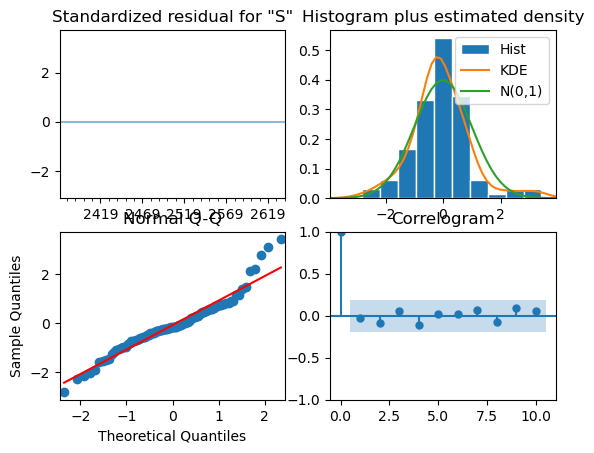

In [121]:
# let's diagnos results
results_auto_SARIMA.plot_diagnostics();

#### Observations
- we observe that the Co.gram is normal dist. and resid are nearly around the line except in the higher side.

In [122]:
## let's predict the best results on the test data and validate the model
predicted_auto_SARIMA = results_auto_SARIMA.get_forecast(steps=len(df_test))

## validate the model.
rmse = mean_squared_error(df_test['Sparkling'],predicted_auto_SARIMA.predicted_mean,squared=False)
mape = mean_absolute_percentage_error(df_test['Sparkling'],predicted_auto_SARIMA.predicted_mean)
print('RMSE:',rmse,'\nMAPE:',mape)

RMSE: 362.98775495281035 
MAPE: 14.353282620909184


In [123]:
resultsDf_SARIMA = pd.DataFrame({'RMSE': rmse,'MAPE':mape}
                           ,index=['SARIMA(2,1,3)(1,0,3,12)'])

resultsDf_SARIMA

,RMSE,MAPE
"SARIMA(2,1,3)(1,0,3,12)",362.987755,14.353283


In [124]:
print(resultsDf_ARIMA)
print(resultsDf_SARIMA)

                     RMSE       MAPE
ARIMA(2,1,2)  1309.630731  42.106066
                               RMSE       MAPE
SARIMA(2,1,3)(1,0,3,12)  362.987755  14.353283


#### Observation
- We observe that SARIMA model with params RMSE and MAPE have better results than ARIMA

In [125]:
## let's add all together in the data frame of all models results
resultsDf = pd.concat([resultsDf,resultsDf_ARIMA['RMSE'],resultsDf_SARIMA['RMSE'] ])
resultsDf

,Test RMSE,0
RegressionOnTime,1337.090220,NaN
Naive On Time Forecast,3979.914692,NaN
Simple Average Forecast,1268.683035,NaN
For Alpha = 0.05 SES Model,1307.534534,NaN
For Alpha = 0.3 SES Model,1900.058569,NaN
"For Alpha=0.688,Beta=0.00009,DES Model",1923.793446,NaN
"For Alpha=0.3,Beta=0.3,DES Model",13814.398308,NaN
"For Alpha=0.075,Beta=0.075,Gamma=0.3342 TES Model",347.021534,NaN
"For Alpha= 0.3,Beta=0.3,Gamma=0.3,TES Model",1843.830509,NaN
"ARIMA(2,1,2)",NaN,1309.630731


## Model Comparison and Final Model Selection

In [126]:
comparison_model_table = pd.concat([resultsDf])
comparison_model_table.sort_values(by = 'Test RMSE')

,Test RMSE,0
"For Alpha=0.075,Beta=0.075,Gamma=0.3342 TES Model",347.021534,NaN
Simple Average Forecast,1268.683035,NaN
For Alpha = 0.05 SES Model,1307.534534,NaN
RegressionOnTime,1337.090220,NaN
"For Alpha= 0.3,Beta=0.3,Gamma=0.3,TES Model",1843.830509,NaN
For Alpha = 0.3 SES Model,1900.058569,NaN
"For Alpha=0.688,Beta=0.00009,DES Model",1923.793446,NaN
Naive On Time Forecast,3979.914692,NaN
"For Alpha=0.3,Beta=0.3,DES Model",13814.398308,NaN
"ARIMA(2,1,2)",NaN,1309.630731


#### Observations
- from the the comparison above we conclude that: 
- Triple Exponential Smoothing for Alpha=0.075,Beta=0.075,Gamma=0.3342 is the best model which has recorded the least error using RMSE test
- also, the 2nd best model could be SARIMA(2,1,3)(1,0,3,12) which also showing low error using RMSE test comapred to the other models

## Forecasting using Final Model

In [127]:
model = ExponentialSmoothing(df['Sparkling'],trend='additive',seasonal='multiplicative',freq='M')
# fit model
model_fit = model.fit(smoothing_level=0.075,smoothing_trend=0.075,smoothing_seasonal=0.3342,optimized=False,use_brute=True)
# make prediction
yhat = model_fit.predict(start='31-08-1995',end='31-08-1996')

/Users/mustafaassem/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:152: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  date_key = Timestamp(key)


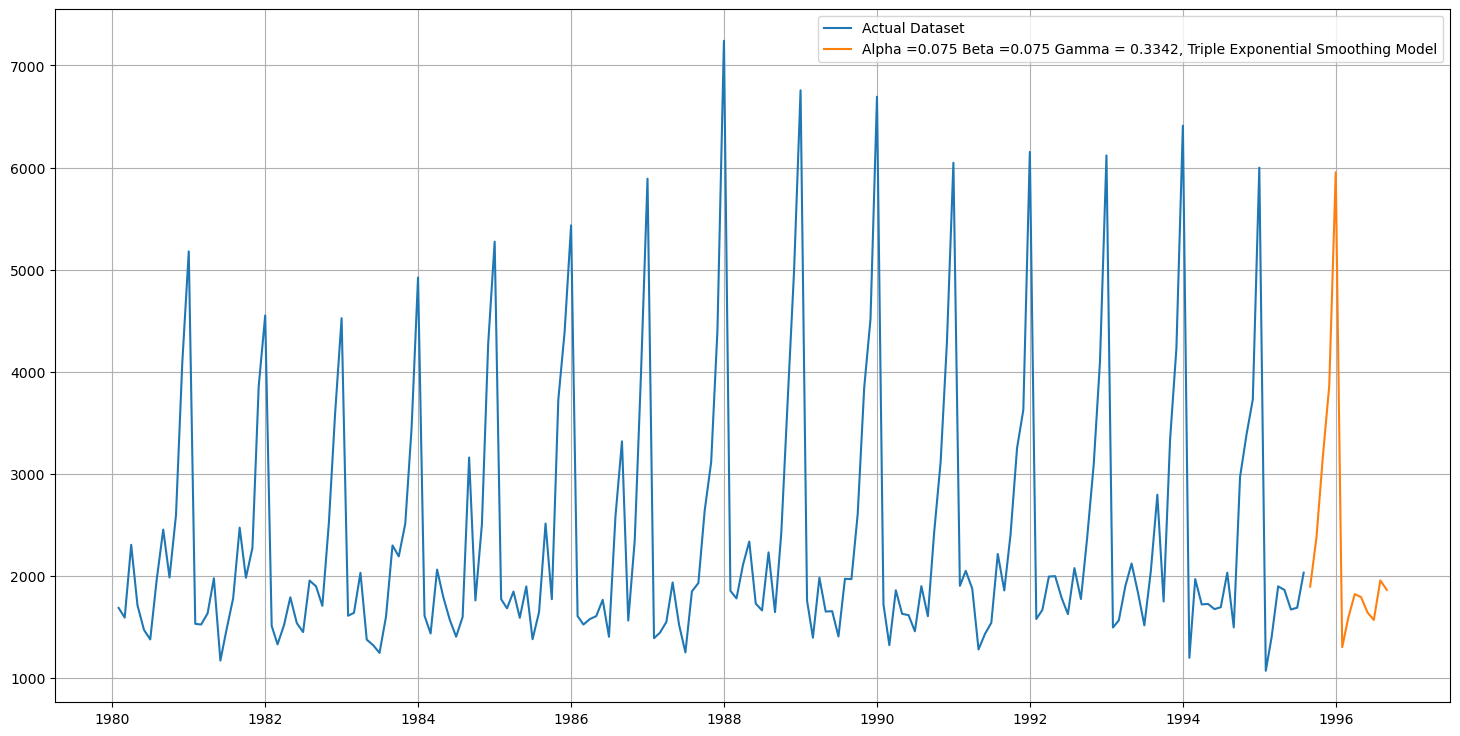

In [128]:
plt.figure(figsize=(18,9))
plt.plot(df['Sparkling'], label='Actual Dataset')


plt.plot(yhat,label='Alpha =0.075 Beta =0.075 Gamma = 0.3342, Triple Exponential Smoothing Model')


plt.legend(loc='best')
plt.grid();

In [129]:
## taking the multiplier to be 1.96 to plot with respect to a 95% confidence intervals.
pred_1_df = pd.DataFrame({'prediction':yhat,
                          'lower_CI':yhat - 1.96*np.std(model_fit.resid,ddof=1),
                          'upper_ci':yhat + 1.96*np.std(model_fit.resid,ddof=1)})
pred_1_df.head()

,prediction,lower_CI,upper_ci
1995-08-31,1894.827425,1209.314205,2580.340646
1995-09-30,2375.558219,1690.044999,3061.071440
1995-10-31,3179.171203,2493.657983,3864.684424
1995-11-30,3860.511605,3174.998385,4546.024826
1995-12-31,5953.742760,5268.229539,6639.255980


In [130]:
pred_1_df.tail()

,prediction,lower_CI,upper_ci
1996-04-30,1791.564467,1106.051246,2477.077687
1996-05-31,1639.964440,954.451220,2325.477660
1996-06-30,1568.367286,882.854066,2253.880506
1996-07-31,1954.793167,1269.279947,2640.306388
1996-08-31,1862.458467,1176.945246,2547.971687


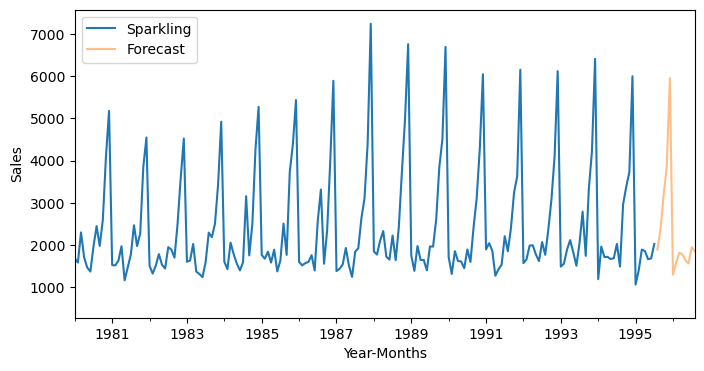

In [131]:
## plot the forcast with CI
axis = df.plot(label='Actual', figsize=(8,4))
pred_1_df['prediction'].plot(ax=axis, label='Forecast', alpha=0.5)
axis.fill_between(pred_1_df.index, pred_1_df['lower_CI'], pred_1_df['upper_ci'], color='k', alpha=.15)
axis.set_xlabel('Year-Months')
axis.set_ylabel('Sales')
plt.legend(loc='best')

plt.show()

#### Observations
- forecast is good fit but confidence band is not showing in this case!!

## Business Insights and Recommendations

#### Business Insights 
- Triple Exponential Smoothing (TES) leads with lowest error (RMSE). It captures trend, seasonality (quarterly), and some monthly variation.

- SARIMA(2,1,3)(1,0,3,12) a close second, suggesting it well captures trend, seasonality (including yearly patterns), and some data patterns.

- Data shows clear seasonality with peaks in Q4 (December) and lows in Q1 & Q2 (June).
- Yearly variations exist with highs in 1988 & 1980, lows in 1995 & 1986.

#### Recommendations:

- from my point of view, we may explore a blended TES & SARIMA model to potentially leverage their strengths for even better accuracy.

- there should be an investigate models that can account for the observed yearly variations in sales data.

- i'd suggest continuously monitor and update the forecasting model as we acquire more data.


__________